# Treasure Hunt Game Notebook

## Read and Review Your Starter Code
The theme of this project is a popular treasure hunt game in which the player needs to find the treasure before the pirate does. While you will not be developing the entire game, you will write the part of the game that represents the intelligent agent, which is a pirate in this case. The pirate will try to find the optimal path to the treasure using deep Q-learning. 

You have been provided with two Python classes and this notebook to help you with this assignment. The first class, TreasureMaze.py, represents the environment, which includes a maze object defined as a matrix. The second class, GameExperience.py, stores the episodes – that is, all the states that come in between the initial state and the terminal state. This is later used by the agent for learning by experience, called "exploration". This notebook shows how to play a game. Your task is to complete the deep Q-learning implementation for which a skeleton implementation has been provided. The code blocks you will need to complete has #TODO as a header.

First, read and review the next few code and instruction blocks to understand the code that you have been given.

In [1]:
from __future__ import print_function
import os, sys, time, datetime, json, random
import numpy as np
from keras.models import Sequential
from keras.layers.core import Dense, Activation
from keras.optimizers import SGD , Adam, RMSprop
from keras.layers.advanced_activations import PReLU
import matplotlib.pyplot as plt
from TreasureMaze import TreasureMaze
from GameExperience import GameExperience
%matplotlib inline

Using TensorFlow backend.


The following code block contains an 8x8 matrix that will be used as a maze object:

In [2]:
maze = np.array([
    [ 1.,  0.,  1.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  0.,  1.,  1.,  1.,  0.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  0.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  0.,  1.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  0.,  1.,  0.,  0.,  0.],
    [ 1.,  1.,  1.,  0.,  1.,  1.,  1.,  1.],
    [ 1.,  1.,  1.,  1.,  0.,  1.,  1.,  1.]
])

This helper function allows a visual representation of the maze object:

In [3]:
def show(qmaze):
    plt.grid('on')
    nrows, ncols = qmaze.maze.shape
    ax = plt.gca()
    ax.set_xticks(np.arange(0.5, nrows, 1))
    ax.set_yticks(np.arange(0.5, ncols, 1))
    ax.set_xticklabels([])
    ax.set_yticklabels([])
    canvas = np.copy(qmaze.maze)
    for row,col in qmaze.visited:
        canvas[row,col] = 0.6
    pirate_row, pirate_col, _ = qmaze.state
    canvas[pirate_row, pirate_col] = 0.3   # pirate cell
    canvas[nrows-1, ncols-1] = 0.9 # treasure cell
    img = plt.imshow(canvas, interpolation='none', cmap='gray')
    return img

The pirate agent can move in four directions: left, right, up, and down. 

While the agent primarily learns by experience through exploitation, often, the agent can choose to explore the environment to find previously undiscovered paths. This is called "exploration" and is defined by epsilon. This value is typically a lower value such as 0.1, which means for every ten attempts, the agent will attempt to learn by experience nine times and will randomly explore a new path one time. You are encouraged to try various values for the exploration factor and see how the algorithm performs.

In [4]:
LEFT = 0
UP = 1
RIGHT = 2
DOWN = 3


# Exploration factor
epsilon = 0.1

# Actions dictionary
actions_dict = {
    LEFT: 'left',
    UP: 'up',
    RIGHT: 'right',
    DOWN: 'down',
}

num_actions = len(actions_dict)


The sample code block and output below show creating a maze object and performing one action (DOWN), which returns the reward. The resulting updated environment is visualized.

reward= -0.04


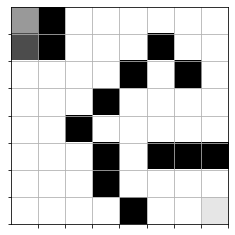

In [5]:
qmaze = TreasureMaze(maze)
canvas, reward, game_over = qmaze.act(DOWN)
print("reward=", reward)
show(qmaze)

This function simulates a full game based on the provided trained model. The other parameters include the TreasureMaze object and the starting position of the pirate.

In [6]:
def play_game(model, qmaze, pirate_cell):
    qmaze.reset(pirate_cell)
    envstate = qmaze.observe()
    while True:
        prev_envstate = envstate
        # get next action
        q = model.predict(prev_envstate)
        action = np.argmax(q[0])

        # apply action, get rewards and new state
        envstate, reward, game_status = qmaze.act(action)
        if game_status == 'win':
            return True
        elif game_status == 'lose':
            return False

This function helps you to determine whether the pirate can win any game at all. If your maze is not well designed, the pirate may not win any game at all. In this case, your training would not yield any result. The provided maze in this notebook ensures that there is a path to win and you can run this method to check.

In [7]:
def completion_check(model, qmaze):
    for cell in qmaze.free_cells:
        if not qmaze.valid_actions(cell):
            return False
        if not play_game(model, qmaze, cell):
            return False
    return True

The code you have been given in this block will build the neural network model. Review the code and note the number of layers, as well as the activation, optimizer, and loss functions that are used to train the model.

In [8]:
def build_model(maze):
    model = Sequential()
    model.add(Dense(maze.size, input_shape=(maze.size,)))
    model.add(PReLU())
    model.add(Dense(maze.size))
    model.add(PReLU())
    model.add(Dense(num_actions))
    model.compile(optimizer='adam', loss='mse')
    return model

# #TODO: Complete the Q-Training Algorithm Code Block

This is your deep Q-learning implementation. The goal of your deep Q-learning implementation is to find the best possible navigation sequence that results in reaching the treasure cell while maximizing the reward. In your implementation, you need to determine the optimal number of epochs to achieve a 100% win rate.

You will need to complete the section starting with #pseudocode. The pseudocode has been included for you.

In [9]:
def qtrain(model, maze, **opt):

    # exploration factor
    global epsilon 

    # number of epochs
    n_epoch = opt.get('n_epoch', 15000)

    # maximum memory to store episodes
    max_memory = opt.get('max_memory', 1000)

    # maximum data size for training
    data_size = opt.get('data_size', 50)

    # start time
    start_time = datetime.datetime.now()

    # Construct environment/game from numpy array: maze (see above)
    qmaze = TreasureMaze(maze)

    # Initialize experience replay object
    experience = GameExperience(model, max_memory=max_memory)
    
    win_history = []   # history of win/lose game
    hsize = qmaze.maze.size//2   # history window size
    win_rate = 0.0
    decayRate = 0.9
    
    # pseudocode:
    # For each epoch:
    #    Agent_cell = randomly select a free cell
    #    Reset the maze with agent set to above position
    #    Hint: Review the reset method in the TreasureMaze.py class.
    #    envstate = Environment.current_state
    #    Hint: Review the observe method in the TreasureMaze.py class.
    #    While state is not game over:
    #        previous_envstate = envstate
    #        Action = randomly choose action (left, right, up, down) either by exploration or by exploitation
    #        envstate, reward, game_status = qmaze.act(action)
    #    Hint: Review the act method in the TreasureMaze.py class.
    #        episode = [previous_envstate, action, reward, envstate, game_status]
    #        Store episode in Experience replay object
    #    Hint: Review the remember method in the GameExperience.py class.
    #        Train neural network model and evaluate loss
    #    Hint: Call GameExperience.get_data to retrieve training data (input and target) and pass to model.fit method 
    #          to train the model. You can call model.evaluate to determine loss.
    #    If the win rate is above the threshold and your model passes the completion check, that would be your epoch.

    for epoch in range(n_epoch):
        print('\n')
        print('---------------')
        print('new epoch started\n')
        print('---------------')
        print('\n')

        #Randomly selecting a free cell to have the agent beign in. With an array having a length of 2
        agent_cell = np.random.randint(0, high=7, size=2)
        
        #resets the agent at the beginning of the maze
        qmaze.reset([0, 0])
        envstate = qmaze.observe()
        loss = 0
        n_episodes = 0
        
        while qmaze.game_status() == 'not_over':
            previous_envstate = envstate
            valid_actions = qmaze.valid_actions()
            if np.random.rand() < epsilon:
                action = random.choice(valid_actions)
            else:
                action = np.argmax(experience.predict(envstate))
                
            envstate, reward, game_status = qmaze.act(action)
            n_episodes += 1
            episode = [previous_envstate, action, reward, envstate, game_status]
            experience.remember(episode)
            
            inputs,targets = experience.get_data()
            history = model.fit(inputs, targets, epochs= 17, batch_size=25, verbose=0)
            loss = model.evaluate(inputs, targets)
            if episode [4] == "win":
                win_history.append(1)
                win_rate = sum(win_history) / len(win_history)
                break
                
            if episode [4] == 'lose':
                win_history.append(0)
                win_rate = sum(win_history) / len(win_history)
                break
                
        if win_rate > epsilon:
            print("win_rate is: ", win_rate)
            
    #Print the epoch, loss, episodes, win count, and win rate for each epoch
        dt = datetime.datetime.now() - start_time
        t = format_time(dt.total_seconds())
        template = "Epoch: {:03d}/{:d} | Loss: {:.4f} | Episodes: {:d} | Win count: {:d} | Win rate: {:.3f} | time: {}"
        print(template.format(epoch, n_epoch-1, loss, n_episodes, sum(win_history), win_rate, t))
        # We simply check if training has exhausted all free cells and if in all
        # cases the agent won.
        if win_rate > 0.9 : epsilon = 0.05
        if sum(win_history[-hsize:]) == hsize and completion_check(model, qmaze):
            print("Reached 100%% win rate at epoch: %d" % (epoch,))
            break
    
    
    # Determine the total time for training
    dt = datetime.datetime.now() - start_time
    seconds = dt.total_seconds()
    t = format_time(seconds)

    print("n_epoch: %d, max_mem: %d, data: %d, time: %s" % (epoch, max_memory, data_size, t))
    return seconds

# This is a small utility for printing readable time strings:
def format_time(seconds):
    if seconds < 400:
        s = float(seconds)
        return "%.1f seconds" % (s,)
    elif seconds < 4000:
        m = seconds / 60.0
        return "%.2f minutes" % (m,)
    else:
        h = seconds / 3600.0
        return "%.2f hours" % (h,)

## Test Your Model

Now we will start testing the deep Q-learning implementation. To begin, select **Cell**, then **Run All** from the menu bar. This will run your notebook. As it runs, you should see output begin to appear beneath the next few cells. The code below creates an instance of TreasureMaze.

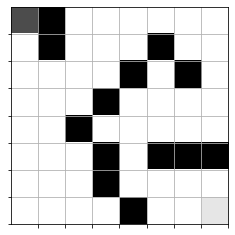

In [10]:
qmaze = TreasureMaze(maze)
show(qmaze)

In the next code block, you will build your model and train it using deep Q-learning. Note: This step takes several minutes to fully run.

In [11]:
model = build_model(maze)
qtrain(model, maze, epochs=1000, max_memory=8*maze.size, data_size=32)



---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
Epoch: 000/14999 | Loss: 0.0009 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 11.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 001/14999 | Loss: 0.0000 | Episodes: 139 | Win count: 0 | Win rate: 0.000 | time: 21.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 002/14999 | Loss: 0.0002 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 30.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 003/14999 | Loss: 0.0001 | Episodes: 141 | Win count: 0 | Win rate: 0.000 | time: 39.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 004/14999 | Loss: 0.0000 | Episodes: 140 | Win count: 0 | Win rate: 0.000 | time: 48.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 52us/step
Epoch: 005/14999 | Loss: 0.0007 | Episodes: 142 | Win count: 0 | Win rate: 0.000 | time: 57.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 006/14999 | Loss: 0.0010 | Episodes: 149 | Win count: 0 | Win rate: 0.000 | time: 67.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 007/14999 | Loss: 0.0004 | Episodes: 143 | Win count: 0 | Win rate: 0.000 | time: 76.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 008/14999 | Loss: 0.0016 | Episodes: 152 | Win count: 0 | Win rate: 0.000 | time: 87.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
Epoch: 009/14999 | Loss: 0.0009 | Episodes: 153 | Win count: 0 | Win rate: 0.000 | time: 97.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 330us/step


10/10 [==============================] - 0s 98us/step
Epoch: 010/14999 | Loss: 0.0018 | Episodes: 160 | Win count: 0 | Win rate: 0.000 | time: 107.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 701us/step


10/10 [==============================] - 0s 178us/step
Epoch: 011/14999 | Loss: 0.0007 | Episodes: 85 | Win count: 1 | Win rate: 0.083 | time: 112.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.15384615384615385
Epoch: 012/14999 | Loss: 0.0183 | Episodes: 98 | Win count: 2 | Win rate: 0.154 | time: 118.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.21428571428571427
Epoch: 013/14999 | Loss: 0.0013 | Episodes: 31 | Win count: 3 | Win rate: 0.214 | time: 120.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.26666666666666666
Epoch: 014/14999 | Loss: 0.0017 | Episodes: 45 | Win count: 4 | Win rate: 0.267 | time: 123.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.3125
Epoch: 015/14999 | Loss: 0.0010 | Episodes: 80 | Win count: 5 | Win rate: 0.312 | time: 128.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 97us/step
win_rate is:  0.35294117647058826
Epoch: 016/14999 | Loss: 0.0007 | Episodes: 31 | Win count: 6 | Win rate: 0.353 | time: 130.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.3888888888888889
Epoch: 017/14999 | Loss: 0.0020 | Episodes: 91 | Win count: 7 | Win rate: 0.389 | time: 136.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 345us/step
win_rate is:  0.42105263157894735
Epoch: 018/14999 | Loss: 0.0012 | Episodes: 56 | Win count: 8 | Win rate: 0.421 | time: 140.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 84us/step
win_rate is:  0.45
Epoch: 019/14999 | Loss: 0.0007 | Episodes: 54 | Win count: 9 | Win rate: 0.450 | time: 143.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.47619047619047616
Epoch: 020/14999 | Loss: 0.0014 | Episodes: 27 | Win count: 10 | Win rate: 0.476 | time: 145.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 198us/step
win_rate is:  0.5
Epoch: 021/14999 | Loss: 0.0005 | Episodes: 40 | Win count: 11 | Win rate: 0.500 | time: 148.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/

10/10 [==============================] - 0s 0us/step
win_rate is:  0.5217391304347826
Epoch: 022/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 12 | Win rate: 0.522 | time: 150.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.5416666666666666
Epoch: 023/14999 | Loss: 0.0013 | Episodes: 38 | Win count: 13 | Win rate: 0.542 | time: 153.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.56
Epoch: 024/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 14 | Win rate: 0.560 | time: 154.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.5769230769230769
Epoch: 025/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 15 | Win rate: 0.577 | time: 156.8 seconds


---------------
new epoch started

---------------


10/10 [==============================]

10/10 [==============================] - 0s 0us/step
win_rate is:  0.5925925925925926
Epoch: 026/14999 | Loss: 0.0006 | Episodes: 58 | Win count: 16 | Win rate: 0.593 | time: 160.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 116us/step
win_rate is:  0.6071428571428571
Epoch: 027/14999 | Loss: 0.0004 | Episodes: 33 | Win count: 17 | Win rate: 0.607 | time: 162.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.6206896551724138
Epoch: 028/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 18 | Win rate: 0.621 | time: 164.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 242us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.6333333333333333
Epoch: 029/14999 | Loss: 0.0006 | Episodes: 50 | Win count: 19 | Win rate: 0.633 | time: 167.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.6451612903225806
Epoch: 030/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 20 | Win rate: 0.645 | time: 169.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.65625
Epoch: 031/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 21 | Win rate: 0.656 | time: 171.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.6666666666666666
Epoch: 032/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 22 | Win rate: 0.667 | time: 173.0 seconds


---------------
new epoch started

---------------


10/10 [============================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.6857142857142857
Epoch: 034/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 24 | Win rate: 0.686 | time: 176.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.6666666666666666
Epoch: 035/14999 | Loss: 0.0001 | Episodes: 144 | Win count: 24 | Win rate: 0.667 | time: 186.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.6756756756756757
Epoch: 036/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 25 | Win rate: 0.676 | time: 188.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.6842105263157895
Epoch: 037/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 26 | Win rate: 0.684 | time: 189.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.6923076923076923
Epoch: 038/14999 | Loss: 0.0006 | Episodes: 71 | Win count: 27 | Win rate: 0.692 | time: 194.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7
Epoch: 039/14999 | Loss: 0.0007 | Episodes: 57 | Win count: 28 | Win rate: 0.700 | time: 198.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.7073170731707317
Epoch: 040/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 29 | Win rate: 0.707 | time: 200.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7142857142857143
Epoch: 041/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 30 | Win rate: 0.714 | time: 201.8 seconds


---------------
new epoch started

---------------


10/10 [==============================]

10/10 [==============================] - 0s 0us/step
win_rate is:  0.7209302325581395
Epoch: 042/14999 | Loss: 0.0003 | Episodes: 45 | Win count: 31 | Win rate: 0.721 | time: 204.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7272727272727273
Epoch: 043/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 32 | Win rate: 0.727 | time: 206.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7333333333333333
Epoch: 044/14999 | Loss: 0.0003 | Episodes: 49 | Win count: 33 | Win rate: 0.733 | time: 209.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7391304347826086
Epoch: 045/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 34 | Win rate: 0.739 | time: 210.8 seconds


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.7446808510638298
Epoch: 046/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 35 | Win rate: 0.745 | time: 212.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.75
Epoch: 047/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 36 | Win rate: 0.750 | time: 214.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7551020408163265
Epoch: 048/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 37 | Win rate: 0.755 | time: 216.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.76
Epoch: 049/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 38 | Win rate: 0.760 | time: 218.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step

10/10 [==============================] - 0s 0us/step
win_rate is:  0.7692307692307693
Epoch: 051/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 40 | Win rate: 0.769 | time: 222.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.7735849056603774
Epoch: 052/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 41 | Win rate: 0.774 | time: 224.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 80us/step
win_rate is:  0.7777777777777778
Epoch: 053/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 42 | Win rate: 0.778 | time: 226.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7818181818181819
Epoch: 054/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 43 | Win rate: 0.782 | time: 228.2 seconds


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.7894736842105263
Epoch: 056/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 45 | Win rate: 0.789 | time: 232.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7931034482758621
Epoch: 057/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 46 | Win rate: 0.793 | time: 235.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.7966101694915254
Epoch: 058/14999 | Loss: 0.0004 | Episodes: 38 | Win count: 47 | Win rate: 0.797 | time: 237.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8
Epoch: 059/14999 | Loss: 0.0002 | Episodes: 25 | Win count: 48 | Win rate: 0.800 | time: 239.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] 

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8032786885245902
Epoch: 060/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 49 | Win rate: 0.803 | time: 241.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8064516129032258
Epoch: 061/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 50 | Win rate: 0.806 | time: 243.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.8095238095238095
Epoch: 062/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 51 | Win rate: 0.810 | time: 245.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8125
Epoch: 063/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 52 | Win rate: 0.812 | time: 247.9 seconds


---------------
new epoch started

---------------


10/10 [===========================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8153846153846154
Epoch: 064/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 53 | Win rate: 0.815 | time: 250.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8181818181818182
Epoch: 065/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 54 | Win rate: 0.818 | time: 252.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8208955223880597
Epoch: 066/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 55 | Win rate: 0.821 | time: 254.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 115us/step
win_rate is:  0.8235294117647058
Epoch: 067/14999 | Loss: 0.0008 | Episodes: 29 | Win count: 56 | Win rate: 0.824 | time: 256.5 seconds


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8260869565217391
Epoch: 068/14999 | Loss: 0.0002 | Episodes: 57 | Win count: 57 | Win rate: 0.826 | time: 260.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.8285714285714286
Epoch: 069/14999 | Loss: 0.0001 | Episodes: 71 | Win count: 58 | Win rate: 0.829 | time: 265.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8309859154929577
Epoch: 070/14999 | Loss: 0.0007 | Episodes: 42 | Win count: 59 | Win rate: 0.831 | time: 269.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 434us/step


10/10 [==============================] - 0s 21us/step
win_rate is:  0.8333333333333334
Epoch: 071/14999 | Loss: 0.0005 | Episodes: 43 | Win count: 60 | Win rate: 0.833 | time: 272.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 52us/step
win_rate is:  0.8356164383561644
Epoch: 072/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 61 | Win rate: 0.836 | time: 274.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8378378378378378
Epoch: 073/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 62 | Win rate: 0.838 | time: 277.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.84
Epoch: 074/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 63 | Win rate: 0.840 | time: 280.2 seconds


---------------
new epoch started

---------------


10/10 [=============================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8421052631578947
Epoch: 075/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 64 | Win rate: 0.842 | time: 282.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8441558441558441
Epoch: 076/14999 | Loss: 0.0006 | Episodes: 34 | Win count: 65 | Win rate: 0.844 | time: 285.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.8461538461538461
Epoch: 077/14999 | Loss: 0.0011 | Episodes: 43 | Win count: 66 | Win rate: 0.846 | time: 288.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8481012658227848
Epoch: 078/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 67 | Win rate: 0.848 | time: 291.3 seconds


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.85
Epoch: 079/14999 | Loss: 0.0004 | Episodes: 57 | Win count: 68 | Win rate: 0.850 | time: 295.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8518518518518519
Epoch: 080/14999 | Loss: 0.0007 | Episodes: 41 | Win count: 69 | Win rate: 0.852 | time: 298.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.8536585365853658
Epoch: 081/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 70 | Win rate: 0.854 | time: 300.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8554216867469879
Epoch: 082/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 71 | Win rate: 0.855 | time: 303.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8571428571428571
Epoch: 083/14999 | Loss: 0.0006 | Episodes: 53 | Win count: 72 | Win rate: 0.857 | time: 307.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8588235294117647
Epoch: 084/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 73 | Win rate: 0.859 | time: 310.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.8604651162790697
Epoch: 085/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 74 | Win rate: 0.860 | time: 313.5 seconds


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8620689655172413
Epoch: 086/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 75 | Win rate: 0.862 | time: 315.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8636363636363636
Epoch: 087/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 76 | Win rate: 0.864 | time: 318.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 130us/step
win_rate is:  0.8651685393258427
Epoch: 088/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 77 | Win rate: 0.865 | time: 321.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.8666666666666667
Epoch: 089/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 78 | Win rate: 0.867 | time: 324.6 seconds


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8681318681318682
Epoch: 090/14999 | Loss: 0.0016 | Episodes: 26 | Win count: 79 | Win rate: 0.868 | time: 326.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8695652173913043
Epoch: 091/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 80 | Win rate: 0.870 | time: 328.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8709677419354839
Epoch: 092/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 81 | Win rate: 0.871 | time: 330.5 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8723404255319149
Epoch: 093/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 82 | Win rate: 0.872 | time: 333.1 seconds


---------------
new epoch started

---------------


10/10 [=================



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.875
Epoch: 095/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 84 | Win rate: 0.875 | time: 339.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 293us/step
win_rate is:  0.8762886597938144
Epoch: 096/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 85 | Win rate: 0.876 | time: 341.8 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8775510204081632
Epoch: 097/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 86 | Win rate: 0.878 | time: 344.7 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8787878787878788
Epoch: 098/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 87 | Win rate: 0.879 | time: 346.5 seconds


---------------
new epoch started

10/10 [==============================] - 0s 93us/step
win_rate is:  0.88
Epoch: 099/14999 | Loss: 0.0006 | Episodes: 42 | Win count: 88 | Win rate: 0.880 | time: 349.4 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8811881188118812
Epoch: 100/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 89 | Win rate: 0.881 | time: 352.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8823529411764706
Epoch: 101/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 90 | Win rate: 0.882 | time: 353.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.883495145631068
Epoch: 102/14999 | Loss: 0.0002 | Episodes: 46 | Win count: 91 | Win rate: 0.883 | time: 357.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8846153846153846
Epoch: 103/14999 | Loss: 0.0001 | Episodes: 42 | Win count: 92 | Win rate: 0.885 | time: 360.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8857142857142857
Epoch: 104/14999 | Loss: 0.0009 | Episodes: 27 | Win count: 93 | Win rate: 0.886 | time: 362.0 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8867924528301887
Epoch: 105/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 94 | Win rate: 0.887 | time: 364.5 seconds


---------------
new epoch started

---------------


10/10 [==================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8878504672897196
Epoch: 106/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 95 | Win rate: 0.888 | time: 366.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8888888888888888
Epoch: 107/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 96 | Win rate: 0.889 | time: 369.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.8899082568807339
Epoch: 108/14999 | Loss: 0.0006 | Episodes: 55 | Win count: 97 | Win rate: 0.890 | time: 373.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8909090909090909
Epoch: 109/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 98 | Win rate: 0.891 | time: 374.8 seconds


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.8918918918918919
Epoch: 110/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 99 | Win rate: 0.892 | time: 377.1 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8928571428571429
Epoch: 111/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 100 | Win rate: 0.893 | time: 378.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8938053097345132
Epoch: 112/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 101 | Win rate: 0.894 | time: 380.6 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.8947368421052632
Epoch: 113/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 102 | Win rate: 0.895 | time: 382.7 seconds


---------------
new epoch started

---------------


10/10 [============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.896551724137931
Epoch: 115/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 104 | Win rate: 0.897 | time: 388.9 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 131us/step
win_rate is:  0.8974358974358975
Epoch: 116/14999 | Loss: 0.0007 | Episodes: 51 | Win count: 105 | Win rate: 0.897 | time: 392.3 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8983050847457628
Epoch: 117/14999 | Loss: 0.0002 | Episodes: 62 | Win count: 106 | Win rate: 0.898 | time: 396.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.8991596638655462
Epoch: 118/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 107 | Win rate: 0.899 | time: 398.2 seconds


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9
Epoch: 119/14999 | Loss: 0.0006 | Episodes: 45 | Win count: 108 | Win rate: 0.900 | time: 6.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9008264462809917
Epoch: 120/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 109 | Win rate: 0.901 | time: 6.71 minutes


---------------
new epoch started

---------------


10/10 [===========================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9024390243902439
Epoch: 122/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 111 | Win rate: 0.902 | time: 6.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9032258064516129
Epoch: 123/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 112 | Win rate: 0.903 | time: 6.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.904
Epoch: 124/14999 | Loss: 0.0004 | Episodes: 52 | Win count: 113 | Win rate: 0.904 | time: 6.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9047619047619048
Epoch: 125/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 114 | Win rate: 0.905 | time: 6.90 minutes


---------------
new epoch started

---------------


10/10 [============================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.905511811023622
Epoch: 126/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 115 | Win rate: 0.906 | time: 6.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.90625
Epoch: 127/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 116 | Win rate: 0.906 | time: 6.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9069767441860465
Epoch: 128/14999 | Loss: 0.0015 | Episodes: 29 | Win count: 117 | Win rate: 0.907 | time: 7.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9076923076923077
Epoch: 129/14999 | Loss: 0.0013 | Episodes: 26 | Win count: 118 | Win rate: 0.908 | time: 7.03 minutes


---------------
new epoch started

---------------


10/10 [============================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9090909090909091
Epoch: 131/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 120 | Win rate: 0.909 | time: 7.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9097744360902256
Epoch: 132/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 121 | Win rate: 0.910 | time: 7.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9104477611940298
Epoch: 133/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 122 | Win rate: 0.910 | time: 7.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9111111111111111
Epoch: 134/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 123 | Win rate: 0.911 | time: 7.18 minutes


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9124087591240876
Epoch: 136/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 125 | Win rate: 0.912 | time: 7.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9130434782608695
Epoch: 137/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 126 | Win rate: 0.913 | time: 7.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9136690647482014
Epoch: 138/14999 | Loss: 0.0000 | Episodes: 78 | Win count: 127 | Win rate: 0.914 | time: 7.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9142857142857143
Epoch: 139/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 128 | Win rate: 0.914 | time: 7.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 76us/step
win_rate is:  0.9148936170212766
Epoch: 140/14999 | Loss: 0.0010 | Episodes: 32 | Win count: 129 | Win rate: 0.915 | time: 7.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9154929577464789
Epoch: 141/14999 | Loss: 0.0004 | Episodes: 53 | Win count: 130 | Win rate: 0.915 | time: 7.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.916083916083916
Epoch: 142/14999 | Loss: 0.0001 | Episodes: 46 | Win count: 131 | Win rate: 0.916 | time: 7.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9166666666666666
Epoch: 143/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 132 | Win rate: 0.917 | time: 7.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9172413793103448
Epoch: 144/14999 | Loss: 0.0008 | Episodes: 40 | Win count: 133 | Win rate: 0.917 | time: 7.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9178082191780822
Epoch: 145/14999 | Loss: 0.0003 | Episodes: 42 | Win count: 134 | Win rate: 0.918 | time: 7.68 minutes


---------------
new epoch started

---------------


10/10 [==================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9183673469387755
Epoch: 146/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 135 | Win rate: 0.918 | time: 7.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.918918918918919
Epoch: 147/14999 | Loss: 0.0001 | Episodes: 74 | Win count: 136 | Win rate: 0.919 | time: 7.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9194630872483222
Epoch: 148/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 137 | Win rate: 0.919 | time: 7.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.92
Epoch: 149/14999 | Loss: 0.0012 | Episodes: 55 | Win count: 138 | Win rate: 0.920 | time: 7.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9205298013245033
Epoch: 150/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 139 | Win rate: 0.921 | time: 7.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 200us/step
win_rate is:  0.9210526315789473
Epoch: 151/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 140 | Win rate: 0.921 | time: 7.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9215686274509803
Epoch: 152/14999 | Loss: 0.0001 | Episodes: 50 | Win count: 141 | Win rate: 0.922 | time: 8.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.922077922077922
Epoch: 153/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 142 | Win rate: 0.922 | time: 8.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9225806451612903
Epoch: 154/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 143 | Win rate: 0.923 | time: 8.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9230769230769231
Epoch: 155/14999 | Loss: 0.0006 | Episodes: 34 | Win count: 144 | Win rate: 0.923 | time: 8.17 minutes


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9240506329113924
Epoch: 157/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 146 | Win rate: 0.924 | time: 8.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 405us/step
win_rate is:  0.9245283018867925
Epoch: 158/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 147 | Win rate: 0.925 | time: 8.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.925
Epoch: 159/14999 | Loss: 0.0001 | Episodes: 53 | Win count: 148 | Win rate: 0.925 | time: 8.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9254658385093167
Epoch: 160/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 149 | Win rate: 0.925 | time: 8.40 minutes


---------------
new epoch started

---------------


10/10 [============================

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9259259259259259
Epoch: 161/14999 | Loss: 0.0001 | Episodes: 51 | Win count: 150 | Win rate: 0.926 | time: 8.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9263803680981595
Epoch: 162/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 151 | Win rate: 0.926 | time: 8.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.926829268292683
Epoch: 163/14999 | Loss: 0.0002 | Episodes: 27 | Win count: 152 | Win rate: 0.927 | time: 8.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9272727272727272
Epoch: 164/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 153 | Win rate: 0.927 | time: 8.55 minutes


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 192us/step
win_rate is:  0.927710843373494
Epoch: 165/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 154 | Win rate: 0.928 | time: 8.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9281437125748503
Epoch: 166/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 155 | Win rate: 0.928 | time: 8.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9285714285714286
Epoch: 167/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 156 | Win rate: 0.929 | time: 8.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9289940828402367
Epoch: 168/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 157 | Win rate: 0.929 | time: 8.71 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9294117647058824
Epoch: 169/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 158 | Win rate: 0.929 | time: 8.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9298245614035088
Epoch: 170/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 159 | Win rate: 0.930 | time: 8.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9302325581395349
Epoch: 171/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 160 | Win rate: 0.930 | time: 8.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.930635838150289
Epoch: 172/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 161 | Win rate: 0.931 | time: 8.86 minutes


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9314285714285714
Epoch: 174/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 163 | Win rate: 0.931 | time: 8.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9318181818181818
Epoch: 175/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 164 | Win rate: 0.932 | time: 8.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9322033898305084
Epoch: 176/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 165 | Win rate: 0.932 | time: 9.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9325842696629213
Epoch: 177/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 166 | Win rate: 0.933 | time: 9.04 minutes


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9333333333333333
Epoch: 179/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 168 | Win rate: 0.933 | time: 9.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9337016574585635
Epoch: 180/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 169 | Win rate: 0.934 | time: 9.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9340659340659341
Epoch: 181/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 170 | Win rate: 0.934 | time: 9.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9344262295081968
Epoch: 182/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 171 | Win rate: 0.934 | time: 9.22 minutes


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9351351351351351
Epoch: 184/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 173 | Win rate: 0.935 | time: 9.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9354838709677419
Epoch: 185/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 174 | Win rate: 0.935 | time: 9.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9358288770053476
Epoch: 186/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 175 | Win rate: 0.936 | time: 9.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9361702127659575
Epoch: 187/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 176 | Win rate: 0.936 | time: 9.40 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9368421052631579
Epoch: 189/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 178 | Win rate: 0.937 | time: 9.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 90us/step
win_rate is:  0.93717277486911
Epoch: 190/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 179 | Win rate: 0.937 | time: 9.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9375
Epoch: 191/14999 | Loss: 0.0001 | Episodes: 100 | Win count: 180 | Win rate: 0.938 | time: 9.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9378238341968912
Epoch: 192/14999 | Loss: 0.0001 | Episodes: 58 | Win count: 181 | Win rate: 0.938 | time: 9.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9381443298969072
Epoch: 193/14999 | Loss: 0.0001 | Episodes: 63 | Win count: 182 | Win rate: 0.938 | time: 9.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


win_rate is:  0.9384615384615385
Epoch: 194/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 183 | Win rate: 0.938 | time: 9.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9387755102040817
Epoch: 195/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 184 | Win rate: 0.939 | time: 9.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9390862944162437
Epoch: 196/14999 | Loss: 0.0025 | Episodes: 26 | Win count: 185 | Win rate: 0.939 | time: 9.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9393939393939394
Epoch: 197/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 186 | Win rate: 0.939 | time: 9.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.93969849

10/10 [==============================] - 0s 97us/step
win_rate is:  0.94
Epoch: 199/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 188 | Win rate: 0.940 | time: 9.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9402985074626866
Epoch: 200/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 189 | Win rate: 0.940 | time: 10.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9405940594059405
Epoch: 201/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 190 | Win rate: 0.941 | time: 10.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9408866995073891
Epoch: 202/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 191 | Win rate: 0.941 | time: 10.08 minutes


---------------
new epoch started

---------------


10/10 [=========================



---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9414634146341463
Epoch: 204/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 193 | Win rate: 0.941 | time: 10.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.941747572815534
Epoch: 205/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 194 | Win rate: 0.942 | time: 10.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9420289855072463
Epoch: 206/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 195 | Win rate: 0.942 | time: 10.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9423076923076923
Epoch: 207/14999 | Loss: 0.0011 | Episodes: 46 | Win count: 196 | Win rate: 0.942 | time: 10.29 minutes


---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9425837320574163
Epoch: 208/14999 | Loss: 0.0000 | Episodes: 118 | Win count: 197 | Win rate: 0.943 | time: 10.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9428571428571428
Epoch: 209/14999 | Loss: 0.0014 | Episodes: 26 | Win count: 198 | Win rate: 0.943 | time: 10.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.943127962085308
Epoch: 210/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 199 | Win rate: 0.943 | time: 10.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9433962264150944
Epoch: 211/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 200 | Win rate: 0.943 | time: 10.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9436619718309859
Epoch: 212/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 201 | Win rate: 0.944 | time: 10.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9439252336448598
Epoch: 213/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 202 | Win rate: 0.944 | time: 10.56 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9444444444444444
Epoch: 215/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 204 | Win rate: 0.944 | time: 10.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9447004608294931
Epoch: 216/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 205 | Win rate: 0.945 | time: 10.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.944954128440367
Epoch: 217/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 206 | Win rate: 0.945 | time: 10.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9452054794520548
Epoch: 218/14999 | Loss: 0.0012 | Episodes: 36 | Win count: 207 | Win rate: 0.945 | time: 10.74 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9457013574660633
Epoch: 220/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 209 | Win rate: 0.946 | time: 10.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9459459459459459
Epoch: 221/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 210 | Win rate: 0.946 | time: 10.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9461883408071748
Epoch: 222/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 211 | Win rate: 0.946 | time: 10.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9464285714285714
Epoch: 223/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 212 | Win rate: 0.946 | time: 10.93 minutes


---------------
new epoch started

---------------


10/10 [==========

win_rate is:  0.9466666666666667
Epoch: 224/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 213 | Win rate: 0.947 | time: 10.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9469026548672567
Epoch: 225/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 214 | Win rate: 0.947 | time: 11.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.947136563876652
Epoch: 226/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 215 | Win rate: 0.947 | time: 11.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9473684210526315
Epoch: 227/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 216 | Win rate: 0.947 | time: 11.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.94759

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9478260869565217
Epoch: 229/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 218 | Win rate: 0.948 | time: 11.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.948051948051948
Epoch: 230/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 219 | Win rate: 0.948 | time: 11.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9482758620689655
Epoch: 231/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 220 | Win rate: 0.948 | time: 11.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9484978540772532
Epoch: 232/14999 | Loss: 0.0001 | Episodes: 43 | Win count: 221 | Win rate: 0.948 | time: 11.29 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9487179487179487
Epoch: 233/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 222 | Win rate: 0.949 | time: 11.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.948936170212766
Epoch: 234/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 223 | Win rate: 0.949 | time: 11.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9491525423728814
Epoch: 235/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 224 | Win rate: 0.949 | time: 11.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9493670886075949
Epoch: 236/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 225 | Win rate: 0.949 | time: 11.43 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9497907949790795
Epoch: 238/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 227 | Win rate: 0.950 | time: 11.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.95
Epoch: 239/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 228 | Win rate: 0.950 | time: 11.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.950207468879668
Epoch: 240/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 229 | Win rate: 0.950 | time: 11.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9504132231404959
Epoch: 241/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 230 | Win rate: 0.950 | time: 11.62 minutes


---------------
new epoch started

---------------


10/10 [=========================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9508196721311475
Epoch: 243/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 232 | Win rate: 0.951 | time: 11.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 79us/step
win_rate is:  0.9510204081632653
Epoch: 244/14999 | Loss: 0.0001 | Episodes: 39 | Win count: 233 | Win rate: 0.951 | time: 11.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9512195121951219
Epoch: 245/14999 | Loss: 0.0007 | Episodes: 40 | Win count: 234 | Win rate: 0.951 | time: 11.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.951417004048583
Epoch: 246/14999 | Loss: 0.0001 | Episodes: 53 | Win count: 235 | Win rate: 0.951 | time: 11.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9516129032258065
Epoch: 247/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 236 | Win rate: 0.952 | time: 11.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9518072289156626
Epoch: 248/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 237 | Win rate: 0.952 | time: 11.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.952
Epoch: 249/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 238 | Win rate: 0.952 | time: 11.94 minutes


---------------
new epoch started

---------------


10/10 [=========================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9523809523809523
Epoch: 251/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 240 | Win rate: 0.952 | time: 12.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9525691699604744
Epoch: 252/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 241 | Win rate: 0.953 | time: 12.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.952755905511811
Epoch: 253/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 242 | Win rate: 0.953 | time: 12.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 264us/step
win_rate is:  0.9529411764705882
Epoch: 254/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 243 | Win rate: 0.953 | time: 12.13 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.953307392996109
Epoch: 256/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 245 | Win rate: 0.953 | time: 12.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9534883720930233
Epoch: 257/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 246 | Win rate: 0.953 | time: 12.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9536679536679536
Epoch: 258/14999 | Loss: 0.0001 | Episodes: 37 | Win count: 247 | Win rate: 0.954 | time: 12.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9538461538461539
Epoch: 259/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 248 | Win rate: 0.954 | time: 12.30 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9541984732824428
Epoch: 261/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 250 | Win rate: 0.954 | time: 12.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9543726235741445
Epoch: 262/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 251 | Win rate: 0.954 | time: 12.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9545454545454546
Epoch: 263/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 252 | Win rate: 0.955 | time: 12.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9547169811320755
Epoch: 264/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 253 | Win rate: 0.955 | time: 12.47 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9550561797752809
Epoch: 266/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 255 | Win rate: 0.955 | time: 12.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 220us/step
win_rate is:  0.9552238805970149
Epoch: 267/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 256 | Win rate: 0.955 | time: 12.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9553903345724907
Epoch: 268/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 257 | Win rate: 0.955 | time: 12.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9555555555555556
Epoch: 269/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 258 | Win rate: 0.956 | time: 12.66 minutes


---------------
new epoch started

---------------


10/10 [===========

win_rate is:  0.955719557195572
Epoch: 270/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 259 | Win rate: 0.956 | time: 12.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9558823529411765
Epoch: 271/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 260 | Win rate: 0.956 | time: 12.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9560439560439561
Epoch: 272/14999 | Loss: 0.0002 | Episodes: 33 | Win count: 261 | Win rate: 0.956 | time: 12.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9562043795620438
Epoch: 273/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 262 | Win rate: 0.956 | time: 12.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.956

10/10 [==============================] - 0s 26us/step
win_rate is:  0.9565217391304348
Epoch: 275/14999 | Loss: 0.0007 | Episodes: 33 | Win count: 264 | Win rate: 0.957 | time: 12.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9566787003610109
Epoch: 276/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 265 | Win rate: 0.957 | time: 12.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9568345323741008
Epoch: 277/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 266 | Win rate: 0.957 | time: 13.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.956989247311828
Epoch: 278/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 267 | Win rate: 0.957 | time: 13.03 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9571428571428572
Epoch: 279/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 268 | Win rate: 0.957 | time: 13.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9572953736654805
Epoch: 280/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 269 | Win rate: 0.957 | time: 13.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9574468085106383
Epoch: 281/14999 | Loss: 0.0014 | Episodes: 26 | Win count: 270 | Win rate: 0.957 | time: 13.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 141us/step
win_rate is:  0.9575971731448764
Epoch: 282/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 271 | Win rate: 0.958 | time: 13.17 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9578947368421052
Epoch: 284/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 273 | Win rate: 0.958 | time: 13.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.958041958041958
Epoch: 285/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 274 | Win rate: 0.958 | time: 13.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9581881533101045
Epoch: 286/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 275 | Win rate: 0.958 | time: 13.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9583333333333334
Epoch: 287/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 276 | Win rate: 0.958 | time: 13.36 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 206us/step
win_rate is:  0.9584775086505191
Epoch: 288/14999 | Loss: 0.0000 | Episodes: 58 | Win count: 277 | Win rate: 0.958 | time: 13.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9586206896551724
Epoch: 289/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 278 | Win rate: 0.959 | time: 13.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 116us/step
win_rate is:  0.9587628865979382
Epoch: 290/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 279 | Win rate: 0.959 | time: 13.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.958904109589041
Epoch: 291/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 280 | Win rate: 0.959 | time: 13.54 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9590443686006825
Epoch: 292/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 281 | Win rate: 0.959 | time: 13.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9591836734693877
Epoch: 293/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 282 | Win rate: 0.959 | time: 13.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 208us/step
win_rate is:  0.9593220338983051
Epoch: 294/14999 | Loss: 0.0011 | Episodes: 29 | Win count: 283 | Win rate: 0.959 | time: 13.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9594594594594594
Epoch: 295/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 284 | Win rate: 0.959 | time: 13.69 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9595959595959596
Epoch: 296/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 285 | Win rate: 0.960 | time: 13.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.959731543624161
Epoch: 297/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 286 | Win rate: 0.960 | time: 13.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 82us/step
win_rate is:  0.959866220735786
Epoch: 298/14999 | Loss: 0.0000 | Episodes: 39 | Win count: 287 | Win rate: 0.960 | time: 13.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.96
Epoch: 299/14999 | Loss: 0.0000 | Episodes: 58 | Win count: 288 | Win rate: 0.960 | time: 13.88 minutes


---------------
new epoch started

---------------


10/10 [============================

10/10 [==============================] - 0s 81us/step
win_rate is:  0.9601328903654485
Epoch: 300/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 289 | Win rate: 0.960 | time: 13.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9602649006622517
Epoch: 301/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 290 | Win rate: 0.960 | time: 13.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9603960396039604
Epoch: 302/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 291 | Win rate: 0.960 | time: 13.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9605263157894737
Epoch: 303/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 292 | Win rate: 0.961 | time: 14.01 minutes


---------------
new epoch started

---------------


10/10 [============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9607843137254902
Epoch: 305/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 294 | Win rate: 0.961 | time: 14.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9609120521172638
Epoch: 306/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 295 | Win rate: 0.961 | time: 14.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.961038961038961
Epoch: 307/14999 | Loss: 0.0000 | Episodes: 92 | Win count: 296 | Win rate: 0.961 | time: 14.24 minutes




---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9611650485436893
Epoch: 308/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 297 | Win rate: 0.961 | time: 14.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9612903225806452
Epoch: 309/14999 | Loss: 0.0000 | Episodes: 110 | Win count: 298 | Win rate: 0.961 | time: 14.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9614147909967846
Epoch: 310/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 299 | Win rate: 0.961 | time: 14.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9615384615384616
Epoch: 311/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 300 | Win rate: 0.962 | time: 14.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9616613418530351
Epoch: 312/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 301 | Win rate: 0.962 | time: 14.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9617834394904459
Epoch: 313/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 302 | Win rate: 0.962 | time: 14.54 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9620253164556962
Epoch: 315/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 304 | Win rate: 0.962 | time: 14.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9621451104100947
Epoch: 316/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 305 | Win rate: 0.962 | time: 14.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9622641509433962
Epoch: 317/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 306 | Win rate: 0.962 | time: 14.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9623824451410659
Epoch: 318/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 307 | Win rate: 0.962 | time: 14.74 minutes


---------------
new epoch started

---------------


10/10 [===========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 203us/step
win_rate is:  0.9626168224299065
Epoch: 320/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 309 | Win rate: 0.963 | time: 14.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9627329192546584
Epoch: 321/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 310 | Win rate: 0.963 | time: 14.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9628482972136223
Epoch: 322/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 311 | Win rate: 0.963 | time: 14.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9629629629629629
Epoch: 323/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 312 | Win rate: 0.963 | time: 14.95 minutes


---------------

10/10 [==============================] - 0s 101us/step
win_rate is:  0.963076923076923
Epoch: 324/14999 | Loss: 0.0003 | Episodes: 31 | Win count: 313 | Win rate: 0.963 | time: 14.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9631901840490797
Epoch: 325/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 314 | Win rate: 0.963 | time: 15.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.963302752293578
Epoch: 326/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 315 | Win rate: 0.963 | time: 15.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9634146341463414
Epoch: 327/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 316 | Win rate: 0.963 | time: 15.10 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9635258358662614
Epoch: 328/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 317 | Win rate: 0.964 | time: 15.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9636363636363636
Epoch: 329/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 318 | Win rate: 0.964 | time: 15.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9637462235649547
Epoch: 330/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 319 | Win rate: 0.964 | time: 15.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.963855421686747
Epoch: 331/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 320 | Win rate: 0.964 | time: 15.25 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9640718562874252
Epoch: 333/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 322 | Win rate: 0.964 | time: 15.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9641791044776119
Epoch: 334/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 323 | Win rate: 0.964 | time: 15.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9642857142857143
Epoch: 335/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 324 | Win rate: 0.964 | time: 15.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9643916913946587
Epoch: 336/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 325 | Win rate: 0.964 | time: 15.43 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9646017699115044
Epoch: 338/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 327 | Win rate: 0.965 | time: 15.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9647058823529412
Epoch: 339/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 328 | Win rate: 0.965 | time: 15.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9648093841642229
Epoch: 340/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 329 | Win rate: 0.965 | time: 15.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9649122807017544
Epoch: 341/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 330 | Win rate: 0.965 | time: 15.63 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9650145772594753
Epoch: 342/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 331 | Win rate: 0.965 | time: 15.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9651162790697675
Epoch: 343/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 332 | Win rate: 0.965 | time: 15.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9652173913043478
Epoch: 344/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 333 | Win rate: 0.965 | time: 15.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 159us/step
win_rate is:  0.9653179190751445
Epoch: 345/14999 | Loss: 0.0010 | Episodes: 38 | Win count: 334 | Win rate: 0.965 | time: 15.79 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9655172413793104
Epoch: 347/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 336 | Win rate: 0.966 | time: 15.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9656160458452722
Epoch: 348/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 337 | Win rate: 0.966 | time: 15.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9657142857142857
Epoch: 349/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 338 | Win rate: 0.966 | time: 15.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9658119658119658
Epoch: 350/14999 | Loss: 0.0010 | Episodes: 40 | Win count: 339 | Win rate: 0.966 | time: 15.97 minutes


---------------
new epoch started

---------------


10/10 [=============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9660056657223796
Epoch: 352/14999 | Loss: 0.0005 | Episodes: 78 | Win count: 341 | Win rate: 0.966 | time: 16.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9661016949152542
Epoch: 353/14999 | Loss: 0.0008 | Episodes: 41 | Win count: 342 | Win rate: 0.966 | time: 16.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9661971830985916
Epoch: 354/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 343 | Win rate: 0.966 | time: 16.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9662921348314607
Epoch: 355/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 344 | Win rate: 0.966 | time: 16.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9663865546218487
Epoch: 356/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 345 | Win rate: 0.966 | time: 16.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9664804469273743
Epoch: 357/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 346 | Win rate: 0.966 | time: 16.28 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9666666666666667
Epoch: 359/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 348 | Win rate: 0.967 | time: 16.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 90us/step
win_rate is:  0.9667590027700831
Epoch: 360/14999 | Loss: 0.0008 | Episodes: 44 | Win count: 349 | Win rate: 0.967 | time: 16.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9668508287292817
Epoch: 361/14999 | Loss: 0.0004 | Episodes: 37 | Win count: 350 | Win rate: 0.967 | time: 16.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9669421487603306
Epoch: 362/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 351 | Win rate: 0.967 | time: 16.48 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.967032967032967
Epoch: 363/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 352 | Win rate: 0.967 | time: 16.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9671232876712329
Epoch: 364/14999 | Loss: 0.0005 | Episodes: 48 | Win count: 353 | Win rate: 0.967 | time: 16.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9672131147540983
Epoch: 365/14999 | Loss: 0.0001 | Episodes: 39 | Win count: 354 | Win rate: 0.967 | time: 16.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9673024523160763
Epoch: 366/14999 | Loss: 0.0003 | Episodes: 44 | Win count: 355 | Win rate: 0.967 | time: 16.66 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 323us/step
win_rate is:  0.967391304347826
Epoch: 367/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 356 | Win rate: 0.967 | time: 16.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.967479674796748
Epoch: 368/14999 | Loss: 0.0005 | Episodes: 38 | Win count: 357 | Win rate: 0.967 | time: 16.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9675675675675676
Epoch: 369/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 358 | Win rate: 0.968 | time: 16.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.967654986522911
Epoch: 370/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 359 | Win rate: 0.968 | time: 16.82 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 98us/step
win_rate is:  0.967741935483871
Epoch: 371/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 360 | Win rate: 0.968 | time: 16.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.967828418230563
Epoch: 372/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 361 | Win rate: 0.968 | time: 16.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9679144385026738
Epoch: 373/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 362 | Win rate: 0.968 | time: 16.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.968
Epoch: 374/14999 | Loss: 0.0001 | Episodes: 57 | Win count: 363 | Win rate: 0.968 | time: 16.99 minutes


---------------
new epoch started

---------------


10/10 [==========================

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9680851063829787
Epoch: 375/14999 | Loss: 0.0000 | Episodes: 46 | Win count: 364 | Win rate: 0.968 | time: 17.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9681697612732095
Epoch: 376/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 365 | Win rate: 0.968 | time: 17.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9682539682539683
Epoch: 377/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 366 | Win rate: 0.968 | time: 17.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9683377308707124
Epoch: 378/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 367 | Win rate: 0.968 | time: 17.15 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.968421052631579
Epoch: 379/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 368 | Win rate: 0.968 | time: 17.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.968503937007874
Epoch: 380/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 369 | Win rate: 0.969 | time: 17.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9685863874345549
Epoch: 381/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 370 | Win rate: 0.969 | time: 17.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9686684073107049
Epoch: 382/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 371 | Win rate: 0.969 | time: 17.28 minutes


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 16us/step
win_rate is:  0.9689119170984456
Epoch: 385/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 374 | Win rate: 0.969 | time: 17.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9689922480620154
Epoch: 386/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 375 | Win rate: 0.969 | time: 17.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 218us/step
win_rate is:  0.9690721649484536
Epoch: 387/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 376 | Win rate: 0.969 | time: 17.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9691516709511568
Epoch: 388/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 377 | Win rate: 0.969 | time: 17.50 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.969309462915601
Epoch: 390/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 379 | Win rate: 0.969 | time: 17.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9693877551020408
Epoch: 391/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 380 | Win rate: 0.969 | time: 17.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9694656488549618
Epoch: 392/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 381 | Win rate: 0.969 | time: 17.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 173us/step
win_rate is:  0.9695431472081218
Epoch: 393/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 382 | Win rate: 0.970 | time: 17.66 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9696969696969697
Epoch: 395/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 384 | Win rate: 0.970 | time: 17.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9697732997481109
Epoch: 396/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 385 | Win rate: 0.970 | time: 17.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9698492462311558
Epoch: 397/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 386 | Win rate: 0.970 | time: 17.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9699248120300752
Epoch: 398/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 387 | Win rate: 0.970 | time: 17.82 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.970074812967581
Epoch: 400/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 389 | Win rate: 0.970 | time: 17.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9701492537313433
Epoch: 401/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 390 | Win rate: 0.970 | time: 17.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9702233250620348
Epoch: 402/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 391 | Win rate: 0.970 | time: 17.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9702970297029703
Epoch: 403/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 392 | Win rate: 0.970 | time: 17.99 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9704433497536946
Epoch: 405/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 394 | Win rate: 0.970 | time: 18.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9705159705159705
Epoch: 406/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 395 | Win rate: 0.971 | time: 18.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9705882352941176
Epoch: 407/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 396 | Win rate: 0.971 | time: 18.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9706601466992665
Epoch: 408/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 397 | Win rate: 0.971 | time: 18.17 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9708029197080292
Epoch: 410/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 399 | Win rate: 0.971 | time: 18.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.970873786407767
Epoch: 411/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 400 | Win rate: 0.971 | time: 18.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 458us/step
win_rate is:  0.9709443099273608
Epoch: 412/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 401 | Win rate: 0.971 | time: 18.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9710144927536232
Epoch: 413/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 402 | Win rate: 0.971 | time: 18.36 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9711538461538461
Epoch: 415/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 404 | Win rate: 0.971 | time: 18.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9712230215827338
Epoch: 416/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 405 | Win rate: 0.971 | time: 18.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9712918660287081
Epoch: 417/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 406 | Win rate: 0.971 | time: 18.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9713603818615751
Epoch: 418/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 407 | Win rate: 0.971 | time: 18.55 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9714964370546318
Epoch: 420/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 409 | Win rate: 0.971 | time: 18.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9715639810426541
Epoch: 421/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 410 | Win rate: 0.972 | time: 18.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9716312056737588
Epoch: 422/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 411 | Win rate: 0.972 | time: 18.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9716981132075472
Epoch: 423/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 412 | Win rate: 0.972 | time: 18.73 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.971830985915493
Epoch: 425/14999 | Loss: 0.0007 | Episodes: 32 | Win count: 414 | Win rate: 0.972 | time: 18.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9718969555035128
Epoch: 426/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 415 | Win rate: 0.972 | time: 18.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9719626168224299
Epoch: 427/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 416 | Win rate: 0.972 | time: 18.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.972027972027972
Epoch: 428/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 417 | Win rate: 0.972 | time: 18.92 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9721577726218097
Epoch: 430/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 419 | Win rate: 0.972 | time: 19.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9722222222222222
Epoch: 431/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 420 | Win rate: 0.972 | time: 19.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9722863741339491
Epoch: 432/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 421 | Win rate: 0.972 | time: 19.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9723502304147466
Epoch: 433/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 422 | Win rate: 0.972 | time: 19.12 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9724137931034482
Epoch: 434/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 423 | Win rate: 0.972 | time: 19.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9724770642201835
Epoch: 435/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 424 | Win rate: 0.972 | time: 19.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9725400457665904
Epoch: 436/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 425 | Win rate: 0.973 | time: 19.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9726027397260274
Epoch: 437/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 426 | Win rate: 0.973 | time: 19.28 minutes


---------------
new epoch started

---------------


10/10 [=============

win_rate is:  0.9727272727272728
Epoch: 439/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 428 | Win rate: 0.973 | time: 19.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9727891156462585
Epoch: 440/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 429 | Win rate: 0.973 | time: 19.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9728506787330317
Epoch: 441/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 430 | Win rate: 0.973 | time: 19.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9729119638826185
Epoch: 442/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 431 | Win rate: 0.973 | time: 19.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.972972972972973
Epoch: 443/14999 | Loss: 0.0006 | Episodes: 37 | Win count: 432 | Win rate: 0.973 | time: 19.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9730337078651685
Epoch: 444/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 433 | Win rate: 0.973 | time: 19.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9730941704035875
Epoch: 445/14999 | Loss: 0.0000 | Episodes: 58 | Win count: 434 | Win rate: 0.973 | time: 19.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9731543624161074
Epoch: 446/14999 | Loss: 0.0001 | Episodes: 49 | Win count: 435 | Win rate: 0.973 | time: 19.72 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9732142857142857
Epoch: 447/14999 | Loss: 0.0005 | Episodes: 41 | Win count: 436 | Win rate: 0.973 | time: 19.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9732739420935412
Epoch: 448/14999 | Loss: 0.0000 | Episodes: 62 | Win count: 437 | Win rate: 0.973 | time: 19.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9733333333333334
Epoch: 449/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 438 | Win rate: 0.973 | time: 19.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9733924611973392
Epoch: 450/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 439 | Win rate: 0.973 | time: 19.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9734513274336283
Epoch: 451/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 440 | Win rate: 0.973 | time: 19.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9735099337748344
Epoch: 452/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 441 | Win rate: 0.974 | time: 19.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.973568281938326
Epoch: 453/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 442 | Win rate: 0.974 | time: 20.03 minutes


---------------
new epoch started

---------------


10/10 [==============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9736842105263158
Epoch: 455/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 444 | Win rate: 0.974 | time: 20.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.973741794310722
Epoch: 456/14999 | Loss: 0.0000 | Episodes: 75 | Win count: 445 | Win rate: 0.974 | time: 20.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9737991266375546
Epoch: 457/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 446 | Win rate: 0.974 | time: 20.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9738562091503268
Epoch: 458/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 447 | Win rate: 0.974 | time: 20.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9739130434782609
Epoch: 459/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 448 | Win rate: 0.974 | time: 20.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9739696312364425
Epoch: 460/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 449 | Win rate: 0.974 | time: 20.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.974025974025974
Epoch: 461/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 450 | Win rate: 0.974 | time: 20.41 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9741379310344828
Epoch: 463/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 452 | Win rate: 0.974 | time: 20.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9741935483870968
Epoch: 464/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 453 | Win rate: 0.974 | time: 20.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9742489270386266
Epoch: 465/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 454 | Win rate: 0.974 | time: 20.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.974304068522484
Epoch: 466/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 455 | Win rate: 0.974 | time: 20.62 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9743589743589743
Epoch: 467/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 456 | Win rate: 0.974 | time: 20.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9744136460554371
Epoch: 468/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 457 | Win rate: 0.974 | time: 20.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9744680851063829
Epoch: 469/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 458 | Win rate: 0.974 | time: 20.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9745222929936306
Epoch: 470/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 459 | Win rate: 0.975 | time: 20.78 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 105us/step
win_rate is:  0.9746300211416491
Epoch: 472/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 461 | Win rate: 0.975 | time: 20.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9746835443037974
Epoch: 473/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 462 | Win rate: 0.975 | time: 20.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9747368421052631
Epoch: 474/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 463 | Win rate: 0.975 | time: 20.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9747899159663865
Epoch: 475/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 464 | Win rate: 0.975 | time: 20.98 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9748427672955975
Epoch: 476/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 465 | Win rate: 0.975 | time: 21.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9748953974895398
Epoch: 477/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 466 | Win rate: 0.975 | time: 21.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9749478079331941
Epoch: 478/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 467 | Win rate: 0.975 | time: 21.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.975
Epoch: 479/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 468 | Win rate: 0.975 | time: 21.14 minutes


---------------
new epoch started

---------------


10/10 [=======================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.975103734439834
Epoch: 481/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 470 | Win rate: 0.975 | time: 21.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 86us/step
win_rate is:  0.9751552795031055
Epoch: 482/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 471 | Win rate: 0.975 | time: 21.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9752066115702479
Epoch: 483/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 472 | Win rate: 0.975 | time: 21.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9752577319587629
Epoch: 484/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 473 | Win rate: 0.975 | time: 21.33 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 212us/step
win_rate is:  0.9753593429158111
Epoch: 486/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 475 | Win rate: 0.975 | time: 21.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9754098360655737
Epoch: 487/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 476 | Win rate: 0.975 | time: 21.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9754601226993865
Epoch: 488/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 477 | Win rate: 0.975 | time: 21.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9755102040816327
Epoch: 489/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 478 | Win rate: 0.976 | time: 21.52 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 101us/step
win_rate is:  0.975609756097561
Epoch: 491/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 480 | Win rate: 0.976 | time: 21.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9756592292089249
Epoch: 492/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 481 | Win rate: 0.976 | time: 21.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9757085020242915
Epoch: 493/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 482 | Win rate: 0.976 | time: 21.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 147us/step
win_rate is:  0.9757575757575757
Epoch: 494/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 483 | Win rate: 0.976 | time: 21.71 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9758551307847082
Epoch: 496/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 485 | Win rate: 0.976 | time: 21.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9759036144578314
Epoch: 497/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 486 | Win rate: 0.976 | time: 21.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9759519038076152
Epoch: 498/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 487 | Win rate: 0.976 | time: 21.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.976
Epoch: 499/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 488 | Win rate: 0.976 | time: 21.91 minutes


---------------
new epoch started

---------------


10/10 [========================



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9760956175298805
Epoch: 501/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 490 | Win rate: 0.976 | time: 22.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9761431411530815
Epoch: 502/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 491 | Win rate: 0.976 | time: 22.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9761904761904762
Epoch: 503/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 492 | Win rate: 0.976 | time: 22.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9762376237623762
Epoch: 504/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 493 | Win rate: 0.976 | time: 22.13 minutes


---------------

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9762845849802372
Epoch: 505/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 494 | Win rate: 0.976 | time: 22.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9763313609467456
Epoch: 506/14999 | Loss: 0.0002 | Episodes: 43 | Win count: 495 | Win rate: 0.976 | time: 22.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 133us/step
win_rate is:  0.9763779527559056
Epoch: 507/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 496 | Win rate: 0.976 | time: 22.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9764243614931237
Epoch: 508/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 497 | Win rate: 0.976 | time: 22.30 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9764705882352941
Epoch: 509/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 498 | Win rate: 0.976 | time: 22.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9765166340508806
Epoch: 510/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 499 | Win rate: 0.977 | time: 22.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9765625
Epoch: 511/14999 | Loss: 0.0001 | Episodes: 43 | Win count: 500 | Win rate: 0.977 | time: 22.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 201us/step
win_rate is:  0.9766081871345029
Epoch: 512/14999 | Loss: 0.0001 | Episodes: 72 | Win count: 501 | Win rate: 0.977 | time: 22.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9766536964980544
Epoch: 513/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 502 | Win rate: 0.977 | time: 22.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9766990291262136
Epoch: 514/14999 | Loss: 0.0001 | Episodes: 68 | Win count: 503 | Win rate: 0.977 | time: 22.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9767441860465116
Epoch: 515/14999 | Loss: 0.0004 | Episodes: 40 | Win count: 504 | Win rate: 0.977 | time: 22.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.97678916827853
Epoch: 516/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 505 | Win rate: 0.977 | time: 22.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9768339768339769
Epoch: 517/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 506 | Win rate: 0.977 | time: 22.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.976878612716763
Epoch: 518/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 507 | Win rate: 0.977 | time: 22.76 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9769673704414588
Epoch: 520/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 509 | Win rate: 0.977 | time: 22.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9770114942528736
Epoch: 521/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 510 | Win rate: 0.977 | time: 22.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9770554493307839
Epoch: 522/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 511 | Win rate: 0.977 | time: 22.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9770992366412213
Epoch: 523/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 512 | Win rate: 0.977 | time: 22.98 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9771428571428571
Epoch: 524/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 513 | Win rate: 0.977 | time: 23.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9771863117870723
Epoch: 525/14999 | Loss: 0.0002 | Episodes: 48 | Win count: 514 | Win rate: 0.977 | time: 23.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9772296015180265
Epoch: 526/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 515 | Win rate: 0.977 | time: 23.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9772727272727273
Epoch: 527/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 516 | Win rate: 0.977 | time: 23.16 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9773156899810964
Epoch: 528/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 517 | Win rate: 0.977 | time: 23.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9773584905660377
Epoch: 529/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 518 | Win rate: 0.977 | time: 23.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9774011299435028
Epoch: 530/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 519 | Win rate: 0.977 | time: 23.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9774436090225563
Epoch: 531/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 520 | Win rate: 0.977 | time: 23.30 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 110us/step
win_rate is:  0.9775280898876404
Epoch: 533/14999 | Loss: 0.0005 | Episodes: 44 | Win count: 522 | Win rate: 0.978 | time: 23.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9775700934579439
Epoch: 534/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 523 | Win rate: 0.978 | time: 23.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9776119402985075
Epoch: 535/14999 | Loss: 0.0009 | Episodes: 34 | Win count: 524 | Win rate: 0.978 | time: 23.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9776536312849162
Epoch: 536/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 525 | Win rate: 0.978 | time: 23.49 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 69us/step
win_rate is:  0.9776951672862454
Epoch: 537/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 526 | Win rate: 0.978 | time: 23.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 88us/step
win_rate is:  0.9777365491651205
Epoch: 538/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 527 | Win rate: 0.978 | time: 23.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9777777777777777
Epoch: 539/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 528 | Win rate: 0.978 | time: 23.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.977818853974122
Epoch: 540/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 529 | Win rate: 0.978 | time: 23.65 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9779005524861878
Epoch: 542/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 531 | Win rate: 0.978 | time: 23.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9779411764705882
Epoch: 543/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 532 | Win rate: 0.978 | time: 23.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 135us/step
win_rate is:  0.9779816513761468
Epoch: 544/14999 | Loss: 0.0007 | Episodes: 86 | Win count: 533 | Win rate: 0.978 | time: 23.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 97us/step
win_rate is:  0.978021978021978
Epoch: 545/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 534 | Win rate: 0.978 | time: 23.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9780621572212066
Epoch: 546/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 535 | Win rate: 0.978 | time: 23.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9781021897810219
Epoch: 547/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 536 | Win rate: 0.978 | time: 23.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9781420765027322
Epoch: 548/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 537 | Win rate: 0.978 | time: 24.02 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9782214156079855
Epoch: 550/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 539 | Win rate: 0.978 | time: 24.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9782608695652174
Epoch: 551/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 540 | Win rate: 0.978 | time: 24.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9783001808318263
Epoch: 552/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 541 | Win rate: 0.978 | time: 24.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9783393501805054
Epoch: 553/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 542 | Win rate: 0.978 | time: 24.20 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9784172661870504
Epoch: 555/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 544 | Win rate: 0.978 | time: 24.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9784560143626571
Epoch: 556/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 545 | Win rate: 0.978 | time: 24.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.978494623655914
Epoch: 557/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 546 | Win rate: 0.978 | time: 24.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9785330948121646
Epoch: 558/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 547 | Win rate: 0.979 | time: 24.42 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 275us/step
win_rate is:  0.9785714285714285
Epoch: 559/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 548 | Win rate: 0.979 | time: 24.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9786096256684492
Epoch: 560/14999 | Loss: 0.0001 | Episodes: 158 | Win count: 549 | Win rate: 0.979 | time: 24.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9786476868327402
Epoch: 561/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 550 | Win rate: 0.979 | time: 24.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9786856127886323
Epoch: 562/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 551 | Win rate: 0.979 | time: 24.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9787234042553191
Epoch: 563/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 552 | Win rate: 0.979 | time: 24.73 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9787985865724381
Epoch: 565/14999 | Loss: 0.0011 | Episodes: 37 | Win count: 554 | Win rate: 0.979 | time: 24.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9788359788359788
Epoch: 566/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 555 | Win rate: 0.979 | time: 24.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9788732394366197
Epoch: 567/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 556 | Win rate: 0.979 | time: 24.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9789103690685413
Epoch: 568/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 557 | Win rate: 0.979 | time: 24.92 minutes


---------------
new epoch started

---------------


10/10 [===========

win_rate is:  0.9789473684210527
Epoch: 569/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 558 | Win rate: 0.979 | time: 24.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.978984238178634
Epoch: 570/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 559 | Win rate: 0.979 | time: 24.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9790209790209791
Epoch: 571/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 560 | Win rate: 0.979 | time: 25.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9790575916230366
Epoch: 572/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 561 | Win rate: 0.979 | time: 25.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.97909

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9791304347826087
Epoch: 574/14999 | Loss: 0.0004 | Episodes: 80 | Win count: 563 | Win rate: 0.979 | time: 25.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9791666666666666
Epoch: 575/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 564 | Win rate: 0.979 | time: 25.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9792027729636048
Epoch: 576/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 565 | Win rate: 0.979 | time: 25.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9792387543252595
Epoch: 577/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 566 | Win rate: 0.979 | time: 25.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9792746113989638
Epoch: 578/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 567 | Win rate: 0.979 | time: 25.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9793103448275862
Epoch: 579/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 568 | Win rate: 0.979 | time: 25.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9793459552495697
Epoch: 580/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 569 | Win rate: 0.979 | time: 25.41 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9794168096054888
Epoch: 582/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 571 | Win rate: 0.979 | time: 25.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9794520547945206
Epoch: 583/14999 | Loss: 0.0002 | Episodes: 41 | Win count: 572 | Win rate: 0.979 | time: 25.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9794871794871794
Epoch: 584/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 573 | Win rate: 0.979 | time: 25.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9795221843003413
Epoch: 585/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 574 | Win rate: 0.980 | time: 25.60 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 50us/step
win_rate is:  0.9795918367346939
Epoch: 587/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 576 | Win rate: 0.980 | time: 25.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9796264855687606
Epoch: 588/14999 | Loss: 0.0004 | Episodes: 48 | Win count: 577 | Win rate: 0.980 | time: 25.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9796610169491525
Epoch: 589/14999 | Loss: 0.0007 | Episodes: 34 | Win count: 578 | Win rate: 0.980 | time: 25.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9796954314720813
Epoch: 590/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 579 | Win rate: 0.980 | time: 25.79 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9797297297297297
Epoch: 591/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 580 | Win rate: 0.980 | time: 25.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9797639123102867
Epoch: 592/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 581 | Win rate: 0.980 | time: 25.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9797979797979798
Epoch: 593/14999 | Loss: 0.0011 | Episodes: 40 | Win count: 582 | Win rate: 0.980 | time: 25.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9798319327731092
Epoch: 594/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 583 | Win rate: 0.980 | time: 25.97 minutes




---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9798657718120806
Epoch: 595/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 584 | Win rate: 0.980 | time: 26.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9798994974874372
Epoch: 596/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 585 | Win rate: 0.980 | time: 26.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.979933110367893
Epoch: 597/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 586 | Win rate: 0.980 | time: 26.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9799666110183639
Epoch: 598/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 587 | Win rate: 0.980 | time: 26.12 minutes


---------------
new

10/10 [==============================] - 0s 0us/step
win_rate is:  0.98
Epoch: 599/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 588 | Win rate: 0.980 | time: 26.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9800332778702163
Epoch: 600/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 589 | Win rate: 0.980 | time: 26.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9800664451827242
Epoch: 601/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 590 | Win rate: 0.980 | time: 26.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 496us/step
win_rate is:  0.9800995024875622
Epoch: 602/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 591 | Win rate: 0.980 | time: 26.28 minutes


---------------
new epoch started

---------------


10/10 [========================

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9801652892561984
Epoch: 604/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 593 | Win rate: 0.980 | time: 26.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9801980198019802
Epoch: 605/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 594 | Win rate: 0.980 | time: 26.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9802306425041186
Epoch: 606/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 595 | Win rate: 0.980 | time: 26.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9802631578947368
Epoch: 607/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 596 | Win rate: 0.980 | time: 26.47 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.980327868852459
Epoch: 609/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 598 | Win rate: 0.980 | time: 26.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 170us/step
win_rate is:  0.9803600654664485
Epoch: 610/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 599 | Win rate: 0.980 | time: 26.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9803921568627451
Epoch: 611/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 600 | Win rate: 0.980 | time: 26.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9804241435562806
Epoch: 612/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 601 | Win rate: 0.980 | time: 26.64 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9804878048780488
Epoch: 614/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 603 | Win rate: 0.980 | time: 26.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9805194805194806
Epoch: 615/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 604 | Win rate: 0.981 | time: 26.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9805510534846029
Epoch: 616/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 605 | Win rate: 0.981 | time: 26.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9805825242718447
Epoch: 617/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 606 | Win rate: 0.981 | time: 26.80 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 13us/step
win_rate is:  0.9806451612903225
Epoch: 619/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 608 | Win rate: 0.981 | time: 26.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9806763285024155
Epoch: 620/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 609 | Win rate: 0.981 | time: 26.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9807073954983923
Epoch: 621/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 610 | Win rate: 0.981 | time: 26.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9807383627608347
Epoch: 622/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 611 | Win rate: 0.981 | time: 26.96 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9808
Epoch: 624/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 613 | Win rate: 0.981 | time: 27.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9808306709265175
Epoch: 625/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 614 | Win rate: 0.981 | time: 27.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9808612440191388
Epoch: 626/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 615 | Win rate: 0.981 | time: 27.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9808917197452229
Epoch: 627/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 616 | Win rate: 0.981 | time: 27.14 minutes


---------------
new epoch started

---------------


10/10 [=======================

win_rate is:  0.9809220985691574
Epoch: 628/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 617 | Win rate: 0.981 | time: 27.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9809523809523809
Epoch: 629/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 618 | Win rate: 0.981 | time: 27.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9809825673534073
Epoch: 630/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 619 | Win rate: 0.981 | time: 27.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 137us/step
win_rate is:  0.9810126582278481
Epoch: 631/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 620 | Win rate: 0.981 | time: 27.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  

10/10 [==============================] - 0s 103us/step
win_rate is:  0.9811023622047244
Epoch: 634/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 623 | Win rate: 0.981 | time: 27.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9811320754716981
Epoch: 635/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 624 | Win rate: 0.981 | time: 27.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9811616954474097
Epoch: 636/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 625 | Win rate: 0.981 | time: 27.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9811912225705329
Epoch: 637/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 626 | Win rate: 0.981 | time: 27.50 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 102us/step
win_rate is:  0.98125
Epoch: 639/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 628 | Win rate: 0.981 | time: 27.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9812792511700468
Epoch: 640/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 629 | Win rate: 0.981 | time: 27.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9813084112149533
Epoch: 641/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 630 | Win rate: 0.981 | time: 27.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9813374805598756
Epoch: 642/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 631 | Win rate: 0.981 | time: 27.67 minutes


---------------
new epoch started

---------------


10/10 [======================

10/10 [==============================] - 0s 45us/step
win_rate is:  0.9813953488372092
Epoch: 644/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 633 | Win rate: 0.981 | time: 27.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9814241486068112
Epoch: 645/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 634 | Win rate: 0.981 | time: 27.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.98145285935085
Epoch: 646/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 635 | Win rate: 0.981 | time: 27.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9814814814814815
Epoch: 647/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 636 | Win rate: 0.981 | time: 27.85 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 22us/step
win_rate is:  0.9815100154083205
Epoch: 648/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 637 | Win rate: 0.982 | time: 27.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9815384615384616
Epoch: 649/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 638 | Win rate: 0.982 | time: 27.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9815668202764977
Epoch: 650/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 639 | Win rate: 0.982 | time: 27.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9815950920245399
Epoch: 651/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 640 | Win rate: 0.982 | time: 28.01 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.981651376146789
Epoch: 653/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 642 | Win rate: 0.982 | time: 28.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.981679389312977
Epoch: 654/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 643 | Win rate: 0.982 | time: 28.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9817073170731707
Epoch: 655/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 644 | Win rate: 0.982 | time: 28.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.9817351598173516
Epoch: 656/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 645 | Win rate: 0.982 | time: 28.19 minutes


---------------
new epoch started

---------------


10/10 [============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9817905918057663
Epoch: 658/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 647 | Win rate: 0.982 | time: 28.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9818181818181818
Epoch: 659/14999 | Loss: 0.0002 | Episodes: 31 | Win count: 648 | Win rate: 0.982 | time: 28.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9818456883509834
Epoch: 660/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 649 | Win rate: 0.982 | time: 28.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9818731117824774
Epoch: 661/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 650 | Win rate: 0.982 | time: 28.36 minutes


--------------

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9819004524886877
Epoch: 662/14999 | Loss: 0.0007 | Episodes: 27 | Win count: 651 | Win rate: 0.982 | time: 28.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9819277108433735
Epoch: 663/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 652 | Win rate: 0.982 | time: 28.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9819548872180451
Epoch: 664/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 653 | Win rate: 0.982 | time: 28.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9819819819819819
Epoch: 665/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 654 | Win rate: 0.982 | time: 28.51 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9820359281437125
Epoch: 667/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 656 | Win rate: 0.982 | time: 28.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9820627802690582
Epoch: 668/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 657 | Win rate: 0.982 | time: 28.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.982089552238806
Epoch: 669/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 658 | Win rate: 0.982 | time: 28.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9821162444113264
Epoch: 670/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 659 | Win rate: 0.982 | time: 28.68 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9821693907875185
Epoch: 672/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 661 | Win rate: 0.982 | time: 28.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9821958456973294
Epoch: 673/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 662 | Win rate: 0.982 | time: 28.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9822222222222222
Epoch: 674/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 663 | Win rate: 0.982 | time: 28.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9822485207100592
Epoch: 675/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 664 | Win rate: 0.982 | time: 28.86 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9823008849557522
Epoch: 677/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 666 | Win rate: 0.982 | time: 28.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9823269513991163
Epoch: 678/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 667 | Win rate: 0.982 | time: 28.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9823529411764705
Epoch: 679/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 668 | Win rate: 0.982 | time: 28.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9823788546255506
Epoch: 680/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 669 | Win rate: 0.982 | time: 29.02 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9824304538799414
Epoch: 682/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 671 | Win rate: 0.982 | time: 29.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9824561403508771
Epoch: 683/14999 | Loss: 0.0010 | Episodes: 41 | Win count: 672 | Win rate: 0.982 | time: 29.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9824817518248176
Epoch: 684/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 673 | Win rate: 0.982 | time: 29.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.9825072886297376
Epoch: 685/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 674 | Win rate: 0.983 | time: 29.22 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9825581395348837
Epoch: 687/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 676 | Win rate: 0.983 | time: 29.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9825834542815675
Epoch: 688/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 677 | Win rate: 0.983 | time: 29.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9826086956521739
Epoch: 689/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 678 | Win rate: 0.983 | time: 29.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9826338639652678
Epoch: 690/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 679 | Win rate: 0.983 | time: 29.39 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9826839826839827
Epoch: 692/14999 | Loss: 0.0007 | Episodes: 34 | Win count: 681 | Win rate: 0.983 | time: 29.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9827089337175793
Epoch: 693/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 682 | Win rate: 0.983 | time: 29.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9827338129496402
Epoch: 694/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 683 | Win rate: 0.983 | time: 29.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9827586206896551
Epoch: 695/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 684 | Win rate: 0.983 | time: 29.58 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9827833572453372
Epoch: 696/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 685 | Win rate: 0.983 | time: 29.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9828080229226361
Epoch: 697/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 686 | Win rate: 0.983 | time: 29.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 501us/step
win_rate is:  0.9828326180257511
Epoch: 698/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 687 | Win rate: 0.983 | time: 29.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 116us/step
win_rate is:  0.9828571428571429
Epoch: 699/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 688 | Win rate: 0.983 | time: 29.73 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9829059829059829
Epoch: 701/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 690 | Win rate: 0.983 | time: 29.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9829302987197724
Epoch: 702/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 691 | Win rate: 0.983 | time: 29.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9829545454545454
Epoch: 703/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 692 | Win rate: 0.983 | time: 29.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9829787234042553
Epoch: 704/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 693 | Win rate: 0.983 | time: 29.91 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.983026874115983
Epoch: 706/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 695 | Win rate: 0.983 | time: 29.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9830508474576272
Epoch: 707/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 696 | Win rate: 0.983 | time: 30.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9830747531734838
Epoch: 708/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 697 | Win rate: 0.983 | time: 30.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9830985915492958
Epoch: 709/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 698 | Win rate: 0.983 | time: 30.07 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9831460674157303
Epoch: 711/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 700 | Win rate: 0.983 | time: 30.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9831697054698457
Epoch: 712/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 701 | Win rate: 0.983 | time: 30.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9831932773109243
Epoch: 713/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 702 | Win rate: 0.983 | time: 30.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9832167832167832
Epoch: 714/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 703 | Win rate: 0.983 | time: 30.26 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 299us/step
win_rate is:  0.9832402234636871
Epoch: 715/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 704 | Win rate: 0.983 | time: 30.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9832635983263598
Epoch: 716/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 705 | Win rate: 0.983 | time: 30.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9832869080779945
Epoch: 717/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 706 | Win rate: 0.983 | time: 30.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9833101529902643
Epoch: 718/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 707 | Win rate: 0.983 | time: 30.41 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9833564493758669
Epoch: 720/14999 | Loss: 0.0000 | Episodes: 57 | Win count: 709 | Win rate: 0.983 | time: 30.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9833795013850416
Epoch: 721/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 710 | Win rate: 0.983 | time: 30.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.983402489626556
Epoch: 722/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 711 | Win rate: 0.983 | time: 30.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 136us/step


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9834254143646409
Epoch: 723/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 712 | Win rate: 0.983 | time: 30.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.983448275862069
Epoch: 724/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 713 | Win rate: 0.983 | time: 30.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9834710743801653
Epoch: 725/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 714 | Win rate: 0.983 | time: 30.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9834938101788171
Epoch: 726/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 715 | Win rate: 0.983 | time: 30.74 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9821428571428571
Epoch: 727/14999 | Loss: 0.0005 | Episodes: 139 | Win count: 715 | Win rate: 0.982 | time: 30.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 146us/step
win_rate is:  0.9821673525377229
Epoch: 728/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 716 | Win rate: 0.982 | time: 30.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 78us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9821917808219178
Epoch: 729/14999 | Loss: 0.0009 | Episodes: 48 | Win count: 717 | Win rate: 0.982 | time: 30.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9822161422708618
Epoch: 730/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 718 | Win rate: 0.982 | time: 30.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.98224043715847
Epoch: 731/14999 | Loss: 0.0001 | Episodes: 50 | Win count: 719 | Win rate: 0.982 | time: 31.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9822646657571623
Epoch: 732/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 720 | Win rate: 0.982 | time: 31.07 minutes


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9822888283378747
Epoch: 733/14999 | Loss: 0.0016 | Episodes: 28 | Win count: 721 | Win rate: 0.982 | time: 31.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9823129251700681
Epoch: 734/14999 | Loss: 0.0011 | Episodes: 34 | Win count: 722 | Win rate: 0.982 | time: 31.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9823369565217391
Epoch: 735/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 723 | Win rate: 0.982 | time: 31.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9823609226594301
Epoch: 736/14999 | Loss: 0.0002 | Episodes: 50 | Win count: 724 | Win rate: 0.982 | time: 31.21 minutes


---------------
new epoch started

---------------




10/10 [==============================] - 0s 0us/step
win_rate is:  0.9823848238482384
Epoch: 737/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 725 | Win rate: 0.982 | time: 31.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9824086603518268
Epoch: 738/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 726 | Win rate: 0.982 | time: 31.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9824324324324324
Epoch: 739/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 727 | Win rate: 0.982 | time: 31.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9824561403508771
Epoch: 740/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 728 | Win rate: 0.982 | time: 31.33 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9824797843665768
Epoch: 741/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 729 | Win rate: 0.982 | time: 31.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9825033647375505
Epoch: 742/14999 | Loss: 0.0016 | Episodes: 26 | Win count: 730 | Win rate: 0.983 | time: 31.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9825268817204301
Epoch: 743/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 731 | Win rate: 0.983 | time: 31.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9825503355704698
Epoch: 744/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 732 | Win rate: 0.983 | time: 31.44 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9825970548862115
Epoch: 746/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 734 | Win rate: 0.983 | time: 31.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.982620320855615
Epoch: 747/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 735 | Win rate: 0.983 | time: 31.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9826435246995995
Epoch: 748/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 736 | Win rate: 0.983 | time: 31.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9826666666666667
Epoch: 749/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 737 | Win rate: 0.983 | time: 31.57 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9827127659574468
Epoch: 751/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 739 | Win rate: 0.983 | time: 31.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9827357237715804
Epoch: 752/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 740 | Win rate: 0.983 | time: 31.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 66us/step
win_rate is:  0.9827586206896551
Epoch: 753/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 741 | Win rate: 0.983 | time: 31.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9827814569536424
Epoch: 754/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 742 | Win rate: 0.983 | time: 31.73 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9828269484808454
Epoch: 756/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 744 | Win rate: 0.983 | time: 31.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9828496042216359
Epoch: 757/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 745 | Win rate: 0.983 | time: 31.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 73us/step
win_rate is:  0.9828722002635046
Epoch: 758/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 746 | Win rate: 0.983 | time: 31.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9828947368421053
Epoch: 759/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 747 | Win rate: 0.983 | time: 31.89 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9829172141918529
Epoch: 760/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 748 | Win rate: 0.983 | time: 31.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9829396325459318
Epoch: 761/14999 | Loss: 0.0006 | Episodes: 42 | Win count: 749 | Win rate: 0.983 | time: 31.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9829619921363041
Epoch: 762/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 750 | Win rate: 0.983 | time: 32.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9829842931937173
Epoch: 763/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 751 | Win rate: 0.983 | time: 32.04 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9830065359477124
Epoch: 764/14999 | Loss: 0.0009 | Episodes: 38 | Win count: 752 | Win rate: 0.983 | time: 32.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9830287206266318
Epoch: 765/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 753 | Win rate: 0.983 | time: 32.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9830508474576272
Epoch: 766/14999 | Loss: 0.0010 | Episodes: 34 | Win count: 754 | Win rate: 0.983 | time: 32.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9830729166666666
Epoch: 767/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 755 | Win rate: 0.983 | time: 32.20 minutes




---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9830949284785435
Epoch: 768/14999 | Loss: 0.0001 | Episodes: 55 | Win count: 756 | Win rate: 0.983 | time: 32.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9831168831168832
Epoch: 769/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 757 | Win rate: 0.983 | time: 32.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9831387808041504
Epoch: 770/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 758 | Win rate: 0.983 | time: 32.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 11us/step


10/10 [==============================] - 0s 36us/step
win_rate is:  0.9831606217616581
Epoch: 771/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 759 | Win rate: 0.983 | time: 32.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 197us/step
win_rate is:  0.9831824062095731
Epoch: 772/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 760 | Win rate: 0.983 | time: 32.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9832041343669251
Epoch: 773/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 761 | Win rate: 0.983 | time: 32.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.983225806451613
Epoch: 774/14999 | Loss: 0.0013 | Episodes: 32 | Win count: 762 | Win rate: 0.983 | time: 32.48 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9832689832689833
Epoch: 776/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 764 | Win rate: 0.983 | time: 32.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9832904884318766
Epoch: 777/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 765 | Win rate: 0.983 | time: 32.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9833119383825417
Epoch: 778/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 766 | Win rate: 0.983 | time: 32.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9833333333333333
Epoch: 779/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 767 | Win rate: 0.983 | time: 32.65 minutes


---------------
new epoch started

---------------


10/10 [=============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9833759590792839
Epoch: 781/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 769 | Win rate: 0.983 | time: 32.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9833971902937421
Epoch: 782/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 770 | Win rate: 0.983 | time: 32.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9834183673469388
Epoch: 783/14999 | Loss: 0.0012 | Episodes: 50 | Win count: 771 | Win rate: 0.983 | time: 32.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9834394904458599
Epoch: 784/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 772 | Win rate: 0.983 | time: 32.83 minutes


---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9834605597964376
Epoch: 785/14999 | Loss: 0.0003 | Episodes: 44 | Win count: 773 | Win rate: 0.983 | time: 32.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9834815756035579
Epoch: 786/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 774 | Win rate: 0.983 | time: 32.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.983502538071066
Epoch: 787/14999 | Loss: 0.0009 | Episodes: 35 | Win count: 775 | Win rate: 0.984 | time: 32.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step


10/10 [==============================] - 0s 375us/step
win_rate is:  0.9835234474017744
Epoch: 788/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 776 | Win rate: 0.984 | time: 33.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 213us/step
win_rate is:  0.9835443037974684
Epoch: 789/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 777 | Win rate: 0.984 | time: 33.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9835651074589128
Epoch: 790/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 778 | Win rate: 0.984 | time: 33.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9835858585858586
Epoch: 791/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 779 | Win rate: 0.984 | time: 33.10 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 105us/step
win_rate is:  0.9836272040302267
Epoch: 793/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 781 | Win rate: 0.984 | time: 33.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9836477987421384
Epoch: 794/14999 | Loss: 0.0007 | Episodes: 31 | Win count: 782 | Win rate: 0.984 | time: 33.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9836683417085427
Epoch: 795/14999 | Loss: 0.0015 | Episodes: 36 | Win count: 783 | Win rate: 0.984 | time: 33.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9836888331242158
Epoch: 796/14999 | Loss: 0.0003 | Episodes: 31 | Win count: 784 | Win rate: 0.984 | time: 33.27 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.983729662077597
Epoch: 798/14999 | Loss: 0.0011 | Episodes: 34 | Win count: 786 | Win rate: 0.984 | time: 33.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.98375
Epoch: 799/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 787 | Win rate: 0.984 | time: 33.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9837702871410736
Epoch: 800/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 788 | Win rate: 0.984 | time: 33.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.983790523690773
Epoch: 801/14999 | Loss: 0.0011 | Episodes: 36 | Win count: 789 | Win rate: 0.984 | time: 33.46 minutes


---------------
new epoch started

---------------


10/10 [==========================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9838107098381071
Epoch: 802/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 790 | Win rate: 0.984 | time: 33.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9838308457711443
Epoch: 803/14999 | Loss: 0.0003 | Episodes: 46 | Win count: 791 | Win rate: 0.984 | time: 33.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9838509316770186
Epoch: 804/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 792 | Win rate: 0.984 | time: 33.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.9838709677419355
Epoch: 805/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 793 | Win rate: 0.984 | time: 33.61 minutes


---------------
new epoch started

---------------


10/10 [===========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9839108910891089
Epoch: 807/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 795 | Win rate: 0.984 | time: 33.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9839307787391842
Epoch: 808/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 796 | Win rate: 0.984 | time: 33.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9839506172839506
Epoch: 809/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 797 | Win rate: 0.984 | time: 33.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9839704069050554
Epoch: 810/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 798 | Win rate: 0.984 | time: 33.79 minutes


---------------
n

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9839901477832512
Epoch: 811/14999 | Loss: 0.0003 | Episodes: 45 | Win count: 799 | Win rate: 0.984 | time: 33.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984009840098401
Epoch: 812/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 800 | Win rate: 0.984 | time: 33.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.984029484029484
Epoch: 813/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 801 | Win rate: 0.984 | time: 33.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9840490797546012
Epoch: 814/14999 | Loss: 0.0016 | Episodes: 28 | Win count: 802 | Win rate: 0.984 | time: 33.96 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9840686274509803
Epoch: 815/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 803 | Win rate: 0.984 | time: 34.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 211us/step
win_rate is:  0.9840881272949816
Epoch: 816/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 804 | Win rate: 0.984 | time: 34.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9841075794621027
Epoch: 817/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 805 | Win rate: 0.984 | time: 34.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9841269841269841
Epoch: 818/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 806 | Win rate: 0.984 | time: 34.14 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9841656516443362
Epoch: 820/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 808 | Win rate: 0.984 | time: 34.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9841849148418491
Epoch: 821/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 809 | Win rate: 0.984 | time: 34.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9842041312272175
Epoch: 822/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 810 | Win rate: 0.984 | time: 34.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9842233009708737
Epoch: 823/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 811 | Win rate: 0.984 | time: 34.36 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9842615012106537
Epoch: 825/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 813 | Win rate: 0.984 | time: 34.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9842805320435308
Epoch: 826/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 814 | Win rate: 0.984 | time: 34.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9842995169082126
Epoch: 827/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 815 | Win rate: 0.984 | time: 34.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9843184559710495
Epoch: 828/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 816 | Win rate: 0.984 | time: 34.53 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9843561973525873
Epoch: 830/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 818 | Win rate: 0.984 | time: 34.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984375
Epoch: 831/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 819 | Win rate: 0.984 | time: 34.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 202us/step
win_rate is:  0.9843937575030012
Epoch: 832/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 820 | Win rate: 0.984 | time: 34.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9844124700239808
Epoch: 833/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 821 | Win rate: 0.984 | time: 34.71 minutes


---------------
new epoch started

---------------


10/10 [===================

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9844497607655502
Epoch: 835/14999 | Loss: 0.0008 | Episodes: 31 | Win count: 823 | Win rate: 0.984 | time: 34.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984468339307049
Epoch: 836/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 824 | Win rate: 0.984 | time: 34.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9844868735083532
Epoch: 837/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 825 | Win rate: 0.984 | time: 34.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9845053635280095
Epoch: 838/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 826 | Win rate: 0.985 | time: 34.88 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 90us/step
win_rate is:  0.9845422116527943
Epoch: 840/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 828 | Win rate: 0.985 | time: 34.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9845605700712589
Epoch: 841/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 829 | Win rate: 0.985 | time: 34.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9845788849347569
Epoch: 842/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 830 | Win rate: 0.985 | time: 35.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9845971563981043
Epoch: 843/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 831 | Win rate: 0.985 | time: 35.08 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846335697399528
Epoch: 845/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 833 | Win rate: 0.985 | time: 35.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 197us/step
win_rate is:  0.9846517119244392
Epoch: 846/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 834 | Win rate: 0.985 | time: 35.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9846698113207547
Epoch: 847/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 835 | Win rate: 0.985 | time: 35.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 89us/step
win_rate is:  0.9846878680800942
Epoch: 848/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 836 | Win rate: 0.985 | time: 35.25 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 109us/step
win_rate is:  0.9847238542890717
Epoch: 850/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 838 | Win rate: 0.985 | time: 35.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9847417840375586
Epoch: 851/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 839 | Win rate: 0.985 | time: 35.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984759671746776
Epoch: 852/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 840 | Win rate: 0.985 | time: 35.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847775175644028
Epoch: 853/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 841 | Win rate: 0.985 | time: 35.43 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848130841121495
Epoch: 855/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 843 | Win rate: 0.985 | time: 35.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848308051341891
Epoch: 856/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 844 | Win rate: 0.985 | time: 35.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848484848484849
Epoch: 857/14999 | Loss: 0.0008 | Episodes: 31 | Win count: 845 | Win rate: 0.985 | time: 35.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848661233993015
Epoch: 858/14999 | Loss: 0.0014 | Episodes: 28 | Win count: 846 | Win rate: 0.985 | time: 35.61 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849012775842044
Epoch: 860/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 848 | Win rate: 0.985 | time: 35.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849187935034803
Epoch: 861/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 849 | Win rate: 0.985 | time: 35.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984936268829664
Epoch: 862/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 850 | Win rate: 0.985 | time: 35.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849537037037037
Epoch: 863/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 851 | Win rate: 0.985 | time: 35.79 minutes


---------------
new epoch started

---------------


10/10 [==============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 73us/step
win_rate is:  0.9849884526558892
Epoch: 865/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 853 | Win rate: 0.985 | time: 35.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850057670126874
Epoch: 866/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 854 | Win rate: 0.985 | time: 35.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850230414746544
Epoch: 867/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 855 | Win rate: 0.985 | time: 35.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850402761795167
Epoch: 868/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 856 | Win rate: 0.985 | time: 35.96 minutes


---------------
n

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850746268656716
Epoch: 870/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 858 | Win rate: 0.985 | time: 36.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 80us/step
win_rate is:  0.9850917431192661
Epoch: 871/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 859 | Win rate: 0.985 | time: 36.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9851088201603666
Epoch: 872/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 860 | Win rate: 0.985 | time: 36.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 275us/step
win_rate is:  0.9851258581235698
Epoch: 873/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 861 | Win rate: 0.985 | time: 36.13 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 91us/step
win_rate is:  0.9851598173515982
Epoch: 875/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 863 | Win rate: 0.985 | time: 36.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9851767388825542
Epoch: 876/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 864 | Win rate: 0.985 | time: 36.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9851936218678815
Epoch: 877/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 865 | Win rate: 0.985 | time: 36.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9852104664391353
Epoch: 878/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 866 | Win rate: 0.985 | time: 36.30 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.985244040862656
Epoch: 880/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 868 | Win rate: 0.985 | time: 36.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852607709750567
Epoch: 881/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 869 | Win rate: 0.985 | time: 36.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9852774631936579
Epoch: 882/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 870 | Win rate: 0.985 | time: 36.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852941176470589
Epoch: 883/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 871 | Win rate: 0.985 | time: 36.47 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853273137697517
Epoch: 885/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 873 | Win rate: 0.985 | time: 36.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853438556933484
Epoch: 886/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 874 | Win rate: 0.985 | time: 36.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853603603603603
Epoch: 887/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 875 | Win rate: 0.985 | time: 36.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853768278965129
Epoch: 888/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 876 | Win rate: 0.985 | time: 36.66 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9854096520763187
Epoch: 890/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 878 | Win rate: 0.985 | time: 36.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854260089686099
Epoch: 891/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 879 | Win rate: 0.985 | time: 36.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854423292273237
Epoch: 892/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 880 | Win rate: 0.985 | time: 36.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 389us/step
win_rate is:  0.9854586129753915
Epoch: 893/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 881 | Win rate: 0.985 | time: 36.84 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9854748603351955
Epoch: 894/14999 | Loss: 0.0006 | Episodes: 35 | Win count: 882 | Win rate: 0.985 | time: 36.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9854910714285714
Epoch: 895/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 883 | Win rate: 0.985 | time: 36.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9855072463768116
Epoch: 896/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 884 | Win rate: 0.986 | time: 36.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9855233853006682
Epoch: 897/14999 | Loss: 0.0001 | Episodes: 55 | Win count: 885 | Win rate: 0.986 | time: 37.00 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 98us/step
win_rate is:  0.985539488320356
Epoch: 898/14999 | Loss: 0.0005 | Episodes: 31 | Win count: 886 | Win rate: 0.986 | time: 37.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9855555555555555
Epoch: 899/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 887 | Win rate: 0.986 | time: 37.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9844617092119867
Epoch: 900/14999 | Loss: 0.0001 | Episodes: 138 | Win count: 887 | Win rate: 0.984 | time: 37.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9844789356984479
Epoch: 901/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 888 | Win rate: 0.984 | time: 37.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 61us/step
win_rate is:  0.9844961240310077
Epoch: 902/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 889 | Win rate: 0.984 | time: 37.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9845132743362832
Epoch: 903/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 890 | Win rate: 0.985 | time: 37.31 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9845303867403314
Epoch: 904/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 891 | Win rate: 0.985 | time: 37.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9845474613686535
Epoch: 905/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 892 | Win rate: 0.985 | time: 37.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 150us/step
win_rate is:  0.9845644983461963
Epoch: 906/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 893 | Win rate: 0.985 | time: 37.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9845814977973568
Epoch: 907/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 894 | Win rate: 0.985 | time: 37.43 minutes


---------------
new epoch started

---------------


10/10 [=========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9845984598459846
Epoch: 908/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 895 | Win rate: 0.985 | time: 37.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 83us/step
win_rate is:  0.9846153846153847
Epoch: 909/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 896 | Win rate: 0.985 | time: 37.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846322722283205
Epoch: 910/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 897 | Win rate: 0.985 | time: 37.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846491228070176
Epoch: 911/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 898 | Win rate: 0.985 | time: 37.54 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846827133479212
Epoch: 913/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 900 | Win rate: 0.985 | time: 37.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846994535519126
Epoch: 914/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 901 | Win rate: 0.985 | time: 37.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9847161572052402
Epoch: 915/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 902 | Win rate: 0.985 | time: 37.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 39us/step
win_rate is:  0.9847328244274809
Epoch: 916/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 903 | Win rate: 0.985 | time: 37.69 minutes


---------------
new epoch started

---------------


10/10 [==========

win_rate is:  0.9847494553376906
Epoch: 917/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 904 | Win rate: 0.985 | time: 37.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984766050054407
Epoch: 918/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 905 | Win rate: 0.985 | time: 37.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847826086956522
Epoch: 919/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 906 | Win rate: 0.985 | time: 37.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847991313789359
Epoch: 920/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 907 | Win rate: 0.985 | time: 37.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.98481

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848320693391116
Epoch: 922/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 909 | Win rate: 0.985 | time: 37.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848484848484849
Epoch: 923/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 910 | Win rate: 0.985 | time: 37.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848648648648649
Epoch: 924/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 911 | Win rate: 0.985 | time: 37.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848812095032398
Epoch: 925/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 912 | Win rate: 0.985 | time: 37.95 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849137931034483
Epoch: 927/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 914 | Win rate: 0.985 | time: 38.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984930032292788
Epoch: 928/14999 | Loss: 0.0009 | Episodes: 37 | Win count: 915 | Win rate: 0.985 | time: 38.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9849462365591398
Epoch: 929/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 916 | Win rate: 0.985 | time: 38.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 63us/step
win_rate is:  0.9849624060150376
Epoch: 930/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 917 | Win rate: 0.985 | time: 38.10 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.984994640943194
Epoch: 932/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 919 | Win rate: 0.985 | time: 38.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850107066381156
Epoch: 933/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 920 | Win rate: 0.985 | time: 38.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9850267379679144
Epoch: 934/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 921 | Win rate: 0.985 | time: 38.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850427350427351
Epoch: 935/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 922 | Win rate: 0.985 | time: 38.24 minutes


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850746268656716
Epoch: 937/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 924 | Win rate: 0.985 | time: 38.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850905218317358
Epoch: 938/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 925 | Win rate: 0.985 | time: 38.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851063829787234
Epoch: 939/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 926 | Win rate: 0.985 | time: 38.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851222104144527
Epoch: 940/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 927 | Win rate: 0.985 | time: 38.40 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 102us/step
win_rate is:  0.985153764581124
Epoch: 942/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 929 | Win rate: 0.985 | time: 38.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9851694915254238
Epoch: 943/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 930 | Win rate: 0.985 | time: 38.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9851851851851852
Epoch: 944/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 931 | Win rate: 0.985 | time: 38.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.985200845665962
Epoch: 945/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 932 | Win rate: 0.985 | time: 38.57 minutes


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852320675105485
Epoch: 947/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 934 | Win rate: 0.985 | time: 38.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9852476290832455
Epoch: 948/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 935 | Win rate: 0.985 | time: 38.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852631578947368
Epoch: 949/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 936 | Win rate: 0.985 | time: 38.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852786540483701
Epoch: 950/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 937 | Win rate: 0.985 | time: 38.75 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853095487932844
Epoch: 952/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 939 | Win rate: 0.985 | time: 38.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9853249475890985
Epoch: 953/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 940 | Win rate: 0.985 | time: 38.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853403141361257
Epoch: 954/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 941 | Win rate: 0.985 | time: 38.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 80us/step
win_rate is:  0.9853556485355649
Epoch: 955/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 942 | Win rate: 0.985 | time: 38.92 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9843260188087775
Epoch: 956/14999 | Loss: 0.0001 | Episodes: 140 | Win count: 942 | Win rate: 0.984 | time: 39.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9843423799582464
Epoch: 957/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 943 | Win rate: 0.984 | time: 39.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 197us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9843587069864442
Epoch: 958/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 944 | Win rate: 0.984 | time: 39.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.984375
Epoch: 959/14999 | Loss: 0.0000 | Episodes: 81 | Win count: 945 | Win rate: 0.984 | time: 39.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9843912591050988
Epoch: 960/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 946 | Win rate: 0.984 | time: 39.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 603us/step


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9844074844074844
Epoch: 961/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 947 | Win rate: 0.984 | time: 39.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9844236760124611
Epoch: 962/14999 | Loss: 0.0008 | Episodes: 38 | Win count: 948 | Win rate: 0.984 | time: 39.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 123us/step
win_rate is:  0.9844398340248963
Epoch: 963/14999 | Loss: 0.0007 | Episodes: 40 | Win count: 949 | Win rate: 0.984 | time: 39.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 121us/step
win_rate is:  0.9844559585492227
Epoch: 964/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 950 | Win rate: 0.984 | time: 39.37 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 99us/step
win_rate is:  0.984472049689441
Epoch: 965/14999 | Loss: 0.0002 | Episodes: 42 | Win count: 951 | Win rate: 0.984 | time: 39.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.984488107549121
Epoch: 966/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 952 | Win rate: 0.984 | time: 39.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 138us/step
win_rate is:  0.984504132231405
Epoch: 967/14999 | Loss: 0.0003 | Episodes: 76 | Win count: 953 | Win rate: 0.985 | time: 39.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 334us/step


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9845201238390093
Epoch: 968/14999 | Loss: 0.0014 | Episodes: 26 | Win count: 954 | Win rate: 0.985 | time: 39.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9845360824742269
Epoch: 969/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 955 | Win rate: 0.985 | time: 39.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.984552008238929
Epoch: 970/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 956 | Win rate: 0.985 | time: 39.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 217us/step
win_rate is:  0.9845679012345679
Epoch: 971/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 957 | Win rate: 0.985 | time: 39.64 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 102us/step
win_rate is:  0.9845995893223819
Epoch: 973/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 959 | Win rate: 0.985 | time: 39.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846153846153847
Epoch: 974/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 960 | Win rate: 0.985 | time: 39.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846311475409836
Epoch: 975/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 961 | Win rate: 0.985 | time: 39.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.984646878198567
Epoch: 976/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 962 | Win rate: 0.985 | time: 39.79 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9846782431052093
Epoch: 978/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 964 | Win rate: 0.985 | time: 39.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 516us/step
win_rate is:  0.9846938775510204
Epoch: 979/14999 | Loss: 0.0002 | Episodes: 41 | Win count: 965 | Win rate: 0.985 | time: 39.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847094801223242
Epoch: 980/14999 | Loss: 0.0010 | Episodes: 42 | Win count: 966 | Win rate: 0.985 | time: 39.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.984725050916497
Epoch: 981/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 967 | Win rate: 0.985 | time: 39.96 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9847405900305188
Epoch: 982/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 968 | Win rate: 0.985 | time: 39.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847560975609756
Epoch: 983/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 969 | Win rate: 0.985 | time: 40.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847715736040609
Epoch: 984/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 970 | Win rate: 0.985 | time: 40.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9847870182555781
Epoch: 985/14999 | Loss: 0.0016 | Episodes: 40 | Win count: 971 | Win rate: 0.985 | time: 40.08 minutes


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 92us/step
win_rate is:  0.9848178137651822
Epoch: 987/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 973 | Win rate: 0.985 | time: 40.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 127us/step
win_rate is:  0.9848331648129424
Epoch: 988/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 974 | Win rate: 0.985 | time: 40.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848484848484849
Epoch: 989/14999 | Loss: 0.0000 | Episodes: 42 | Win count: 975 | Win rate: 0.985 | time: 40.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9848637739656912
Epoch: 990/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 976 | Win rate: 0.985 | time: 40.26 minutes


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 128us/step
win_rate is:  0.9848790322580645
Epoch: 991/14999 | Loss: 0.0004 | Episodes: 38 | Win count: 977 | Win rate: 0.985 | time: 40.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.9848942598187311
Epoch: 992/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 978 | Win rate: 0.985 | time: 40.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9849094567404426
Epoch: 993/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 979 | Win rate: 0.985 | time: 40.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9849246231155779
Epoch: 994/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 980 | Win rate: 0.985 | time: 40.44 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849397590361446
Epoch: 995/14999 | Loss: 0.0001 | Episodes: 49 | Win count: 981 | Win rate: 0.985 | time: 40.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849548645937813
Epoch: 996/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 982 | Win rate: 0.985 | time: 40.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849699398797596
Epoch: 997/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 983 | Win rate: 0.985 | time: 40.56 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 126us/step
win_rate is:  0.984984984984985
Epoch: 998/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 984 | Win rate: 0.985 | time: 40.59 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.985
Epoch: 999/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 985 | Win rate: 0.985 | time: 40.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.985014985014985
Epoch: 1000/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 986 | Win rate: 0.985 | time: 40.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9850299401197605
Epoch: 1001/14999 | Loss: 0.0000 | Episodes: 46 | Win count: 987 | Win rate: 0.985 | time: 40.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850448654037887
Epoch: 1002/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 988 | Win rate: 0.985 | time: 40.74 minutes


---------------
new epoch started

---------------


10/10 [======================

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9850746268656716
Epoch: 1004/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 990 | Win rate: 0.985 | time: 40.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 298us/step
win_rate is:  0.9850894632206759
Epoch: 1005/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 991 | Win rate: 0.985 | time: 40.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9851042701092354
Epoch: 1006/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 992 | Win rate: 0.985 | time: 40.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9851190476190477
Epoch: 1007/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 993 | Win rate: 0.985 | time: 40.91 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851337958374629
Epoch: 1008/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 994 | Win rate: 0.985 | time: 40.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 493us/step
win_rate is:  0.9851485148514851
Epoch: 1009/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 995 | Win rate: 0.985 | time: 41.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9851632047477745
Epoch: 1010/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 996 | Win rate: 0.985 | time: 41.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851778656126482
Epoch: 1011/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 997 | Win rate: 0.985 | time: 41.16 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 303us/step
win_rate is:  0.985207100591716
Epoch: 1013/14999 | Loss: 0.0009 | Episodes: 36 | Win count: 999 | Win rate: 0.985 | time: 41.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852216748768473
Epoch: 1014/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1000 | Win rate: 0.985 | time: 41.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.985236220472441
Epoch: 1015/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 1001 | Win rate: 0.985 | time: 41.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 199us/step
win_rate is:  0.9852507374631269
Epoch: 1016/14999 | Loss: 0.0004 | Episodes: 39 | Win count: 1002 | Win rate: 0.985 | time: 41.53 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9852652259332023
Epoch: 1017/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1003 | Win rate: 0.985 | time: 41.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.985279685966634
Epoch: 1018/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1004 | Win rate: 0.985 | time: 41.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 202us/step
win_rate is:  0.9852941176470589
Epoch: 1019/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1005 | Win rate: 0.985 | time: 41.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853085210577864
Epoch: 1020/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1006 | Win rate: 0.985 | time: 41.77 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853372434017595
Epoch: 1022/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1008 | Win rate: 0.985 | time: 41.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9853515625
Epoch: 1023/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1009 | Win rate: 0.985 | time: 41.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9853658536585366
Epoch: 1024/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 1010 | Win rate: 0.985 | time: 42.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 302us/step
win_rate is:  0.9853801169590644
Epoch: 1025/14999 | Loss: 0.0011 | Episodes: 32 | Win count: 1011 | Win rate: 0.985 | time: 42.12 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.98539435248296
Epoch: 1026/14999 | Loss: 0.0004 | Episodes: 48 | Win count: 1012 | Win rate: 0.985 | time: 42.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854085603112841
Epoch: 1027/14999 | Loss: 0.0004 | Episodes: 40 | Win count: 1013 | Win rate: 0.985 | time: 42.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854227405247813
Epoch: 1028/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1014 | Win rate: 0.985 | time: 42.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854368932038835
Epoch: 1029/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 1015 | Win rate: 0.985 | time: 42.43 minutes


---------------
new epoch started

---------------


10/10 [=======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.98545101842871
Epoch: 1030/14999 | Loss: 0.0004 | Episodes: 43 | Win count: 1016 | Win rate: 0.985 | time: 42.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 194us/step
win_rate is:  0.9854651162790697
Epoch: 1031/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1017 | Win rate: 0.985 | time: 42.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 199us/step
win_rate is:  0.9854791868344628
Epoch: 1032/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 1018 | Win rate: 0.985 | time: 42.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854932301740812
Epoch: 1033/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1019 | Win rate: 0.985 | time: 42.70 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9855072463768116
Epoch: 1034/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1020 | Win rate: 0.986 | time: 42.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855212355212355
Epoch: 1035/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1021 | Win rate: 0.986 | time: 42.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855351976856316
Epoch: 1036/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1022 | Win rate: 0.986 | time: 42.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9855491329479769
Epoch: 1037/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 1023 | Win rate: 0.986 | time: 42.84 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855769230769231
Epoch: 1039/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1025 | Win rate: 0.986 | time: 42.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855907780979827
Epoch: 1040/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1026 | Win rate: 0.986 | time: 42.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856046065259118
Epoch: 1041/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 1027 | Win rate: 0.986 | time: 42.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856184084372004
Epoch: 1042/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1028 | Win rate: 0.986 | time: 43.00 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 303us/step
win_rate is:  0.9856459330143541
Epoch: 1044/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1030 | Win rate: 0.986 | time: 43.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.98565965583174
Epoch: 1045/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1031 | Win rate: 0.986 | time: 43.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9856733524355301
Epoch: 1046/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1032 | Win rate: 0.986 | time: 43.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9856870229007634
Epoch: 1047/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1033 | Win rate: 0.986 | time: 43.19 minutes


---------------
new epoch started

---------------


10/10 

10/10 [==============================] - 0s 104us/step
win_rate is:  0.9857142857142858
Epoch: 1049/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1035 | Win rate: 0.986 | time: 43.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9857278782112274
Epoch: 1050/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1036 | Win rate: 0.986 | time: 43.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857414448669202
Epoch: 1051/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1037 | Win rate: 0.986 | time: 43.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857549857549858
Epoch: 1052/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1038 | Win rate: 0.986 | time: 43.37 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.985781990521327
Epoch: 1054/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1040 | Win rate: 0.986 | time: 43.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857954545454546
Epoch: 1055/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 1041 | Win rate: 0.986 | time: 43.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9858088930936613
Epoch: 1056/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1042 | Win rate: 0.986 | time: 43.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858223062381852
Epoch: 1057/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1043 | Win rate: 0.986 | time: 43.58 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858356940509915
Epoch: 1058/14999 | Loss: 0.0002 | Episodes: 58 | Win count: 1044 | Win rate: 0.986 | time: 43.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858490566037735
Epoch: 1059/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1045 | Win rate: 0.986 | time: 43.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9858623939679547
Epoch: 1060/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1046 | Win rate: 0.986 | time: 43.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858757062146892
Epoch: 1061/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1047 | Win rate: 0.986 | time: 43.72 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9849482596425212
Epoch: 1062/14999 | Loss: 0.0004 | Episodes: 160 | Win count: 1047 | Win rate: 0.985 | time: 43.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849624060150376
Epoch: 1063/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1048 | Win rate: 0.985 | time: 43.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9849765258215962
Epoch: 1064/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 1049 | Win rate: 0.985 | time: 43.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 10us/step
win_rate is:  0.9849906191369606
Epoch: 1065/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1050 | Win rate: 0.985 | time: 43.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850046860356139
Epoch: 1066/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 1051 | Win rate: 0.985 | time: 44.03 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9850187265917603
Epoch: 1067/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1052 | Win rate: 0.985 | time: 44.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 205us/step
win_rate is:  0.9850327408793265
Epoch: 1068/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1053 | Win rate: 0.985 | time: 44.09 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9850467289719627
Epoch: 1069/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1054 | Win rate: 0.985 | time: 44.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 91us/step
win_rate is:  0.9850606909430439
Epoch: 1070/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1055 | Win rate: 0.985 | time: 44.14 minutes


---------------
new epoch started

---------------


10/10 

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9850885368126747
Epoch: 1072/14999 | Loss: 0.0002 | Episodes: 50 | Win count: 1057 | Win rate: 0.985 | time: 44.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9851024208566108
Epoch: 1073/14999 | Loss: 0.0007 | Episodes: 53 | Win count: 1058 | Win rate: 0.985 | time: 44.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9851162790697674
Epoch: 1074/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1059 | Win rate: 0.985 | time: 44.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851301115241635
Epoch: 1075/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1060 | Win rate: 0.985 | time: 44.35 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 529us/step
win_rate is:  0.9851439182915506
Epoch: 1076/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1061 | Win rate: 0.985 | time: 44.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851576994434137
Epoch: 1077/14999 | Loss: 0.0005 | Episodes: 42 | Win count: 1062 | Win rate: 0.985 | time: 44.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9851714550509731
Epoch: 1078/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1063 | Win rate: 0.985 | time: 44.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9851851851851852
Epoch: 1079/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1064 | Win rate: 0.985 | time: 44.49 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 121us/step
win_rate is:  0.9851988899167438
Epoch: 1080/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1065 | Win rate: 0.985 | time: 44.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852125693160814
Epoch: 1081/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1066 | Win rate: 0.985 | time: 44.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852262234533703
Epoch: 1082/14999 | Loss: 0.0015 | Episodes: 26 | Win count: 1067 | Win rate: 0.985 | time: 44.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.985239852398524
Epoch: 1083/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1068 | Win rate: 0.985 | time: 44.61 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852670349907919
Epoch: 1085/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1070 | Win rate: 0.985 | time: 44.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.985280588776449
Epoch: 1086/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 1071 | Win rate: 0.985 | time: 44.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9852941176470589
Epoch: 1087/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1072 | Win rate: 0.985 | time: 44.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853076216712581
Epoch: 1088/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1073 | Win rate: 0.985 | time: 44.75 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853345554537122
Epoch: 1090/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1075 | Win rate: 0.985 | time: 44.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853479853479854
Epoch: 1091/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1076 | Win rate: 0.985 | time: 44.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9853613906678865
Epoch: 1092/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1077 | Win rate: 0.985 | time: 44.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 78us/step
win_rate is:  0.9853747714808044
Epoch: 1093/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1078 | Win rate: 0.985 | time: 44.90 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854014598540146
Epoch: 1095/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1080 | Win rate: 0.985 | time: 44.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854147675478578
Epoch: 1096/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1081 | Win rate: 0.985 | time: 45.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854280510018215
Epoch: 1097/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1082 | Win rate: 0.985 | time: 45.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854413102820746
Epoch: 1098/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1083 | Win rate: 0.985 | time: 45.07 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9854677565849228
Epoch: 1100/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1085 | Win rate: 0.985 | time: 45.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.985480943738657
Epoch: 1101/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1086 | Win rate: 0.985 | time: 45.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 114us/step
win_rate is:  0.985494106980961
Epoch: 1102/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1087 | Win rate: 0.985 | time: 45.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9855072463768116
Epoch: 1103/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1088 | Win rate: 0.986 | time: 45.26 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 131us/step
win_rate is:  0.9855334538878843
Epoch: 1105/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 1090 | Win rate: 0.986 | time: 45.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.985546522131888
Epoch: 1106/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1091 | Win rate: 0.986 | time: 45.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9855595667870036
Epoch: 1107/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1092 | Win rate: 0.986 | time: 45.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855725879170424
Epoch: 1108/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1093 | Win rate: 0.986 | time: 45.44 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 112us/step
win_rate is:  0.9855855855855856
Epoch: 1109/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1094 | Win rate: 0.986 | time: 45.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.9855985598559855
Epoch: 1110/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1095 | Win rate: 0.986 | time: 45.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9856115107913669
Epoch: 1111/14999 | Loss: 0.0008 | Episodes: 64 | Win count: 1096 | Win rate: 0.986 | time: 45.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9856244384546271
Epoch: 1112/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 1097 | Win rate: 0.986 | time: 45.62 minutes


---------------
new epoch started

---------------


10/10 

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9856373429084381
Epoch: 1113/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1098 | Win rate: 0.986 | time: 45.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856502242152466
Epoch: 1114/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1099 | Win rate: 0.986 | time: 45.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.985663082437276
Epoch: 1115/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1100 | Win rate: 0.986 | time: 45.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 138us/step
win_rate is:  0.9856759176365264
Epoch: 1116/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1101 | Win rate: 0.986 | time: 45.76 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9857015192135835
Epoch: 1118/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1103 | Win rate: 0.986 | time: 45.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 92us/step
win_rate is:  0.9857142857142858
Epoch: 1119/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 1104 | Win rate: 0.986 | time: 45.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9857270294380018
Epoch: 1120/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1105 | Win rate: 0.986 | time: 45.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857397504456328
Epoch: 1121/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1106 | Win rate: 0.986 | time: 45.95 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857651245551602
Epoch: 1123/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1108 | Win rate: 0.986 | time: 46.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857777777777778
Epoch: 1124/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1109 | Win rate: 0.986 | time: 46.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9857904085257548
Epoch: 1125/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1110 | Win rate: 0.986 | time: 46.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9858030168589175
Epoch: 1126/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 1111 | Win rate: 0.986 | time: 46.14 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858281665190434
Epoch: 1128/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1113 | Win rate: 0.986 | time: 46.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858407079646018
Epoch: 1129/14999 | Loss: 0.0000 | Episodes: 48 | Win count: 1114 | Win rate: 0.986 | time: 46.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858532272325375
Epoch: 1130/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1115 | Win rate: 0.986 | time: 46.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 217us/step
win_rate is:  0.9858657243816255
Epoch: 1131/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1116 | Win rate: 0.986 | time: 46.33 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 125us/step
win_rate is:  0.9858781994704324
Epoch: 1132/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1117 | Win rate: 0.986 | time: 46.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858906525573192
Epoch: 1133/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1118 | Win rate: 0.986 | time: 46.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9859030837004406
Epoch: 1134/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1119 | Win rate: 0.986 | time: 46.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9859154929577465
Epoch: 1135/14999 | Loss: 0.0001 | Episodes: 50 | Win count: 1120 | Win rate: 0.986 | time: 46.50 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859278803869833
Epoch: 1136/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1121 | Win rate: 0.986 | time: 46.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859402460456942
Epoch: 1137/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1122 | Win rate: 0.986 | time: 46.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859525899912204
Epoch: 1138/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1123 | Win rate: 0.986 | time: 46.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 126us/step
win_rate is:  0.9859649122807017
Epoch: 1139/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 1124 | Win rate: 0.986 | time: 46.65 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859894921190894
Epoch: 1141/14999 | Loss: 0.0003 | Episodes: 53 | Win count: 1126 | Win rate: 0.986 | time: 46.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9860017497812773
Epoch: 1142/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1127 | Win rate: 0.986 | time: 46.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.986013986013986
Epoch: 1143/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1128 | Win rate: 0.986 | time: 46.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9860262008733625
Epoch: 1144/14999 | Loss: 0.0000 | Episodes: 41 | Win count: 1129 | Win rate: 0.986 | time: 46.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860383944153578
Epoch: 1145/14999 | Loss: 0.0002 | Episodes: 51 | Win count: 1130 | Win rate: 0.986 | time: 46.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986050566695728
Epoch: 1146/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1131 | Win rate: 0.986 | time: 46.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 200us/step
win_rate is:  0.9860627177700348
Epoch: 1147/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1132 | Win rate: 0.986 | time: 47.03 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 114us/step
win_rate is:  0.9860748476936466
Epoch: 1148/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 1133 | Win rate: 0.986 | time: 47.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9860869565217392
Epoch: 1149/14999 | Loss: 0.0000 | Episodes: 51 | Win count: 1134 | Win rate: 0.986 | time: 47.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860990443092963
Epoch: 1150/14999 | Loss: 0.0001 | Episodes: 52 | Win count: 1135 | Win rate: 0.986 | time: 47.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9861111111111112
Epoch: 1151/14999 | Loss: 0.0002 | Episodes: 74 | Win count: 1136 | Win rate: 0.986 | time: 47.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9861231569817867
Epoch: 1152/14999 | Loss: 0.0012 | Episodes: 32 | Win count: 1137 | Win rate: 0.986 | time: 47.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861351819757366
Epoch: 1153/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1138 | Win rate: 0.986 | time: 47.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861471861471861
Epoch: 1154/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 1139 | Win rate: 0.986 | time: 47.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986159169550173
Epoch: 1155/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 1140 | Win rate: 0.986 | time: 47.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986171132238548
Epoch: 1156/14999 | Loss: 0.0002 | Episodes: 55 | Win count: 1141 | Win rate: 0.986 | time: 47.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 124us/step
win_rate is:  0.9861830742659758
Epoch: 1157/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 1142 | Win rate: 0.986 | time: 47.50 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 94us/step
win_rate is:  0.9861949956859362
Epoch: 1158/14999 | Loss: 0.0011 | Episodes: 28 | Win count: 1143 | Win rate: 0.986 | time: 47.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862068965517241
Epoch: 1159/14999 | Loss: 0.0008 | Episodes: 56 | Win count: 1144 | Win rate: 0.986 | time: 47.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862187769164513
Epoch: 1160/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 1145 | Win rate: 0.986 | time: 47.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9862306368330465
Epoch: 1161/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 1146 | Win rate: 0.986 | time: 47.67 minutes




---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862424763542562
Epoch: 1162/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 1147 | Win rate: 0.986 | time: 47.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.9862542955326461
Epoch: 1163/14999 | Loss: 0.0010 | Episodes: 32 | Win count: 1148 | Win rate: 0.986 | time: 47.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862660944206009
Epoch: 1164/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1149 | Win rate: 0.986 | time: 47.78 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862778730703259
Epoch: 1165/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 1150 | Win rate: 0.986 | time: 47.82 minutes


---------

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862896315338475
Epoch: 1166/14999 | Loss: 0.0012 | Episodes: 33 | Win count: 1151 | Win rate: 0.986 | time: 47.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9863013698630136
Epoch: 1167/14999 | Loss: 0.0017 | Episodes: 27 | Win count: 1152 | Win rate: 0.986 | time: 47.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9863130881094953
Epoch: 1168/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1153 | Win rate: 0.986 | time: 47.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863247863247864
Epoch: 1169/14999 | Loss: 0.0001 | Episodes: 33 | Win count: 1154 | Win rate: 0.986 | time: 47.96 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863481228668942
Epoch: 1171/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1156 | Win rate: 0.986 | time: 48.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863597612958227
Epoch: 1172/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 1157 | Win rate: 0.986 | time: 48.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863713798977853
Epoch: 1173/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1158 | Win rate: 0.986 | time: 48.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9863829787234043
Epoch: 1174/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1159 | Win rate: 0.986 | time: 48.14 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9864061172472387
Epoch: 1176/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 1161 | Win rate: 0.986 | time: 48.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9864176570458404
Epoch: 1177/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1162 | Win rate: 0.986 | time: 48.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864291772688719
Epoch: 1178/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1163 | Win rate: 0.986 | time: 48.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864406779661017
Epoch: 1179/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1164 | Win rate: 0.986 | time: 48.31 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864636209813875
Epoch: 1181/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1166 | Win rate: 0.986 | time: 48.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864750633981403
Epoch: 1182/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1167 | Win rate: 0.986 | time: 48.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864864864864865
Epoch: 1183/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1168 | Win rate: 0.986 | time: 48.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9864978902953586
Epoch: 1184/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1169 | Win rate: 0.986 | time: 48.47 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865206402695872
Epoch: 1186/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1171 | Win rate: 0.987 | time: 48.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 92us/step
win_rate is:  0.9865319865319865
Epoch: 1187/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1172 | Win rate: 0.987 | time: 48.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865433137089992
Epoch: 1188/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1173 | Win rate: 0.987 | time: 48.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9865546218487395
Epoch: 1189/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1174 | Win rate: 0.987 | time: 48.64 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9865771812080537
Epoch: 1191/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1176 | Win rate: 0.987 | time: 48.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9865884325230512
Epoch: 1192/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 1177 | Win rate: 0.987 | time: 48.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865996649916248
Epoch: 1193/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1178 | Win rate: 0.987 | time: 48.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9866108786610879
Epoch: 1194/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 1179 | Win rate: 0.987 | time: 48.83 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9857859531772575
Epoch: 1195/14999 | Loss: 0.0000 | Episodes: 137 | Win count: 1179 | Win rate: 0.986 | time: 48.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.985797827903091
Epoch: 1196/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1180 | Win rate: 0.986 | time: 49.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 372us/step
win_rate is:  0.9858096828046744
Epoch: 1197/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1181 | Win rate: 0.986 | time: 49.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9858215179316097
Epoch: 1198/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 1182 | Win rate: 0.986 | time: 49.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858333333333333
Epoch: 1199/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1183 | Win rate: 0.986 | time: 49.09 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858569051580699
Epoch: 1201/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1185 | Win rate: 0.986 | time: 49.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 92us/step
win_rate is:  0.9858686616791354
Epoch: 1202/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1186 | Win rate: 0.986 | time: 49.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858803986710963
Epoch: 1203/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 1187 | Win rate: 0.986 | time: 49.22 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 75us/step
win_rate is:  0.9858921161825727
Epoch: 1204/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1188 | Win rate: 0.986 | time: 49.26 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859154929577465
Epoch: 1206/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1190 | Win rate: 0.986 | time: 49.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 769us/step
win_rate is:  0.9859271523178808
Epoch: 1207/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1191 | Win rate: 0.986 | time: 49.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859387923904053
Epoch: 1208/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1192 | Win rate: 0.986 | time: 49.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859504132231405
Epoch: 1209/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1193 | Win rate: 0.986 | time: 49.42 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.985973597359736
Epoch: 1211/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1195 | Win rate: 0.986 | time: 49.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9859851607584501
Epoch: 1212/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1196 | Win rate: 0.986 | time: 49.50 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.985996705107084
Epoch: 1213/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1197 | Win rate: 0.986 | time: 49.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 54us/step
win_rate is:  0.9860082304526749
Epoch: 1214/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1198 | Win rate: 0.986 | time: 49.56 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9860312243221035
Epoch: 1216/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1200 | Win rate: 0.986 | time: 49.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860426929392446
Epoch: 1217/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1201 | Win rate: 0.986 | time: 49.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9860541427399507
Epoch: 1218/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1202 | Win rate: 0.986 | time: 49.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860655737704918
Epoch: 1219/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1203 | Win rate: 0.986 | time: 49.70 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 94us/step
win_rate is:  0.986088379705401
Epoch: 1221/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 1205 | Win rate: 0.986 | time: 49.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9860997547015535
Epoch: 1222/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 1206 | Win rate: 0.986 | time: 49.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 124us/step
win_rate is:  0.9861111111111112
Epoch: 1223/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1207 | Win rate: 0.986 | time: 49.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 88us/step
win_rate is:  0.9861224489795918
Epoch: 1224/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1208 | Win rate: 0.986 | time: 49.86 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861450692746536
Epoch: 1226/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1210 | Win rate: 0.986 | time: 49.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 500us/step
win_rate is:  0.9861563517915309
Epoch: 1227/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1211 | Win rate: 0.986 | time: 49.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9861676159479251
Epoch: 1228/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1212 | Win rate: 0.986 | time: 50.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9861788617886179
Epoch: 1229/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 1213 | Win rate: 0.986 | time: 50.04 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9861900893582454
Epoch: 1230/14999 | Loss: 0.0001 | Episodes: 27 | Win count: 1214 | Win rate: 0.986 | time: 50.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9862012987012987
Epoch: 1231/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1215 | Win rate: 0.986 | time: 50.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986212489862125
Epoch: 1232/14999 | Loss: 0.0000 | Episodes: 78 | Win count: 1216 | Win rate: 0.986 | time: 50.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.986223662884927
Epoch: 1233/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1217 | Win rate: 0.986 | time: 50.23 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 102us/step
win_rate is:  0.9862348178137652
Epoch: 1234/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1218 | Win rate: 0.986 | time: 50.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862459546925566
Epoch: 1235/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 1219 | Win rate: 0.986 | time: 50.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9862570735650767
Epoch: 1236/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 1220 | Win rate: 0.986 | time: 50.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9862681744749596
Epoch: 1237/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1221 | Win rate: 0.986 | time: 50.38 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 313us/step
win_rate is:  0.9862792574656981
Epoch: 1238/14999 | Loss: 0.0000 | Episodes: 89 | Win count: 1222 | Win rate: 0.986 | time: 50.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862903225806452
Epoch: 1239/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1223 | Win rate: 0.986 | time: 50.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9863013698630136
Epoch: 1240/14999 | Loss: 0.0006 | Episodes: 54 | Win count: 1224 | Win rate: 0.986 | time: 50.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9863123993558777
Epoch: 1241/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1225 | Win rate: 0.986 | time: 50.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 72us/step
win_rate is:  0.9863234111021721
Epoch: 1242/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1226 | Win rate: 0.986 | time: 50.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.9863344051446945
Epoch: 1243/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 1227 | Win rate: 0.986 | time: 50.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step


10/10 [==============================] - 0s 92us/step
win_rate is:  0.9863453815261044
Epoch: 1244/14999 | Loss: 0.0004 | Episodes: 97 | Win count: 1228 | Win rate: 0.986 | time: 50.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863563402889246
Epoch: 1245/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1229 | Win rate: 0.986 | time: 50.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 420us/step
win_rate is:  0.9863672814755413
Epoch: 1246/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1230 | Win rate: 0.986 | time: 50.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863782051282052
Epoch: 1247/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1231 | Win rate: 0.986 | time: 50.93 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9863891112890312
Epoch: 1248/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1232 | Win rate: 0.986 | time: 50.96 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864
Epoch: 1249/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1233 | Win rate: 0.986 | time: 50.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9864108713029577
Epoch: 1250/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1234 | Win rate: 0.986 | time: 51.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864217252396166
Epoch: 1251/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1235 | Win rate: 0.986 | time: 51.06 minutes


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864433811802232
Epoch: 1253/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 1237 | Win rate: 0.986 | time: 51.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9864541832669322
Epoch: 1254/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1238 | Win rate: 0.986 | time: 51.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864649681528662
Epoch: 1255/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1239 | Win rate: 0.986 | time: 51.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864757358790772
Epoch: 1256/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1240 | Win rate: 0.986 | time: 51.22 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 131us/step
win_rate is:  0.9864972200158856
Epoch: 1258/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1242 | Win rate: 0.986 | time: 51.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9865079365079366
Epoch: 1259/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1243 | Win rate: 0.987 | time: 51.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 90us/step
win_rate is:  0.9865186360031721
Epoch: 1260/14999 | Loss: 0.0000 | Episodes: 51 | Win count: 1244 | Win rate: 0.987 | time: 51.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865293185419969
Epoch: 1261/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 1245 | Win rate: 0.987 | time: 51.39 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 27us/step
win_rate is:  0.9865399841646872
Epoch: 1262/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1246 | Win rate: 0.987 | time: 51.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 196us/step
win_rate is:  0.9865506329113924
Epoch: 1263/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 1247 | Win rate: 0.987 | time: 51.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9865612648221344
Epoch: 1264/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1248 | Win rate: 0.987 | time: 51.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865718799368088
Epoch: 1265/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1249 | Win rate: 0.987 | time: 51.51 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865930599369085
Epoch: 1267/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1251 | Win rate: 0.987 | time: 51.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866036249014972
Epoch: 1268/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1252 | Win rate: 0.987 | time: 51.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866141732283464
Epoch: 1269/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 1253 | Win rate: 0.987 | time: 51.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866247049567269
Epoch: 1270/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1254 | Win rate: 0.987 | time: 51.70 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866457187745483
Epoch: 1272/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1256 | Win rate: 0.987 | time: 51.80 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866562009419152
Epoch: 1273/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 1257 | Win rate: 0.987 | time: 51.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 443us/step
win_rate is:  0.9866666666666667
Epoch: 1274/14999 | Loss: 0.0007 | Episodes: 156 | Win count: 1258 | Win rate: 0.987 | time: 52.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9866771159874608
Epoch: 1275/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1259 | Win rate: 0.987 | time: 52.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866875489428347
Epoch: 1276/14999 | Loss: 0.0001 | Episodes: 61 | Win count: 1260 | Win rate: 0.987 | time: 52.34 minutes




---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986697965571205
Epoch: 1277/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 1261 | Win rate: 0.987 | time: 52.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9867083659108679
Epoch: 1278/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 1262 | Win rate: 0.987 | time: 52.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.98671875
Epoch: 1279/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1263 | Win rate: 0.987 | time: 52.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 143us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9867291178766588
Epoch: 1280/14999 | Loss: 0.0001 | Episodes: 109 | Win count: 1264 | Win rate: 0.987 | time: 52.61 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9867394695787831
Epoch: 1281/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1265 | Win rate: 0.987 | time: 52.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9867498051441933
Epoch: 1282/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1266 | Win rate: 0.987 | time: 52.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9867601246105919
Epoch: 1283/14999 | Loss: 0.0008 | Episodes: 59 | Win count: 1267 | Win rate: 0.987 | time: 52.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 300us/step
win_rate is:  0.9867704280155642
Epoch: 1284/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1268 | Win rate: 0.987 | time: 52.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9867807153965785
Epoch: 1285/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 1269 | Win rate: 0.987 | time: 52.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9867909867909868
Epoch: 1286/14999 | Loss: 0.0011 | Episodes: 30 | Win count: 1270 | Win rate: 0.987 | time: 53.03 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 199us/step
win_rate is:  0.9868012422360248
Epoch: 1287/14999 | Loss: 0.0003 | Episodes: 45 | Win count: 1271 | Win rate: 0.987 | time: 53.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9868114817688131
Epoch: 1288/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1272 | Win rate: 0.987 | time: 53.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9868217054263566
Epoch: 1289/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1273 | Win rate: 0.987 | time: 53.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868319132455461
Epoch: 1290/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1274 | Win rate: 0.987 | time: 53.24 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868421052631579
Epoch: 1291/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1275 | Win rate: 0.987 | time: 53.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868522815158546
Epoch: 1292/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1276 | Win rate: 0.987 | time: 53.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868624420401855
Epoch: 1293/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1277 | Win rate: 0.987 | time: 53.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868725868725868
Epoch: 1294/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1278 | Win rate: 0.987 | time: 53.37 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9868928296067849
Epoch: 1296/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1280 | Win rate: 0.987 | time: 53.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869029275808937
Epoch: 1297/14999 | Loss: 0.0004 | Episodes: 25 | Win count: 1281 | Win rate: 0.987 | time: 53.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9869130100076983
Epoch: 1298/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1282 | Win rate: 0.987 | time: 53.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9869230769230769
Epoch: 1299/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 1283 | Win rate: 0.987 | time: 53.51 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869431643625192
Epoch: 1301/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1285 | Win rate: 0.987 | time: 53.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869531849577897
Epoch: 1302/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1286 | Win rate: 0.987 | time: 53.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9869631901840491
Epoch: 1303/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1287 | Win rate: 0.987 | time: 53.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869731800766284
Epoch: 1304/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1288 | Win rate: 0.987 | time: 53.72 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869831546707504
Epoch: 1305/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1289 | Win rate: 0.987 | time: 53.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862280030604438
Epoch: 1306/14999 | Loss: 0.0002 | Episodes: 139 | Win count: 1289 | Win rate: 0.986 | time: 53.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862385321100917
Epoch: 1307/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 1290 | Win rate: 0.986 | time: 53.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 98us/step
win_rate is:  0.985485103132162
Epoch: 1308/14999 | Loss: 0.0009 | Episodes: 141 | Win count: 1290 | Win rate: 0.985 | time: 54.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 147us/step
win_rate is:  0.9854961832061069
Epoch: 1309/14999 | Loss: 0.0011 | Episodes: 66 | Win count: 1291 | Win rate: 0.985 | time: 54.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855072463768116
Epoch: 1310/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1292 | Win rate: 0.986 | time: 54.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855182926829268
Epoch: 1311/14999 | Loss: 0.0008 | Episodes: 29 | Win count: 1293 | Win rate: 0.986 | time: 54.20 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855293221629855
Epoch: 1312/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1294 | Win rate: 0.986 | time: 54.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855403348554034
Epoch: 1313/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1295 | Win rate: 0.986 | time: 54.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9855513307984791
Epoch: 1314/14999 | Loss: 0.0007 | Episodes: 40 | Win count: 1296 | Win rate: 0.986 | time: 54.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9855623100303952
Epoch: 1315/14999 | Loss: 0.0002 | Episodes: 63 | Win count: 1297 | Win rate: 0.986 | time: 54.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855732725892179
Epoch: 1316/14999 | Loss: 0.0001 | Episodes: 57 | Win count: 1298 | Win rate: 0.986 | time: 54.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855842185128983
Epoch: 1317/14999 | Loss: 0.0003 | Episodes: 42 | Win count: 1299 | Win rate: 0.986 | time: 54.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9855951478392722
Epoch: 1318/14999 | Loss: 0.0002 | Episodes: 44 | Win count: 1300 | Win rate: 0.986 | time: 54.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 250us/step
win_rate is:  0.9856060606060606
Epoch: 1319/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1301 | Win rate: 0.986 | time: 54.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856169568508706
Epoch: 1320/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 1302 | Win rate: 0.986 | time: 54.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 496us/step
win_rate is:  0.9856278366111951
Epoch: 1321/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1303 | Win rate: 0.986 | time: 54.62 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 103us/step
win_rate is:  0.9856386999244142
Epoch: 1322/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1304 | Win rate: 0.986 | time: 54.65 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856495468277946
Epoch: 1323/14999 | Loss: 0.0001 | Episodes: 46 | Win count: 1305 | Win rate: 0.986 | time: 54.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 117us/step
win_rate is:  0.9856603773584905
Epoch: 1324/14999 | Loss: 0.0003 | Episodes: 57 | Win count: 1306 | Win rate: 0.986 | time: 54.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 84us/step
win_rate is:  0.9856711915535445
Epoch: 1325/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1307 | Win rate: 0.986 | time: 54.79 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856819894498869
Epoch: 1326/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 1308 | Win rate: 0.986 | time: 54.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9856927710843374
Epoch: 1327/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1309 | Win rate: 0.986 | time: 54.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9857035364936042
Epoch: 1328/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1310 | Win rate: 0.986 | time: 54.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9857142857142858
Epoch: 1329/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1311 | Win rate: 0.986 | time: 54.91 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.98572501878287
Epoch: 1330/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1312 | Win rate: 0.986 | time: 54.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 79us/step
win_rate is:  0.9857357357357357
Epoch: 1331/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1313 | Win rate: 0.986 | time: 54.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9857464366091523
Epoch: 1332/14999 | Loss: 0.0003 | Episodes: 90 | Win count: 1314 | Win rate: 0.986 | time: 55.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9857571214392804
Epoch: 1333/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1315 | Win rate: 0.986 | time: 55.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857677902621723
Epoch: 1334/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1316 | Win rate: 0.986 | time: 55.13 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9857784431137725
Epoch: 1335/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1317 | Win rate: 0.986 | time: 55.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 641us/step
win_rate is:  0.9857890800299177
Epoch: 1336/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1318 | Win rate: 0.986 | time: 55.23 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858103061986557
Epoch: 1338/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1320 | Win rate: 0.986 | time: 55.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 204us/step
win_rate is:  0.985820895522388
Epoch: 1339/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1321 | Win rate: 0.986 | time: 55.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 218us/step
win_rate is:  0.9858314690529456
Epoch: 1340/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1322 | Win rate: 0.986 | time: 55.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9858420268256334
Epoch: 1341/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1323 | Win rate: 0.986 | time: 55.51 minutes


---------------
new epoch started

---------------


10/10 [

win_rate is:  0.9858525688756515
Epoch: 1342/14999 | Loss: 0.0000 | Episodes: 44 | Win count: 1324 | Win rate: 0.986 | time: 55.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858630952380952
Epoch: 1343/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1325 | Win rate: 0.986 | time: 55.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9858736059479554
Epoch: 1344/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1326 | Win rate: 0.986 | time: 55.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 140us/step
win_rate is:  0.9858841010401189
Epoch: 1345/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1327 | Win rate: 0.986 | time: 55.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate 

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9859050445103857
Epoch: 1347/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1329 | Win rate: 0.986 | time: 55.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859154929577465
Epoch: 1348/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1330 | Win rate: 0.986 | time: 55.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9859259259259259
Epoch: 1349/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1331 | Win rate: 0.986 | time: 55.88 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859363434492968
Epoch: 1350/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1332 | Win rate: 0.986 | time: 55.92 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859571322985957
Epoch: 1352/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1334 | Win rate: 0.986 | time: 56.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859675036927622
Epoch: 1353/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1335 | Win rate: 0.986 | time: 56.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9859778597785978
Epoch: 1354/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1336 | Win rate: 0.986 | time: 56.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9859882005899705
Epoch: 1355/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1337 | Win rate: 0.986 | time: 56.11 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860088365243005
Epoch: 1357/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1339 | Win rate: 0.986 | time: 56.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 487us/step
win_rate is:  0.986019131714496
Epoch: 1358/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1340 | Win rate: 0.986 | time: 56.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860294117647059
Epoch: 1359/14999 | Loss: 0.0002 | Episodes: 80 | Win count: 1341 | Win rate: 0.986 | time: 56.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9860396767083027
Epoch: 1360/14999 | Loss: 0.0008 | Episodes: 32 | Win count: 1342 | Win rate: 0.986 | time: 56.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860499265785609
Epoch: 1361/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1343 | Win rate: 0.986 | time: 56.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860601614086574
Epoch: 1362/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1344 | Win rate: 0.986 | time: 56.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 113us/step
win_rate is:  0.9860703812316716
Epoch: 1363/14999 | Loss: 0.0000 | Episodes: 54 | Win count: 1345 | Win rate: 0.986 | time: 56.48 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9860805860805861
Epoch: 1364/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1346 | Win rate: 0.986 | time: 56.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.986090775988287
Epoch: 1365/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 1347 | Win rate: 0.986 | time: 56.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986100950987564
Epoch: 1366/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1348 | Win rate: 0.986 | time: 56.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861111111111112
Epoch: 1367/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1349 | Win rate: 0.986 | time: 56.62 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861313868613139
Epoch: 1369/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1351 | Win rate: 0.986 | time: 56.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861415025528811
Epoch: 1370/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1352 | Win rate: 0.986 | time: 56.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861516034985423
Epoch: 1371/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1353 | Win rate: 0.986 | time: 56.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861616897305171
Epoch: 1372/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1354 | Win rate: 0.986 | time: 56.80 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9861818181818182
Epoch: 1374/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 1356 | Win rate: 0.986 | time: 56.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9861918604651163
Epoch: 1375/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1357 | Win rate: 0.986 | time: 56.90 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862018881626725
Epoch: 1376/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1358 | Win rate: 0.986 | time: 56.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9862119013062409
Epoch: 1377/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1359 | Win rate: 0.986 | time: 56.97 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.986231884057971
Epoch: 1379/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1361 | Win rate: 0.986 | time: 57.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9862418537291817
Epoch: 1380/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1362 | Win rate: 0.986 | time: 57.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862518089725036
Epoch: 1381/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1363 | Win rate: 0.986 | time: 57.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862617498192335
Epoch: 1382/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1364 | Win rate: 0.986 | time: 57.15 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9862815884476535
Epoch: 1384/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 1366 | Win rate: 0.986 | time: 57.21 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9862914862914863
Epoch: 1385/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1367 | Win rate: 0.986 | time: 57.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9863013698630136
Epoch: 1386/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1368 | Win rate: 0.986 | time: 57.28 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863112391930836
Epoch: 1387/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1369 | Win rate: 0.986 | time: 57.31 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.986321094312455
Epoch: 1388/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1370 | Win rate: 0.986 | time: 57.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9863309352517986
Epoch: 1389/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 1371 | Win rate: 0.986 | time: 57.39 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9863407620416966
Epoch: 1390/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1372 | Win rate: 0.986 | time: 57.42 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9863505747126436
Epoch: 1391/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1373 | Win rate: 0.986 | time: 57.46 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863701578192252
Epoch: 1393/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1375 | Win rate: 0.986 | time: 57.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9863799283154122
Epoch: 1394/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1376 | Win rate: 0.986 | time: 57.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9863896848137536
Epoch: 1395/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1377 | Win rate: 0.986 | time: 57.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9863994273443092
Epoch: 1396/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1378 | Win rate: 0.986 | time: 57.63 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864188706218727
Epoch: 1398/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 1380 | Win rate: 0.986 | time: 57.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864285714285714
Epoch: 1399/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1381 | Win rate: 0.986 | time: 57.74 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864382583868665
Epoch: 1400/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1382 | Win rate: 0.986 | time: 57.77 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 200us/step
win_rate is:  0.9864479315263909
Epoch: 1401/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1383 | Win rate: 0.986 | time: 57.81 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864575908766928
Epoch: 1402/14999 | Loss: 0.0000 | Episodes: 46 | Win count: 1384 | Win rate: 0.986 | time: 57.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 873us/step
win_rate is:  0.9864672364672364
Epoch: 1403/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1385 | Win rate: 0.986 | time: 57.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9864768683274021
Epoch: 1404/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 1386 | Win rate: 0.986 | time: 57.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9864864864864865
Epoch: 1405/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1387 | Win rate: 0.986 | time: 57.96 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9864960909737029
Epoch: 1406/14999 | Loss: 0.0016 | Episodes: 48 | Win count: 1388 | Win rate: 0.986 | time: 58.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9865056818181818
Epoch: 1407/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1389 | Win rate: 0.987 | time: 58.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9865152590489709
Epoch: 1408/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1390 | Win rate: 0.987 | time: 58.08 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9865248226950355
Epoch: 1409/14999 | Loss: 0.0006 | Episodes: 37 | Win count: 1391 | Win rate: 0.987 | time: 58.13 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9865439093484419
Epoch: 1411/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1393 | Win rate: 0.987 | time: 58.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 118us/step
win_rate is:  0.9865534324133051
Epoch: 1412/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1394 | Win rate: 0.987 | time: 58.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865629420084866
Epoch: 1413/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1395 | Win rate: 0.987 | time: 58.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9865724381625441
Epoch: 1414/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1396 | Win rate: 0.987 | time: 58.30 minutes


---------------
new epoch started

---------------


10/10 

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9865913902611151
Epoch: 1416/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1398 | Win rate: 0.987 | time: 58.37 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866008462623413
Epoch: 1417/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1399 | Win rate: 0.987 | time: 58.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866102889358703
Epoch: 1418/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1400 | Win rate: 0.987 | time: 58.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9866197183098592
Epoch: 1419/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1401 | Win rate: 0.987 | time: 58.48 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9866291344123856
Epoch: 1420/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1402 | Win rate: 0.987 | time: 58.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9866385372714487
Epoch: 1421/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1403 | Win rate: 0.987 | time: 58.54 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9866479269149684
Epoch: 1422/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1404 | Win rate: 0.987 | time: 58.57 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866573033707865
Epoch: 1423/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1405 | Win rate: 0.987 | time: 58.62 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866760168302945
Epoch: 1425/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1407 | Win rate: 0.987 | time: 58.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9866853538892782
Epoch: 1426/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1408 | Win rate: 0.987 | time: 58.72 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9866946778711485
Epoch: 1427/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1409 | Win rate: 0.987 | time: 58.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 204us/step
win_rate is:  0.986703988803359
Epoch: 1428/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1410 | Win rate: 0.987 | time: 58.79 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.986722571628232
Epoch: 1430/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 1412 | Win rate: 0.987 | time: 58.86 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986731843575419
Epoch: 1431/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1413 | Win rate: 0.987 | time: 58.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9867411025819958
Epoch: 1432/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1414 | Win rate: 0.987 | time: 58.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 131us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9867503486750349
Epoch: 1433/14999 | Loss: 0.0008 | Episodes: 101 | Win count: 1415 | Win rate: 0.987 | time: 59.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9867595818815331
Epoch: 1434/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1416 | Win rate: 0.987 | time: 59.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 136us/step
win_rate is:  0.9867688022284122
Epoch: 1435/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1417 | Win rate: 0.987 | time: 59.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 120us/step
win_rate is:  0.9867780097425192
Epoch: 1436/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 1418 | Win rate: 0.987 | time: 59.15 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9867872044506258
Epoch: 1437/14999 | Loss: 0.0003 | Episodes: 85 | Win count: 1419 | Win rate: 0.987 | time: 59.25 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9867963863794301
Epoch: 1438/14999 | Loss: 0.0002 | Episodes: 58 | Win count: 1420 | Win rate: 0.987 | time: 59.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9868055555555556
Epoch: 1439/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1421 | Win rate: 0.987 | time: 59.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9868147120055517
Epoch: 1440/14999 | Loss: 0.0002 | Episodes: 36 | Win count: 1422 | Win rate: 0.987 | time: 59.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.9868238557558946
Epoch: 1441/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1423 | Win rate: 0.987 | time: 59.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868329868329868
Epoch: 1442/14999 | Loss: 0.0004 | Episodes: 48 | Win count: 1424 | Win rate: 0.987 | time: 59.48 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868421052631579
Epoch: 1443/14999 | Loss: 0.0011 | Episodes: 38 | Win count: 1425 | Win rate: 0.987 | time: 59.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9868512110726644
Epoch: 1444/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1426 | Win rate: 0.987 | time: 59.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9868603042876902
Epoch: 1445/14999 | Loss: 0.0004 | Episodes: 48 | Win count: 1427 | Win rate: 0.987 | time: 59.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.986869384934347
Epoch: 1446/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1428 | Win rate: 0.987 | time: 59.63 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 106us/step
win_rate is:  0.986878453038674
Epoch: 1447/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1429 | Win rate: 0.987 | time: 59.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868875086266391
Epoch: 1448/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1430 | Win rate: 0.987 | time: 59.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9868965517241379
Epoch: 1449/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 1431 | Win rate: 0.987 | time: 59.75 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869055823569952
Epoch: 1450/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1432 | Win rate: 0.987 | time: 59.79 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869146005509641
Epoch: 1451/14999 | Loss: 0.0003 | Episodes: 45 | Win count: 1433 | Win rate: 0.987 | time: 59.84 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869236063317275
Epoch: 1452/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1434 | Win rate: 0.987 | time: 59.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869325997248969
Epoch: 1453/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1435 | Win rate: 0.987 | time: 59.91 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 47us/step
win_rate is:  0.9869415807560138
Epoch: 1454/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1436 | Win rate: 0.987 | time: 59.94 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869595058339052
Epoch: 1456/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1438 | Win rate: 0.987 | time: 60.03 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9869684499314129
Epoch: 1457/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 1439 | Win rate: 0.987 | time: 60.06 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869773817683345
Epoch: 1458/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1440 | Win rate: 0.987 | time: 60.10 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.986986301369863
Epoch: 1459/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1441 | Win rate: 0.987 | time: 60.13 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9869952087611226
Epoch: 1460/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1442 | Win rate: 0.987 | time: 60.17 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9870041039671683
Epoch: 1461/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1443 | Win rate: 0.987 | time: 60.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.987012987012987
Epoch: 1462/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1444 | Win rate: 0.987 | time: 60.24 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9870218579234973
Epoch: 1463/14999 | Loss: 0.0007 | Episodes: 42 | Win count: 1445 | Win rate: 0.987 | time: 60.29 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9870395634379263
Epoch: 1465/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1447 | Win rate: 0.987 | time: 60.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 81us/step
win_rate is:  0.9870483980913429
Epoch: 1466/14999 | Loss: 0.0001 | Episodes: 29 | Win count: 1448 | Win rate: 0.987 | time: 60.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9870572207084468
Epoch: 1467/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1449 | Win rate: 0.987 | time: 60.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9870660313138189
Epoch: 1468/14999 | Loss: 0.0001 | Episodes: 63 | Win count: 1450 | Win rate: 0.987 | time: 60.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9870748299319728
Epoch: 1469/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 1451 | Win rate: 0.987 | time: 60.62 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9870836165873556
Epoch: 1470/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1452 | Win rate: 0.987 | time: 60.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9870923913043478
Epoch: 1471/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1453 | Win rate: 0.987 | time: 60.76 minutes


---------------
new epoch started

---------------


10/10 [=====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9871099050203528
Epoch: 1473/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1455 | Win rate: 0.987 | time: 60.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9871186440677966
Epoch: 1474/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1456 | Win rate: 0.987 | time: 60.94 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9871273712737128
Epoch: 1475/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 1457 | Win rate: 0.987 | time: 60.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 71us/step
win_rate is:  0.987136086662153
Epoch: 1476/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1458 | Win rate: 0.987 | time: 61.02 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9871534820824882
Epoch: 1478/14999 | Loss: 0.0010 | Episodes: 24 | Win count: 1460 | Win rate: 0.987 | time: 61.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9871621621621621
Epoch: 1479/14999 | Loss: 0.0014 | Episodes: 24 | Win count: 1461 | Win rate: 0.987 | time: 61.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 602us/step
win_rate is:  0.9871708305199189
Epoch: 1480/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1462 | Win rate: 0.987 | time: 61.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9871794871794872
Epoch: 1481/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 1463 | Win rate: 0.987 | time: 61.17 minutes


---------------
new epoch started

---------------


10/10 

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9871967654986523
Epoch: 1483/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1465 | Win rate: 0.987 | time: 61.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9872053872053872
Epoch: 1484/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1466 | Win rate: 0.987 | time: 61.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9872139973082099
Epoch: 1485/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1467 | Win rate: 0.987 | time: 61.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9872225958305313
Epoch: 1486/14999 | Loss: 0.0006 | Episodes: 34 | Win count: 1468 | Win rate: 0.987 | time: 61.35 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 28us/step
win_rate is:  0.9872311827956989
Epoch: 1487/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1469 | Win rate: 0.987 | time: 61.40 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9872397582269979
Epoch: 1488/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1470 | Win rate: 0.987 | time: 61.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.987248322147651
Epoch: 1489/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1471 | Win rate: 0.987 | time: 61.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9872568745808182
Epoch: 1490/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1472 | Win rate: 0.987 | time: 61.52 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9872739450770261
Epoch: 1492/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1474 | Win rate: 0.987 | time: 61.60 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9872824631860776
Epoch: 1493/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1475 | Win rate: 0.987 | time: 61.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9872909698996656
Epoch: 1494/14999 | Loss: 0.0003 | Episodes: 86 | Win count: 1476 | Win rate: 0.987 | time: 61.73 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 301us/step


10/10 [==============================] - 0s 136us/step
win_rate is:  0.9872994652406417
Epoch: 1495/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1477 | Win rate: 0.987 | time: 61.76 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 140us/step
win_rate is:  0.9873079492317969
Epoch: 1496/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1478 | Win rate: 0.987 | time: 61.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9873164218958611
Epoch: 1497/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1479 | Win rate: 0.987 | time: 61.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 85us/step
win_rate is:  0.9873248832555037
Epoch: 1498/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1480 | Win rate: 0.987 | time: 61.89 minutes


---------------
new epoch started

---------------


10/10 

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9873333333333333
Epoch: 1499/14999 | Loss: 0.0010 | Episodes: 32 | Win count: 1481 | Win rate: 0.987 | time: 61.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 118us/step
win_rate is:  0.9873417721518988
Epoch: 1500/14999 | Loss: 0.0002 | Episodes: 38 | Win count: 1482 | Win rate: 0.987 | time: 61.97 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9873501997336884
Epoch: 1501/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1483 | Win rate: 0.987 | time: 62.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9873586161011311
Epoch: 1502/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 1484 | Win rate: 0.987 | time: 62.04 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.987375415282392
Epoch: 1504/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 1486 | Win rate: 0.987 | time: 62.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9873837981407703
Epoch: 1505/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1487 | Win rate: 0.987 | time: 62.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9873921698739216
Epoch: 1506/14999 | Loss: 0.0008 | Episodes: 34 | Win count: 1488 | Win rate: 0.987 | time: 62.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9874005305039788
Epoch: 1507/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1489 | Win rate: 0.987 | time: 62.22 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 310us/step
win_rate is:  0.9874172185430463
Epoch: 1509/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1491 | Win rate: 0.987 | time: 62.29 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9874255459960292
Epoch: 1510/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1492 | Win rate: 0.987 | time: 62.32 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9874338624338624
Epoch: 1511/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1493 | Win rate: 0.987 | time: 62.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9874421678783873
Epoch: 1512/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1494 | Win rate: 0.987 | time: 62.38 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9874587458745875
Epoch: 1514/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1496 | Win rate: 0.987 | time: 62.45 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.987467018469657
Epoch: 1515/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1497 | Win rate: 0.987 | time: 62.48 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.987475280158207
Epoch: 1516/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1498 | Win rate: 0.987 | time: 62.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9874835309617919
Epoch: 1517/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1499 | Win rate: 0.987 | time: 62.55 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9875
Epoch: 1519/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 1501 | Win rate: 0.988 | time: 62.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9875082182774491
Epoch: 1520/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1502 | Win rate: 0.988 | time: 62.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9875164257555847
Epoch: 1521/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1503 | Win rate: 0.988 | time: 62.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 165us/step
win_rate is:  0.9875246224556796
Epoch: 1522/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1504 | Win rate: 0.988 | time: 62.72 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9875409836065574
Epoch: 1524/14999 | Loss: 0.0011 | Episodes: 24 | Win count: 1506 | Win rate: 0.988 | time: 62.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9875491480996068
Epoch: 1525/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1507 | Win rate: 0.988 | time: 62.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9875573018991487
Epoch: 1526/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1508 | Win rate: 0.988 | time: 62.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 110us/step
win_rate is:  0.987565445026178
Epoch: 1527/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1509 | Win rate: 0.988 | time: 62.88 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 90us/step
win_rate is:  0.9875735775016351
Epoch: 1528/14999 | Loss: 0.0001 | Episodes: 51 | Win count: 1510 | Win rate: 0.988 | time: 62.93 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9875816993464053
Epoch: 1529/14999 | Loss: 0.0000 | Episodes: 56 | Win count: 1511 | Win rate: 0.988 | time: 62.99 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9875898105813194
Epoch: 1530/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1512 | Win rate: 0.988 | time: 63.02 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 87us/step
win_rate is:  0.987597911227154
Epoch: 1531/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1513 | Win rate: 0.988 | time: 63.06 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9876140808344198
Epoch: 1533/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1515 | Win rate: 0.988 | time: 63.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9876221498371336
Epoch: 1534/14999 | Loss: 0.0004 | Episodes: 43 | Win count: 1516 | Win rate: 0.988 | time: 63.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9876302083333334
Epoch: 1535/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 1517 | Win rate: 0.988 | time: 63.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9876382563435263
Epoch: 1536/14999 | Loss: 0.0004 | Episodes: 59 | Win count: 1518 | Win rate: 0.988 | time: 63.26 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9876462938881665
Epoch: 1537/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 1519 | Win rate: 0.988 | time: 63.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 134us/step
win_rate is:  0.9876543209876543
Epoch: 1538/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1520 | Win rate: 0.988 | time: 63.34 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9876623376623377
Epoch: 1539/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 1521 | Win rate: 0.988 | time: 63.37 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9876783398184177
Epoch: 1541/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1523 | Win rate: 0.988 | time: 63.44 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9876863253402463
Epoch: 1542/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 1524 | Win rate: 0.988 | time: 63.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9876943005181347
Epoch: 1543/14999 | Loss: 0.0004 | Episodes: 42 | Win count: 1525 | Win rate: 0.988 | time: 63.52 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9877022653721683
Epoch: 1544/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1526 | Win rate: 0.988 | time: 63.56 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 106us/step
win_rate is:  0.9877102199223803
Epoch: 1545/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1527 | Win rate: 0.988 | time: 63.59 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9877181641887525
Epoch: 1546/14999 | Loss: 0.0001 | Episodes: 43 | Win count: 1528 | Win rate: 0.988 | time: 63.64 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 301us/step
win_rate is:  0.9877260981912145
Epoch: 1547/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 1529 | Win rate: 0.988 | time: 63.69 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9877340219496449
Epoch: 1548/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1530 | Win rate: 0.988 | time: 63.74 minutes


---------------
new epoch started

---------------


10/10 [=

10/10 [==============================] - 0s 0us/step
win_rate is:  0.987741935483871
Epoch: 1549/14999 | Loss: 0.0011 | Episodes: 43 | Win count: 1531 | Win rate: 0.988 | time: 63.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9877498388136686
Epoch: 1550/14999 | Loss: 0.0002 | Episodes: 34 | Win count: 1532 | Win rate: 0.988 | time: 63.83 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9877577319587629
Epoch: 1551/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1533 | Win rate: 0.988 | time: 63.87 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9877656149388281
Epoch: 1552/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1534 | Win rate: 0.988 | time: 63.91 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 114us/step
win_rate is:  0.9877734877734877
Epoch: 1553/14999 | Loss: 0.0015 | Episodes: 28 | Win count: 1535 | Win rate: 0.988 | time: 63.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9877813504823151
Epoch: 1554/14999 | Loss: 0.0011 | Episodes: 48 | Win count: 1536 | Win rate: 0.988 | time: 64.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9877892030848329
Epoch: 1555/14999 | Loss: 0.0001 | Episodes: 51 | Win count: 1537 | Win rate: 0.988 | time: 64.07 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 203us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9877970456005138
Epoch: 1556/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 1538 | Win rate: 0.988 | time: 64.12 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9878048780487805
Epoch: 1557/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1539 | Win rate: 0.988 | time: 64.16 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9878127004490058
Epoch: 1558/14999 | Loss: 0.0002 | Episodes: 29 | Win count: 1540 | Win rate: 0.988 | time: 64.20 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


win_rate is:  0.9878205128205129
Epoch: 1559/14999 | Loss: 0.0008 | Episodes: 63 | Win count: 1541 | Win rate: 0.988 | time: 64.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9878283151825753
Epoch: 1560/14999 | Loss: 0.0007 | Episodes: 29 | Win count: 1542 | Win rate: 0.988 | time: 64.30 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9878361075544174
Epoch: 1561/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1543 | Win rate: 0.988 | time: 64.35 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9878438899552143
Epoch: 1562/14999 | Loss: 0.0009 | Episodes: 26 | Win count: 1544 | Win rate: 0.988 | time: 64.38 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9878516624040921
Epoch: 1563/14999 | Loss: 0.0000 | Episodes: 57 | Win count: 1545 | Win rate: 0.988 | time: 64.46 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9878594249201278
Epoch: 1564/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 1546 | Win rate: 0.988 | time: 64.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.98786717752235
Epoch: 1565/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 1547 | Win rate: 0.988 | time: 64.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9878749202297383
Epoch: 1566/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1548 | Win rate: 0.988 | time: 64.59 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9878826530612245
Epoch: 1567/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 1549 | Win rate: 0.988 | time: 64.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9878903760356915
Epoch: 1568/14999 | Loss: 0.0000 | Episodes: 50 | Win count: 1550 | Win rate: 0.988 | time: 64.68 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9878980891719745
Epoch: 1569/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1551 | Win rate: 0.988 | time: 64.71 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879057924888606
Epoch: 1570/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1552 | Win rate: 0.988 | time: 64.75 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879134860050891
Epoch: 1571/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1553 | Win rate: 0.988 | time: 64.79 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9879211697393515
Epoch: 1572/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1554 | Win rate: 0.988 | time: 64.82 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9879288437102922
Epoch: 1573/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1555 | Win rate: 0.988 | time: 64.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9879365079365079
Epoch: 1574/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 1556 | Win rate: 0.988 | time: 64.89 minutes


---------------
new epoch started

---------------


10/10 [==

win_rate is:  0.9879441624365483
Epoch: 1575/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1557 | Win rate: 0.988 | time: 64.92 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879518072289156
Epoch: 1576/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1558 | Win rate: 0.988 | time: 64.95 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879594423320659
Epoch: 1577/14999 | Loss: 0.0001 | Episodes: 44 | Win count: 1559 | Win rate: 0.988 | time: 65.00 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879670677644079
Epoch: 1578/14999 | Loss: 0.0013 | Episodes: 28 | Win count: 1560 | Win rate: 0.988 | time: 65.04 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate i

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879822896900696
Epoch: 1580/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 1562 | Win rate: 0.988 | time: 65.11 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 79us/step
win_rate is:  0.9879898862199747
Epoch: 1581/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1563 | Win rate: 0.988 | time: 65.14 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9879974731522426
Epoch: 1582/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1564 | Win rate: 0.988 | time: 65.18 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9880050505050505
Epoch: 1583/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1565 | Win rate: 0.988 | time: 65.22 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.98801261829653
Epoch: 1584/14999 | Loss: 0.0000 | Episodes: 43 | Win count: 1566 | Win rate: 0.988 | time: 65.27 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9880201765447667
Epoch: 1585/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 1567 | Win rate: 0.988 | time: 65.31 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9880277252678009
Epoch: 1586/14999 | Loss: 0.0007 | Episodes: 47 | Win count: 1568 | Win rate: 0.988 | time: 65.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9880352644836272
Epoch: 1587/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1569 | Win rate: 0.988 | time: 65.40 minutes


---------------
new epoch started

---------------


10/10 [=======

win_rate is:  0.9880427942101951
Epoch: 1588/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1570 | Win rate: 0.988 | time: 65.43 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9880503144654088
Epoch: 1589/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 1571 | Win rate: 0.988 | time: 65.47 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9880578252671276
Epoch: 1590/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1572 | Win rate: 0.988 | time: 65.51 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9880653266331658
Epoch: 1591/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1573 | Win rate: 0.988 | time: 65.55 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate

10/10 [==============================] - 0s 102us/step
win_rate is:  0.9880803011292346
Epoch: 1593/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1575 | Win rate: 0.988 | time: 65.63 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 92us/step
win_rate is:  0.9880877742946709
Epoch: 1594/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1576 | Win rate: 0.988 | time: 65.66 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9880952380952381
Epoch: 1595/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1577 | Win rate: 0.988 | time: 65.70 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9881026925485284
Epoch: 1596/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1578 | Win rate: 0.988 | time: 65.73 minutes


---------------
new epoch started

---------------


10/10 [

10/10 [==============================] - 0s 105us/step
win_rate is:  0.9881175734834271
Epoch: 1598/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 1580 | Win rate: 0.988 | time: 65.81 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.988125
Epoch: 1599/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1581 | Win rate: 0.988 | time: 65.85 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9881324172392255
Epoch: 1600/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1582 | Win rate: 0.988 | time: 65.89 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9881398252184769
Epoch: 1601/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1583 | Win rate: 0.988 | time: 65.93 minutes


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 90us/step
win_rate is:  0.9881472239550843
Epoch: 1602/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1584 | Win rate: 0.988 | time: 65.98 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9881546134663342
Epoch: 1603/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1585 | Win rate: 0.988 | time: 66.01 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9881619937694704
Epoch: 1604/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1586 | Win rate: 0.988 | time: 66.05 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9881693648816936
Epoch: 1605/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1587 | Win rate: 0.988 | time: 66.08 minutes


---------------
new epoch started

---------------


10/10 [====

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9881840796019901
Epoch: 1607/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 1589 | Win rate: 0.988 | time: 66.15 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 64us/step
win_rate is:  0.9881914232442511
Epoch: 1608/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1590 | Win rate: 0.988 | time: 66.19 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 37us/step
win_rate is:  0.9881987577639751
Epoch: 1609/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 1591 | Win rate: 0.988 | time: 66.23 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882060831781502
Epoch: 1610/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1592 | Win rate: 0.988 | time: 66.26 minutes


---------------
new epoch started

---------------


10/10 [===

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882207067575945
Epoch: 1612/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1594 | Win rate: 0.988 | time: 66.33 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9882280049566295
Epoch: 1613/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1595 | Win rate: 0.988 | time: 66.36 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 13us/step
win_rate is:  0.9882352941176471
Epoch: 1614/14999 | Loss: 0.0004 | Episodes: 33 | Win count: 1596 | Win rate: 0.988 | time: 66.41 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882425742574258
Epoch: 1615/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1597 | Win rate: 0.988 | time: 66.45 minutes


---------------
new epoch started

---------------


10/10 [==

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882498453927026
Epoch: 1616/14999 | Loss: 0.0003 | Episodes: 32 | Win count: 1598 | Win rate: 0.988 | time: 66.49 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.988257107540173
Epoch: 1617/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1599 | Win rate: 0.988 | time: 66.53 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882643607164917
Epoch: 1618/14999 | Loss: 0.0020 | Episodes: 32 | Win count: 1600 | Win rate: 0.988 | time: 66.58 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882716049382716
Epoch: 1619/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1601 | Win rate: 0.988 | time: 66.61 minutes


---------------
new epoch started

---------------


10/10 [======

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9882860665844636
Epoch: 1621/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1603 | Win rate: 0.988 | time: 66.67 minutes


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9882932840418978
Epoch: 1622/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1604 | Win rate: 0.988 | time: 1.11 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9883004926108374
Epoch: 1623/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1605 | Win rate: 0.988 | time: 1.11 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 128us/step
win_rate is:  0.9883076923076923
Epoch: 1624/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1606 | Win rate: 0.988 | time: 1.11 hours


---------------
new epoch started

---------------


10/10 [========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9883220651505839
Epoch: 1626/14999 | Loss: 0.0007 | Episodes: 44 | Win count: 1608 | Win rate: 0.988 | time: 1.11 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9883292383292384
Epoch: 1627/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 1609 | Win rate: 0.988 | time: 1.11 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 1ms/step
win_rate is:  0.9883364027010436
Epoch: 1628/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1610 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 59us/step
win_rate is:  0.9883435582822085
Epoch: 1629/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1611 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9883507050889025
Epoch: 1630/14999 | Loss: 0.0006 | Episodes: 127 | Win count: 1612 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9883578431372549
Epoch: 1631/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1613 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9883649724433557
Epoch: 1632/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1614 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9883720930232558
Epoch: 1633/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1615 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9883792048929664
Epoch: 1634/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1616 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 324us/step
win_rate is:  0.9883863080684596
Epoch: 1635/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1617 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9884004884004884
Epoch: 1637/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1619 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9884075655887736
Epoch: 1638/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1620 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9884146341463415
Epoch: 1639/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1621 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9884216940889702
Epoch: 1640/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1622 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9884357881923311
Epoch: 1642/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 1624 | Win rate: 0.988 | time: 1.12 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9884428223844283
Epoch: 1643/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1625 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9884498480243161
Epoch: 1644/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 1626 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.988456865127582
Epoch: 1645/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1627 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 16us/step
win_rate is:  0.9884778653729533
Epoch: 1648/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1630 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9884848484848485
Epoch: 1649/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1631 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9884918231374924
Epoch: 1650/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 1632 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.988498789346247
Epoch: 1651/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 1633 | Win rate: 0.988 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9885057471264368
Epoch: 1652/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1634 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9885126964933495
Epoch: 1653/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 1635 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 107us/step
win_rate is:  0.9885196374622357
Epoch: 1654/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1636 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 82us/step
win_rate is:  0.9885265700483091
Epoch: 1655/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1637 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.98854041013269
Epoch: 1657/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 1639 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9885473176612417
Epoch: 1658/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1640 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9885542168674699
Epoch: 1659/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1641 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9885611077664058
Epoch: 1660/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1642 | Win rate: 0.989 | time: 1.13 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9885748647023451
Epoch: 1662/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1644 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 196us/step
win_rate is:  0.9885817307692307
Epoch: 1663/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1645 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 198us/step
win_rate is:  0.9885885885885886
Epoch: 1664/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 1646 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 126us/step
win_rate is:  0.9885954381752701
Epoch: 1665/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1647 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 196us/step
win_rate is:  0.9886159376872379
Epoch: 1668/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1650 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.988622754491018
Epoch: 1669/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1651 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9886295631358468
Epoch: 1670/14999 | Loss: 0.0011 | Episodes: 32 | Win count: 1652 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 85us/step
win_rate is:  0.9886363636363636
Epoch: 1671/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1653 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [=============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9886499402628435
Epoch: 1673/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1655 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9886567164179104
Epoch: 1674/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1656 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9886634844868735
Epoch: 1675/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1657 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9886702444841979
Epoch: 1676/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1658 | Win rate: 0.989 | time: 1.14 hours


---------------
new



---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.98868374032162
Epoch: 1678/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 1660 | Win rate: 0.989 | time: 1.14 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9886904761904762
Epoch: 1679/14999 | Loss: 0.0001 | Episodes: 31 | Win count: 1661 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9886972040452112
Epoch: 1680/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1662 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9887039239001189
Epoch: 1681/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1663 | Win rate: 0.989 | time: 1.15 hours


---------------
new 

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9887106357694593
Epoch: 1682/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1664 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9887173396674585
Epoch: 1683/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 1665 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9887240356083086
Epoch: 1684/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1666 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9887307236061684
Epoch: 1685/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1667 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9887440758293838
Epoch: 1687/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 1669 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9887507400828893
Epoch: 1688/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1670 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9887573964497042
Epoch: 1689/14999 | Loss: 0.0004 | Episodes: 33 | Win count: 1671 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9887640449438202
Epoch: 1690/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1672 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9887706855791962
Epoch: 1691/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1673 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 146us/step
win_rate is:  0.9887773183697578
Epoch: 1692/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1674 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9887839433293979
Epoch: 1693/14999 | Loss: 0.0009 | Episodes: 24 | Win count: 1675 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 132us/step
win_rate is:  0.9887905604719764
Epoch: 1694/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1676 | Win rate: 0.989 | time: 1.15 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9888037713612257
Epoch: 1696/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1678 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9888103651354535
Epoch: 1697/14999 | Loss: 0.0000 | Episodes: 45 | Win count: 1679 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9888169511477339
Epoch: 1698/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1680 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9888235294117647
Epoch: 1699/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1681 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9888366627497063
Epoch: 1701/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1683 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9888432178508514
Epoch: 1702/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1684 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.988849765258216
Epoch: 1703/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1685 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step


win_rate is:  0.9888563049853373
Epoch: 1704/14999 | Loss: 0.0003 | Episodes: 62 | Win count: 1686 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.988862837045721
Epoch: 1705/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1687 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9888693614528412
Epoch: 1706/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 1688 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 124us/step
win_rate is:  0.9888758782201406
Epoch: 1707/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1689 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.988882

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9888888888888889
Epoch: 1709/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1691 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.988895382817066
Epoch: 1710/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1692 | Win rate: 0.989 | time: 1.16 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889018691588785
Epoch: 1711/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1693 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889083479276124
Epoch: 1712/14999 | Loss: 0.0006 | Episodes: 36 | Win count: 1694 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889212827988338
Epoch: 1714/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1696 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889277389277389
Epoch: 1715/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1697 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889341875364007
Epoch: 1716/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1698 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 28us/step
win_rate is:  0.9889406286379511
Epoch: 1717/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1699 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889534883720931
Epoch: 1719/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1701 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889599070307961
Epoch: 1720/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1702 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889663182346109
Epoch: 1721/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1703 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889727219965178
Epoch: 1722/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1704 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 103us/step
win_rate is:  0.9889918887601391
Epoch: 1725/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1707 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9889982628836133
Epoch: 1726/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1708 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9890046296296297
Epoch: 1727/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1709 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 281us/step
win_rate is:  0.989010989010989
Epoch: 1728/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 1710 | Win rate: 0.989 | time: 1.17 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890173410404625
Epoch: 1729/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1711 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890236857307915
Epoch: 1730/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 1712 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890300230946882
Epoch: 1731/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1713 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9890363531448355
Epoch: 1732/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1714 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890489913544669
Epoch: 1734/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1716 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890552995391705
Epoch: 1735/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 1717 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890616004605642
Epoch: 1736/14999 | Loss: 0.0009 | Episodes: 31 | Win count: 1718 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890678941311852
Epoch: 1737/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1719 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890804597701149
Epoch: 1739/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 1721 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890867317633544
Epoch: 1740/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 1722 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9890929965556832
Epoch: 1741/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1723 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9890992541594952
Epoch: 1742/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1724 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 99us/step
win_rate is:  0.989105504587156
Epoch: 1743/14999 | Loss: 0.0000 | Episodes: 51 | Win count: 1725 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9891117478510029
Epoch: 1744/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1726 | Win rate: 0.989 | time: 1.18 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9891179839633448
Epoch: 1745/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 1727 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 72us/step
win_rate is:  0.9891242129364625
Epoch: 1746/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 1728 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9891304347826086
Epoch: 1747/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 1729 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.989136649514008
Epoch: 1748/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1730 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9891428571428571
Epoch: 1749/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1731 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.989149057681325
Epoch: 1750/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 1732 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9891614375356532
Epoch: 1752/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1734 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9891676168757126
Epoch: 1753/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1735 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9891737891737892
Epoch: 1754/14999 | Loss: 0.0003 | Episodes: 39 | Win count: 1736 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9891799544419134
Epoch: 1755/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1737 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9891861126920888
Epoch: 1756/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1738 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 89us/step
win_rate is:  0.9891922639362912
Epoch: 1757/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1739 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9891984081864695
Epoch: 1758/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 1740 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892045454545455
Epoch: 1759/14999 | Loss: 0.0006 | Episodes: 61 | Win count: 1741 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892106757524134
Epoch: 1760/14999 | Loss: 0.0001 | Episodes: 43 | Win count: 1742 | Win rate: 0.989 | time: 1.19 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892167990919409
Epoch: 1761/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1743 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9892229154849688
Epoch: 1762/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1744 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9892290249433107
Epoch: 1763/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1745 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892351274787535
Epoch: 1764/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1746 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9892412231030577
Epoch: 1765/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1747 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.989247311827957
Epoch: 1766/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1748 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9892533936651584
Epoch: 1767/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1749 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892655367231639
Epoch: 1769/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1751 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892715979672502
Epoch: 1770/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 1752 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9892776523702032
Epoch: 1771/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1753 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892836999435984
Epoch: 1772/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1754 | Win rate: 0.989 | time: 1.20 hours


---------------
new 

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9892897406989853
Epoch: 1773/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1755 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9892957746478873
Epoch: 1774/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1756 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9893018018018018
Epoch: 1775/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1757 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9893078221722004
Epoch: 1776/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1758 | Win rate: 0.989 | time: 1.20 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9893198426082068
Epoch: 1778/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1760 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9893258426966293
Epoch: 1779/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1761 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 123us/step
win_rate is:  0.9893318360471645
Epoch: 1780/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1762 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.989337822671156
Epoch: 1781/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1763 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9893497757847534
Epoch: 1783/14999 | Loss: 0.0000 | Episodes: 35 | Win count: 1765 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9893557422969188
Epoch: 1784/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1766 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9893617021276596
Epoch: 1785/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1767 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9893676552881925
Epoch: 1786/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1768 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9893795416433762
Epoch: 1788/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1770 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9893854748603352
Epoch: 1789/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 1771 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.989391401451703
Epoch: 1790/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1772 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9893973214285714
Epoch: 1791/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1773 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [=================



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9894091415830546
Epoch: 1793/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1775 | Win rate: 0.989 | time: 1.21 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9894150417827298
Epoch: 1794/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1776 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9894209354120267
Epoch: 1795/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1777 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9894268224819143
Epoch: 1796/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1778 | Win rate: 0.989 | time: 1.22 hours


---------------
new

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9894385769872152
Epoch: 1798/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 1780 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9894444444444445
Epoch: 1799/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 1781 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9894503053858967
Epoch: 1800/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 1782 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9894561598224195
Epoch: 1801/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 1783 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 122us/step
win_rate is:  0.9894620077648364
Epoch: 1802/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1784 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9894678492239468
Epoch: 1803/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1785 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9894736842105263
Epoch: 1804/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 1786 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9894795127353266
Epoch: 1805/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1787 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9894911504424779
Epoch: 1807/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1789 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9894969596462134
Epoch: 1808/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1790 | Win rate: 0.989 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9895027624309393
Epoch: 1809/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 1791 | Win rate: 0.990 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 56us/step
win_rate is:  0.9895085588072888
Epoch: 1810/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1792 | Win rate: 0.990 | time: 1.22 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9895201323772752
Epoch: 1812/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1794 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9895259095920618
Epoch: 1813/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1795 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9895316804407713
Epoch: 1814/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1796 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9895374449339207
Epoch: 1815/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1797 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9895432030820033
Epoch: 1816/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1798 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9895489548954896
Epoch: 1817/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1799 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9895547003848268
Epoch: 1818/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1800 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 44us/step
win_rate is:  0.9895604395604396
Epoch: 1819/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1801 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 2ms/step
win_rate is:  0.9895718990120747
Epoch: 1821/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1803 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9895776193088316
Epoch: 1822/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1804 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 199us/step
win_rate is:  0.9895833333333334
Epoch: 1823/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1805 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9895890410958904
Epoch: 1824/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1806 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896004378762999
Epoch: 1826/14999 | Loss: 0.0014 | Episodes: 36 | Win count: 1808 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9896061269146609
Epoch: 1827/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1809 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896118097320941
Epoch: 1828/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1810 | Win rate: 0.990 | time: 1.23 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896174863387979
Epoch: 1829/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1811 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896288209606987
Epoch: 1831/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1813 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9896344789961812
Epoch: 1832/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1814 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9896401308615049
Epoch: 1833/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 1815 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 199us/step
win_rate is:  0.9896457765667575
Epoch: 1834/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 1816 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896514161220044
Epoch: 1835/14999 | Loss: 0.0010 | Episodes: 32 | Win count: 1817 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896570495372891
Epoch: 1836/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1818 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896626768226333
Epoch: 1837/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1819 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.989668297988037
Epoch: 1838/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 1820 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896795219989136
Epoch: 1840/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 1822 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 85us/step
win_rate is:  0.989685124864278
Epoch: 1841/14999 | Loss: 0.0015 | Episodes: 36 | Win count: 1823 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9896907216494846
Epoch: 1842/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1824 | Win rate: 0.990 | time: 1.24 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 312us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9896963123644251
Epoch: 1843/14999 | Loss: 0.0001 | Episodes: 60 | Win count: 1825 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9897018970189702
Epoch: 1844/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1826 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 199us/step
win_rate is:  0.9897074756229686
Epoch: 1845/14999 | Loss: 0.0010 | Episodes: 26 | Win count: 1827 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.989713048186248
Epoch: 1846/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1828 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.989724175229854
Epoch: 1848/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1830 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9897297297297297
Epoch: 1849/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1831 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9897352782279849
Epoch: 1850/14999 | Loss: 0.0002 | Episodes: 48 | Win count: 1832 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


win_rate is:  0.9897408207343412
Epoch: 1851/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1833 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9897463572584997
Epoch: 1852/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 1834 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9897518878101402
Epoch: 1853/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 1835 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 210us/step
win_rate is:  0.9897574123989218
Epoch: 1854/14999 | Loss: 0.0001 | Episodes: 49 | Win count: 1836 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9897629310344828
Epoch: 1855/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 1837 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9897684437264405
Epoch: 1856/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 1838 | Win rate: 0.990 | time: 1.25 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9897739504843919
Epoch: 1857/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1839 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9897794513179129
Epoch: 1858/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 1840 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 111us/step
win_rate is:  0.9897904352498657
Epoch: 1860/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1842 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9897959183673469
Epoch: 1861/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1843 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.989801395598497
Epoch: 1862/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1844 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9898068669527897
Epoch: 1863/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1845 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9898123324396783
Epoch: 1864/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1846 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9898177920685959
Epoch: 1865/14999 | Loss: 0.0007 | Episodes: 44 | Win count: 1847 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9898232458489555
Epoch: 1866/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1848 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9898286937901499
Epoch: 1867/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1849 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9898395721925134
Epoch: 1869/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 1851 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9898450026723677
Epoch: 1870/14999 | Loss: 0.0005 | Episodes: 24 | Win count: 1852 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9898504273504274
Epoch: 1871/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1853 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 134us/step
win_rate is:  0.9898558462359851
Epoch: 1872/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1854 | Win rate: 0.990 | time: 1.26 hours


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9898612593383138
Epoch: 1873/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 1855 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9898666666666667
Epoch: 1874/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1856 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9898720682302772
Epoch: 1875/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1857 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 115us/step
win_rate is:  0.9898774640383591
Epoch: 1876/14999 | Loss: 0.0007 | Episodes: 24 | Win count: 1858 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [===========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9898936170212767
Epoch: 1879/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 1861 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 93us/step
win_rate is:  0.98989898989899
Epoch: 1880/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1862 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.98990435706695
Epoch: 1881/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1863 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899097185342538
Epoch: 1882/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1864 | Win rate: 0.990 | time: 1.27 hours


---------------
new ep



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899204244031831
Epoch: 1884/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1866 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899257688229056
Epoch: 1885/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1867 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9899311075781664
Epoch: 1886/14999 | Loss: 0.0008 | Episodes: 30 | Win count: 1868 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 80us/step
win_rate is:  0.9899364406779662
Epoch: 1887/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1869 | Win rate: 0.990 | time: 1.27 hours


---------------
new



---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899470899470899
Epoch: 1889/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1871 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899524061343205
Epoch: 1890/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1872 | Win rate: 0.990 | time: 1.27 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9899577167019028
Epoch: 1891/14999 | Loss: 0.0008 | Episodes: 24 | Win count: 1873 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899630216587427
Epoch: 1892/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1874 | Win rate: 0.990 | time: 1.28 hours


---------------
new e

10/10 [==============================] - 0s 103us/step
win_rate is:  0.9899736147757255
Epoch: 1894/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1876 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9899789029535865
Epoch: 1895/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1877 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9899841855561413
Epoch: 1896/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 1878 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9899894625922023
Epoch: 1897/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1879 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 99us/step
win_rate is:  0.99
Epoch: 1899/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1881 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 199us/step
win_rate is:  0.9900052603892688
Epoch: 1900/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1882 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9900105152471083
Epoch: 1901/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1883 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9900157645822386
Epoch: 1902/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1884 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [=========================

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9900210084033614
Epoch: 1903/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 1885 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.9900262467191601
Epoch: 1904/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1886 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9900314795383001
Epoch: 1905/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1887 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9900367068694285
Epoch: 1906/14999 | Loss: 0.0009 | Episodes: 32 | Win count: 1888 | Win rate: 0.990 | time: 1.28 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 89us/step
win_rate is:  0.9900471451021478
Epoch: 1908/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1890 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9900523560209424
Epoch: 1909/14999 | Loss: 0.0005 | Episodes: 36 | Win count: 1891 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9900575614861329
Epoch: 1910/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1892 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 397us/step
win_rate is:  0.9900627615062761
Epoch: 1911/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1893 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9900679560899112
Epoch: 1912/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1894 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.990073145245559
Epoch: 1913/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1895 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9900783289817232
Epoch: 1914/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 1896 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 313us/step
win_rate is:  0.9900835073068893
Epoch: 1915/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 1897 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [=============

win_rate is:  0.9900886802295253
Epoch: 1916/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1898 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9900938477580813
Epoch: 1917/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1899 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 141us/step
win_rate is:  0.9900990099009901
Epoch: 1918/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 1900 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9901041666666667
Epoch: 1919/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 1901 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.990

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9901144640998959
Epoch: 1921/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1903 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 68us/step
win_rate is:  0.9901196047841914
Epoch: 1922/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1904 | Win rate: 0.990 | time: 1.29 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9901247401247402
Epoch: 1923/14999 | Loss: 0.0000 | Episodes: 52 | Win count: 1905 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9901298701298701
Epoch: 1924/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1906 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 97us/step
win_rate is:  0.990134994807892
Epoch: 1925/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1907 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9901401141670991
Epoch: 1926/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1908 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9901452282157677
Epoch: 1927/14999 | Loss: 0.0000 | Episodes: 55 | Win count: 1909 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9901503369621566
Epoch: 1928/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1910 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 102us/step
win_rate is:  0.9901554404145078
Epoch: 1929/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 1911 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9901605385810461
Epoch: 1930/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1912 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9901656314699793
Epoch: 1931/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 1913 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9901707190894982
Epoch: 1932/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1914 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 138us/step
win_rate is:  0.9901808785529715
Epoch: 1934/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1916 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.9901859504132231
Epoch: 1935/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1917 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9901910170366546
Epoch: 1936/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1918 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9901960784313726
Epoch: 1937/14999 | Loss: 0.0001 | Episodes: 39 | Win count: 1919 | Win rate: 0.990 | time: 1.30 hours


---------------
new epoch started

---------------


10/10 [==========



---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9902061855670103
Epoch: 1939/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1921 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9902112313240597
Epoch: 1940/14999 | Loss: 0.0009 | Episodes: 50 | Win count: 1922 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.990216271884655
Epoch: 1941/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1923 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9902213072568193
Epoch: 1942/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1924 | Win rate: 0.990 | time: 1.31 hours


---------------
n

10/10 [==============================] - 0s 114us/step
win_rate is:  0.9902263374485597
Epoch: 1943/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1925 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902313624678664
Epoch: 1944/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1926 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9902363823227133
Epoch: 1945/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1927 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9902413970210581
Epoch: 1946/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1928 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9902464065708418
Epoch: 1947/14999 | Loss: 0.0001 | Episodes: 73 | Win count: 1929 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9902514109799897
Epoch: 1948/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1930 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902564102564102
Epoch: 1949/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1931 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902614044079959
Epoch: 1950/14999 | Loss: 0.0007 | Episodes: 45 | Win count: 1932 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902663934426229
Epoch: 1951/14999 | Loss: 0.0000 | Episodes: 25 | Win count: 1933 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 177us/step
win_rate is:  0.9902713773681515
Epoch: 1952/14999 | Loss: 0.0000 | Episodes: 53 | Win count: 1934 | Win rate: 0.990 | time: 1.31 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902763561924258
Epoch: 1953/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 1935 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9902813299232737
Epoch: 1954/14999 | Loss: 0.0004 | Episodes: 24 | Win count: 1936 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902862985685071
Epoch: 1955/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1937 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9902912621359223
Epoch: 1956/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 1938 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9902962206332993
Epoch: 1957/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1939 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903061224489796
Epoch: 1959/14999 | Loss: 0.0004 | Episodes: 32 | Win count: 1941 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903110657827638
Epoch: 1960/14999 | Loss: 0.0003 | Episodes: 24 | Win count: 1942 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 77us/step
win_rate is:  0.990316004077472
Epoch: 1961/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1943 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903209373408048
Epoch: 1962/14999 | Loss: 0.0008 | Episodes: 36 | Win count: 1944 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 140us/step
win_rate is:  0.9903307888040712
Epoch: 1964/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1946 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9903357070193286
Epoch: 1965/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1947 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 83us/step
win_rate is:  0.9903406202338587
Epoch: 1966/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 1948 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903455284552846
Epoch: 1967/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1949 | Win rate: 0.990 | time: 1.32 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 190us/step
win_rate is:  0.9903504316912138
Epoch: 1968/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1950 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903553299492386
Epoch: 1969/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1951 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9903602232369355
Epoch: 1970/14999 | Loss: 0.0001 | Episodes: 43 | Win count: 1952 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9903651115618661
Epoch: 1971/14999 | Loss: 0.0001 | Episodes: 25 | Win count: 1953 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903699949315763
Epoch: 1972/14999 | Loss: 0.0000 | Episodes: 54 | Win count: 1954 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9903748733535968
Epoch: 1973/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 1955 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.990379746835443
Epoch: 1974/14999 | Loss: 0.0006 | Episodes: 30 | Win count: 1956 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903846153846154
Epoch: 1975/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 1957 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903894790085989
Epoch: 1976/14999 | Loss: 0.0013 | Episodes: 30 | Win count: 1958 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9903943377148635
Epoch: 1977/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1959 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 189us/step
win_rate is:  0.9903991915108641
Epoch: 1978/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 1960 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9904040404040404
Epoch: 1979/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 1961 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9904137235116044
Epoch: 1981/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 1963 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904185577407968
Epoch: 1982/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1964 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904233870967742
Epoch: 1983/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1965 | Win rate: 0.990 | time: 1.33 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904282115869018
Epoch: 1984/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 1966 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 104us/step
win_rate is:  0.9904378459989934
Epoch: 1986/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 1968 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904426559356136
Epoch: 1987/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 1969 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 82us/step
win_rate is:  0.9904474610356964
Epoch: 1988/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1970 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 91us/step
win_rate is:  0.9904522613065326
Epoch: 1989/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1971 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904618473895582
Epoch: 1991/14999 | Loss: 0.0007 | Episodes: 32 | Win count: 1973 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904666332162569
Epoch: 1992/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1974 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9904714142427282
Epoch: 1993/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 1975 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904761904761905
Epoch: 1994/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 1976 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9904809619238477
Epoch: 1995/14999 | Loss: 0.0005 | Episodes: 39 | Win count: 1977 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 145us/step
win_rate is:  0.9904857285928893
Epoch: 1996/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 1978 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9904904904904905
Epoch: 1997/14999 | Loss: 0.0006 | Episodes: 24 | Win count: 1979 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9904952476238119
Epoch: 1998/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 1980 | Win rate: 0.990 | time: 1.34 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9905047476261869
Epoch: 2000/14999 | Loss: 0.0000 | Episodes: 31 | Win count: 1982 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905094905094906
Epoch: 2001/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 1983 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905142286570144
Epoch: 2002/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1984 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905189620758483
Epoch: 2003/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 1985 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905284147557328
Epoch: 2005/14999 | Loss: 0.0000 | Episodes: 51 | Win count: 1987 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9905331340308918
Epoch: 2006/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1988 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905378486055777
Epoch: 2007/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 1989 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905425584868094
Epoch: 2008/14999 | Loss: 0.0000 | Episodes: 37 | Win count: 1990 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9905472636815921
Epoch: 2009/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1991 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905519641969169
Epoch: 2010/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1992 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 14us/step
win_rate is:  0.9905566600397614
Epoch: 2011/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 1993 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 77us/step
win_rate is:  0.9905613512170889
Epoch: 2012/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 1994 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 198us/step
win_rate is:  0.9905707196029777
Epoch: 2014/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 1996 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905753968253969
Epoch: 2015/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 1997 | Win rate: 0.991 | time: 1.35 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9905800694100149
Epoch: 2016/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 1998 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9905847373637264
Epoch: 2017/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 1999 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9905894006934126
Epoch: 2018/14999 | Loss: 0.0002 | Episodes: 68 | Win count: 2000 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9905940594059406
Epoch: 2019/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2001 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9905987135081643
Epoch: 2020/14999 | Loss: 0.0002 | Episodes: 24 | Win count: 2002 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9906033630069239
Epoch: 2021/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2003 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9906126482213439
Epoch: 2023/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 2005 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9906172839506173
Epoch: 2024/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 2006 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 81us/step
win_rate is:  0.9906219151036525
Epoch: 2025/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 2007 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 51us/step
win_rate is:  0.9906265416872225
Epoch: 2026/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 2008 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 103us/step
win_rate is:  0.9906357811729917
Epoch: 2028/14999 | Loss: 0.0002 | Episodes: 30 | Win count: 2010 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.99064039408867
Epoch: 2029/14999 | Loss: 0.0006 | Episodes: 29 | Win count: 2011 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9906450024618415
Epoch: 2030/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2012 | Win rate: 0.991 | time: 1.36 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 410us/step
win_rate is:  0.9906496062992126
Epoch: 2031/14999 | Loss: 0.0007 | Episodes: 55 | Win count: 2013 | Win rate: 0.991 | time: 1.36 hours




---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9906542056074766
Epoch: 2032/14999 | Loss: 0.0006 | Episodes: 26 | Win count: 2014 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9906588003933137
Epoch: 2033/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2015 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9906633906633907
Epoch: 2034/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 2016 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9906679764243614
Epoch: 2035/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2017 | Win rate: 0.991 | time: 1.37 hours


---------------
new

10/10 [==============================] - 0s 95us/step
win_rate is:  0.9906771344455348
Epoch: 2037/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2019 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9906817067189799
Epoch: 2038/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2020 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.990686274509804
Epoch: 2039/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2021 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 60us/step
win_rate is:  0.9906908378245958
Epoch: 2040/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 2022 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9906953966699314
Epoch: 2041/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2023 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.990699951052374
Epoch: 2042/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2024 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9907045009784736
Epoch: 2043/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 2025 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9907090464547678
Epoch: 2044/14999 | Loss: 0.0012 | Episodes: 30 | Win count: 2026 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 94us/step
win_rate is:  0.9907181240840254
Epoch: 2046/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2028 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 395us/step
win_rate is:  0.99072265625
Epoch: 2047/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2029 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9907271839921913
Epoch: 2048/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2030 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9907317073170732
Epoch: 2049/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 2031 | Win rate: 0.991 | time: 1.37 hours


---------------
new epoch started

---------------


10/10 [=================

10/10 [==============================] - 0s 105us/step
win_rate is:  0.9907407407407407
Epoch: 2051/14999 | Loss: 0.0004 | Episodes: 36 | Win count: 2033 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.990745250852411
Epoch: 2052/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2034 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 205us/step
win_rate is:  0.9907497565725414
Epoch: 2053/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 2035 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 236us/step
win_rate is:  0.9907542579075426
Epoch: 2054/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2036 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 389us/step
win_rate is:  0.9907587548638133
Epoch: 2055/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2037 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9907632474477395
Epoch: 2056/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 2038 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9907677356656949
Epoch: 2057/14999 | Loss: 0.0003 | Episodes: 33 | Win count: 2039 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9907722195240408
Epoch: 2058/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2040 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 104us/step
win_rate is:  0.9907811741872877
Epoch: 2060/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2042 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9907856450048497
Epoch: 2061/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2043 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9907901114881241
Epoch: 2062/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 2044 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9907945736434108
Epoch: 2063/14999 | Loss: 0.0005 | Episodes: 34 | Win count: 2045 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9907990314769975
Epoch: 2064/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2046 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9908034849951597
Epoch: 2065/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 2047 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9908079342041606
Epoch: 2066/14999 | Loss: 0.0012 | Episodes: 28 | Win count: 2048 | Win rate: 0.991 | time: 1.38 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9908123791102514
Epoch: 2067/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2049 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 91us/step
win_rate is:  0.9908212560386473
Epoch: 2069/14999 | Loss: 0.0018 | Episodes: 26 | Win count: 2051 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9908256880733946
Epoch: 2070/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2052 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908301158301158
Epoch: 2071/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 2053 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908345393150024
Epoch: 2072/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 2054 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 111us/step
win_rate is:  0.9908389585342333
Epoch: 2073/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 2055 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908433734939759
Epoch: 2074/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 2056 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908477842003853
Epoch: 2075/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 2057 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908521906596052
Epoch: 2076/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2058 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908609908609909
Epoch: 2078/14999 | Loss: 0.0003 | Episodes: 26 | Win count: 2060 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908653846153846
Epoch: 2079/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 2061 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9908697741470447
Epoch: 2080/14999 | Loss: 0.0007 | Episodes: 30 | Win count: 2062 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.9908741594620557
Epoch: 2081/14999 | Loss: 0.0002 | Episodes: 26 | Win count: 2063 | Win rate: 0.991 | time: 1.39 hours


---------------
new epoch started

---------------


10/10 [================



---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9908829174664108
Epoch: 2083/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 2065 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 104us/step
win_rate is:  0.9908872901678657
Epoch: 2084/14999 | Loss: 0.0011 | Episodes: 26 | Win count: 2066 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9908916586768935
Epoch: 2085/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2067 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 73us/step
win_rate is:  0.9908960229995208
Epoch: 2086/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2068 | Win rate: 0.991 | time: 1.40 hours


---------------

10/10 [==============================] - 0s 219us/step
win_rate is:  0.9909003831417624
Epoch: 2087/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2069 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909047391096218
Epoch: 2088/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 2070 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.990909090909091
Epoch: 2089/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2071 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9909134385461502
Epoch: 2090/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2072 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 301us/step
win_rate is:  0.9909221213569039
Epoch: 2092/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2074 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909264565425024
Epoch: 2093/14999 | Loss: 0.0000 | Episodes: 56 | Win count: 2075 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909307875894988
Epoch: 2094/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 2076 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909351145038168
Epoch: 2095/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2077 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909394372913686
Epoch: 2096/14999 | Loss: 0.0000 | Episodes: 63 | Win count: 2078 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9909437559580553
Epoch: 2097/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2079 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909480705097665
Epoch: 2098/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 2080 | Win rate: 0.991 | time: 1.40 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 106us/step
win_rate is:  0.9909523809523809
Epoch: 2099/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2081 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9909566872917658
Epoch: 2100/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2082 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9909609895337773
Epoch: 2101/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 2083 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909652876842606
Epoch: 2102/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 2084 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9909695817490495
Epoch: 2103/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2085 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909738717339668
Epoch: 2104/14999 | Loss: 0.0001 | Episodes: 64 | Win count: 2086 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9909781576448243
Epoch: 2105/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2087 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9909824394874229
Epoch: 2106/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2088 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9909867172675522
Epoch: 2107/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2089 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 40us/step
win_rate is:  0.990990990990991
Epoch: 2108/14999 | Loss: 0.0007 | Episodes: 88 | Win count: 2090 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step
win_rate is:  0.9909952606635071
Epoch: 2109/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 2091 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9909995262908574
Epoch: 2110/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 2092 | Win rate: 0.991 | time: 1.41 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910037878787878
Epoch: 2111/14999 | Loss: 0.0000 | Episodes: 40 | Win count: 2093 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910080454330336
Epoch: 2112/14999 | Loss: 0.0010 | Episodes: 35 | Win count: 2094 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910122989593189
Epoch: 2113/14999 | Loss: 0.0010 | Episodes: 36 | Win count: 2095 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 109us/step


10/10 [==============================] - 0s 0us/step
win_rate is:  0.991016548463357
Epoch: 2114/14999 | Loss: 0.0002 | Episodes: 45 | Win count: 2096 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 283us/step
win_rate is:  0.9910207939508506
Epoch: 2115/14999 | Loss: 0.0004 | Episodes: 38 | Win count: 2097 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910250354274918
Epoch: 2116/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2098 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 195us/step
win_rate is:  0.9910292728989613
Epoch: 2117/14999 | Loss: 0.0004 | Episodes: 28 | Win count: 2099 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910377358490566
Epoch: 2119/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2101 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.991041961338991
Epoch: 2120/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2102 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910461828463714
Epoch: 2121/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2103 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910504003768252
Epoch: 2122/14999 | Loss: 0.0005 | Episodes: 55 | Win count: 2104 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910546139359698
Epoch: 2123/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2105 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 202us/step
win_rate is:  0.9910588235294118
Epoch: 2124/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 2106 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 153us/step
win_rate is:  0.9910630291627469
Epoch: 2125/14999 | Loss: 0.0000 | Episodes: 72 | Win count: 2107 | Win rate: 0.991 | time: 1.42 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step


10/10 [==============================] - 0s 205us/step
win_rate is:  0.9910672308415609
Epoch: 2126/14999 | Loss: 0.0002 | Episodes: 28 | Win count: 2108 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9910714285714286
Epoch: 2127/14999 | Loss: 0.0000 | Episodes: 33 | Win count: 2109 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910756223579145
Epoch: 2128/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2110 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9910798122065728
Epoch: 2129/14999 | Loss: 0.0004 | Episodes: 30 | Win count: 2111 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 97us/step
win_rate is:  0.9910881801125704
Epoch: 2131/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2113 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9910923581809657
Epoch: 2132/14999 | Loss: 0.0003 | Episodes: 28 | Win count: 2114 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 38us/step
win_rate is:  0.9910965323336457
Epoch: 2133/14999 | Loss: 0.0007 | Episodes: 28 | Win count: 2115 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911007025761124
Epoch: 2134/14999 | Loss: 0.0004 | Episodes: 26 | Win count: 2116 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911090313523632
Epoch: 2136/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2118 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9911131898971001
Epoch: 2137/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2119 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911173445535297
Epoch: 2138/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 2120 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9911214953271028
Epoch: 2139/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 2121 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911256422232602
Epoch: 2140/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2122 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9911297852474323
Epoch: 2141/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 2123 | Win rate: 0.991 | time: 1.43 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911339244050397
Epoch: 2142/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 2124 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911380597014925
Epoch: 2143/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2125 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 96us/step
win_rate is:  0.9911463187325257
Epoch: 2145/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2127 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9911504424778761
Epoch: 2146/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2128 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911545623836127
Epoch: 2147/14999 | Loss: 0.0014 | Episodes: 36 | Win count: 2129 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911586784550954
Epoch: 2148/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2130 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 90us/step
win_rate is:  0.9911627906976744
Epoch: 2149/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2131 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9911668991166899
Epoch: 2150/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2132 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9911710037174721
Epoch: 2151/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 2133 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 89us/step
win_rate is:  0.9911751045053414
Epoch: 2152/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2134 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [============

win_rate is:  0.9911832946635731
Epoch: 2154/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 2136 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9911873840445269
Epoch: 2155/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 2137 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9911914696337506
Epoch: 2156/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2138 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 131us/step
win_rate is:  0.9911955514365153
Epoch: 2157/14999 | Loss: 0.0001 | Episodes: 38 | Win count: 2139 | Win rate: 0.991 | time: 1.44 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.99

10/10 [==============================] - 0s 74us/step
win_rate is:  0.9912037037037037
Epoch: 2159/14999 | Loss: 0.0008 | Episodes: 50 | Win count: 2141 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.991207774178621
Epoch: 2160/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2142 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9912118408880666
Epoch: 2161/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2143 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9912159038372631
Epoch: 2162/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2144 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 843us/step
win_rate is:  0.9912199630314233
Epoch: 2163/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 2145 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9912240184757506
Epoch: 2164/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2146 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9912280701754386
Epoch: 2165/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2147 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9912321181356715
Epoch: 2166/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2148 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9912402028584602
Epoch: 2168/14999 | Loss: 0.0005 | Episodes: 26 | Win count: 2150 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9912442396313365
Epoch: 2169/14999 | Loss: 0.0007 | Episodes: 26 | Win count: 2151 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9912482726853984
Epoch: 2170/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2152 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9912523020257827
Epoch: 2171/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 2153 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 99us/step
win_rate is:  0.9912563276576162
Epoch: 2172/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 2154 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9912603495860166
Epoch: 2173/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2155 | Win rate: 0.991 | time: 1.45 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 91us/step
win_rate is:  0.991264367816092
Epoch: 2174/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2156 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9912683823529411
Epoch: 2175/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 2157 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [================

10/10 [==============================] - 0s 104us/step
win_rate is:  0.9912764003673095
Epoch: 2177/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 2159 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 300us/step
win_rate is:  0.9912804038549794
Epoch: 2178/14999 | Loss: 0.0010 | Episodes: 30 | Win count: 2160 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9912844036697248
Epoch: 2179/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2161 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 127us/step
win_rate is:  0.9912883998165979
Epoch: 2180/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2162 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==========

10/10 [==============================] - 0s 88us/step
win_rate is:  0.9912963811268896
Epoch: 2182/14999 | Loss: 0.0001 | Episodes: 41 | Win count: 2164 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 111us/step
win_rate is:  0.9913003663003663
Epoch: 2183/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 2165 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.991304347826087
Epoch: 2184/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 2166 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9913083257090577
Epoch: 2185/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2167 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913122999542753
Epoch: 2186/14999 | Loss: 0.0001 | Episodes: 80 | Win count: 2168 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9913162705667276
Epoch: 2187/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2169 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913202375513933
Epoch: 2188/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2170 | Win rate: 0.991 | time: 1.46 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.991324200913242
Epoch: 2189/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2171 | Win rate: 0.991 | time: 1.47 hours




---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913281606572342
Epoch: 2190/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2172 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9913321167883211
Epoch: 2191/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2173 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9913360693114455
Epoch: 2192/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2174 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913400182315406
Epoch: 2193/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2175 | Win rate: 0.991 | time: 1.47 hours


---------------
new 

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9913479052823315
Epoch: 2195/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 2177 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913518434228493
Epoch: 2196/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 2178 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913557779799818
Epoch: 2197/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2179 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 140us/step
win_rate is:  0.9913597089586176
Epoch: 2198/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2180 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913636363636363
Epoch: 2199/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 2181 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 121us/step
win_rate is:  0.9913675601999091
Epoch: 2200/14999 | Loss: 0.0006 | Episodes: 31 | Win count: 2182 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.991371480472298
Epoch: 2201/14999 | Loss: 0.0003 | Episodes: 38 | Win count: 2183 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913753971856559
Epoch: 2202/14999 | Loss: 0.0009 | Episodes: 30 | Win count: 2184 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9913793103448276
Epoch: 2203/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2185 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9913832199546485
Epoch: 2204/14999 | Loss: 0.0000 | Episodes: 36 | Win count: 2186 | Win rate: 0.991 | time: 1.47 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9913871260199456
Epoch: 2205/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2187 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 200us/step
win_rate is:  0.991391028545537
Epoch: 2206/14999 | Loss: 0.0003 | Episodes: 30 | Win count: 2188 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [============

win_rate is:  0.9913949275362319
Epoch: 2207/14999 | Loss: 0.0001 | Episodes: 40 | Win count: 2189 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9913988229968311
Epoch: 2208/14999 | Loss: 0.0010 | Episodes: 28 | Win count: 2190 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9914027149321267
Epoch: 2209/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2191 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 144us/step
win_rate is:  0.9914066033469019
Epoch: 2210/14999 | Loss: 0.0008 | Episodes: 26 | Win count: 2192 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 207us/step
win_rate is:  0.99

10/10 [==============================] - 0s 0us/step
win_rate is:  0.991414369633981
Epoch: 2212/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2194 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9914182475158085
Epoch: 2213/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2195 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9914221218961625
Epoch: 2214/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 2196 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9914259927797834
Epoch: 2215/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 2197 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [================

win_rate is:  0.9914298601714028
Epoch: 2216/14999 | Loss: 0.0003 | Episodes: 34 | Win count: 2198 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9914337240757439
Epoch: 2217/14999 | Loss: 0.0005 | Episodes: 32 | Win count: 2199 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 105us/step
win_rate is:  0.9914375844975214
Epoch: 2218/14999 | Loss: 0.0006 | Episodes: 32 | Win count: 2200 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.9914414414414414
Epoch: 2219/14999 | Loss: 0.0008 | Episodes: 28 | Win count: 2201 | Win rate: 0.991 | time: 1.48 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 115us/step
win_rate is:  0.99

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9914491449144914
Epoch: 2221/14999 | Loss: 0.0001 | Episodes: 32 | Win count: 2203 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 179us/step
win_rate is:  0.9914529914529915
Epoch: 2222/14999 | Loss: 0.0009 | Episodes: 28 | Win count: 2204 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 200us/step
win_rate is:  0.9914568345323741
Epoch: 2223/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2205 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9914606741573033
Epoch: 2224/14999 | Loss: 0.0000 | Episodes: 27 | Win count: 2206 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9914645103324349
Epoch: 2225/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 2207 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 94us/step
win_rate is:  0.9914683430624158
Epoch: 2226/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2208 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 102us/step
win_rate is:  0.9914721723518851
Epoch: 2227/14999 | Loss: 0.0005 | Episodes: 28 | Win count: 2209 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9914759982054733
Epoch: 2228/14999 | Loss: 0.0001 | Episodes: 30 | Win count: 2210 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9914798206278027
Epoch: 2229/14999 | Loss: 0.0006 | Episodes: 38 | Win count: 2211 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9914836396234872
Epoch: 2230/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 2212 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9914874551971327
Epoch: 2231/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2213 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 245us/step
win_rate is:  0.9914912673533364
Epoch: 2232/14999 | Loss: 0.0010 | Episodes: 35 | Win count: 2214 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 100us/step
win_rate is:  0.9914988814317673
Epoch: 2234/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 2216 | Win rate: 0.991 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9915026833631485
Epoch: 2235/14999 | Loss: 0.0003 | Episodes: 36 | Win count: 2217 | Win rate: 0.992 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915064818953956
Epoch: 2236/14999 | Loss: 0.0004 | Episodes: 34 | Win count: 2218 | Win rate: 0.992 | time: 1.49 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9915102770330653
Epoch: 2237/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2219 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915178571428571
Epoch: 2239/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2221 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 68us/step
win_rate is:  0.9915216421240518
Epoch: 2240/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2222 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 103us/step
win_rate is:  0.9915254237288136
Epoch: 2241/14999 | Loss: 0.0001 | Episodes: 34 | Win count: 2223 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9915292019616585
Epoch: 2242/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2224 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9915329768270945
Epoch: 2243/14999 | Loss: 0.0004 | Episodes: 38 | Win count: 2225 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915367483296214
Epoch: 2244/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2226 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9915405164737311
Epoch: 2245/14999 | Loss: 0.0002 | Episodes: 75 | Win count: 2227 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9915442812639075
Epoch: 2246/14999 | Loss: 0.0000 | Episodes: 51 | Win count: 2228 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915480427046264
Epoch: 2247/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 2229 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915518008003558
Epoch: 2248/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2230 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 97us/step
win_rate is:  0.9915555555555555
Epoch: 2249/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2231 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915630550621669
Epoch: 2251/14999 | Loss: 0.0000 | Episodes: 24 | Win count: 2233 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.991566799822459
Epoch: 2252/14999 | Loss: 0.0006 | Episodes: 28 | Win count: 2234 | Win rate: 0.992 | time: 1.50 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9915705412599822
Epoch: 2253/14999 | Loss: 0.0002 | Episodes: 40 | Win count: 2235 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9915742793791574
Epoch: 2254/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2236 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [===============

10/10 [==============================] - 0s 126us/step
win_rate is:  0.9915780141843972
Epoch: 2255/14999 | Loss: 0.0001 | Episodes: 60 | Win count: 2237 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 72us/step
win_rate is:  0.9915817456801064
Epoch: 2256/14999 | Loss: 0.0002 | Episodes: 32 | Win count: 2238 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.991585473870682
Epoch: 2257/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2239 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9915891987605135
Epoch: 2258/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 2240 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 319us/step
win_rate is:  0.9915929203539823
Epoch: 2259/14999 | Loss: 0.0001 | Episodes: 24 | Win count: 2241 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9915966386554622
Epoch: 2260/14999 | Loss: 0.0005 | Episodes: 30 | Win count: 2242 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9916003536693192
Epoch: 2261/14999 | Loss: 0.0001 | Episodes: 36 | Win count: 2243 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916040653999116
Epoch: 2262/14999 | Loss: 0.0001 | Episodes: 50 | Win count: 2244 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 98us/step
win_rate is:  0.9916077738515902
Epoch: 2263/14999 | Loss: 0.0000 | Episodes: 38 | Win count: 2245 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 101us/step
win_rate is:  0.9916114790286976
Epoch: 2264/14999 | Loss: 0.0007 | Episodes: 36 | Win count: 2246 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 95us/step
win_rate is:  0.9916151809355693
Epoch: 2265/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2247 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 112us/step
win_rate is:  0.9916188795765328
Epoch: 2266/14999 | Loss: 0.0000 | Episodes: 32 | Win count: 2248 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [===========

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916225749559083
Epoch: 2267/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2249 | Win rate: 0.992 | time: 1.51 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 108us/step
win_rate is:  0.9916262670780079
Epoch: 2268/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2250 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 98us/step
win_rate is:  0.9916299559471365
Epoch: 2269/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2251 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916336415675914
Epoch: 2270/14999 | Loss: 0.0005 | Episodes: 37 | Win count: 2252 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 98us/step
win_rate is:  0.991637323943662
Epoch: 2271/14999 | Loss: 0.0007 | Episodes: 38 | Win count: 2253 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916410030796304
Epoch: 2272/14999 | Loss: 0.0001 | Episodes: 26 | Win count: 2254 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 296us/step
win_rate is:  0.9916446789797714
Epoch: 2273/14999 | Loss: 0.0000 | Episodes: 29 | Win count: 2255 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9916483516483516
Epoch: 2274/14999 | Loss: 0.0001 | Episodes: 28 | Win count: 2256 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [=============

10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916556873078612
Epoch: 2276/14999 | Loss: 0.0000 | Episodes: 34 | Win count: 2258 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916593503072871
Epoch: 2277/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2259 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 96us/step
win_rate is:  0.9916630100921456
Epoch: 2278/14999 | Loss: 0.0000 | Episodes: 30 | Win count: 2260 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 100us/step
win_rate is:  0.9916666666666667
Epoch: 2279/14999 | Loss: 0.0000 | Episodes: 28 | Win count: 2261 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============

10/10 [==============================] - 0s 101us/step
win_rate is:  0.9916739702015775
Epoch: 2281/14999 | Loss: 0.0000 | Episodes: 59 | Win count: 2263 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 0us/step
win_rate is:  0.9916776171703898
Epoch: 2282/14999 | Loss: 0.0001 | Episodes: 35 | Win count: 2264 | Win rate: 0.992 | time: 1.52 hours


---------------
new epoch started

---------------


10/10 [==============================] - 0s 99us/step
win_rate is:  0.9916812609457093
Epoch: 2283/14999 | Loss: 0.0000 | Episodes: 26 | Win count: 2265 | Win rate: 0.992 | time: 1.53 hours
Reached 100% win rate at epoch: 2283
n_epoch: 2283, max_mem: 512, data: 32, time: 1.53 hours


5492.073054

This cell will check to see if the model passes the completion check. Note: This could take several minutes.

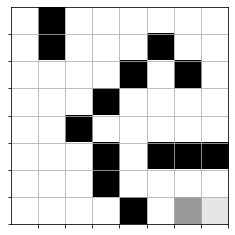

In [12]:
completion_check(model, qmaze)
show(qmaze)

This cell will test your model for one game. It will start the pirate at the top-left corner and run play_game. The agent should find a path from the starting position to the target (treasure). The treasure is located in the bottom-right corner.

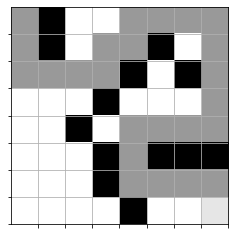

In [13]:
pirate_start = (0, 0)
play_game(model, qmaze, pirate_start)
show(qmaze)

## Save and Submit Your Work
After you have finished creating the code for your notebook, save your work. Make sure that your notebook contains your name in the filename (e.g. Doe_Jane_ProjectTwo.ipynb). This will help your instructor access and grade your work easily. Download a copy of your IPYNB file and submit it to Brightspace. Refer to the Jupyter Notebook in Apporto Tutorial if you need help with these tasks.